# De Bruijn Graph Oligo Design

For our peptide libraries, the main functional motif is a short linear k-mer peptide. In principle, we are wasting lots of oligos that end up repeating the same k-mers multiple times.  Given a set of input ORFs, ideally we would represent each k-mer only once (or twice?) in the set of designed oligos.  Instead of performing sequence clustering with CD-HIT, which is probably a crude approximation, we can probably do much better by building a de bruijn graph from the desired k-mer length, and then covering it with short paths that will become the peptide tiles to reverse translate and synthesize.

As a test, we'll use ORFs from UniProt covering human-infecting viruses (in `virscan2` library) and also ORFs from Staph from NCBI and Harm van Bakel (in `staph` library).

In [1]:
virscan2_orf_file = '/Users/laserson/repos/phage_libraries_private/virscan2/design/uniprot-host-9606-reviewed.fasta'
virscan2_pep_file = '/Users/laserson/repos/phage_libraries_private/virscan2/design/protein_tiles.fasta'
staph_orf_file = '/Users/laserson/repos/phage_libraries_private/staph/design/input_orfs.fasta'
staph_pep_file = '/Users/laserson/repos/phage_libraries_private/staph/design/protein_tiles.fasta'

In [2]:
k = 15
tile_size = 56

In [3]:
!grep "^>" {virscan2_orf_file} | wc -l
!grep "^>" {virscan2_pep_file} | wc -l
!grep "^>" {staph_orf_file} | wc -l
!grep "^>" {staph_pep_file} | wc -l

5914
54710
634624
115785


In [4]:
import sys
import random
from math import ceil
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [5]:
from tqdm import tqdm_notebook as tqdm

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline

In [8]:
def gen_kmers(s, k):
    if k <= 0:
        raise ValueError('k-mer len must be positive')
    if len(s) < k:
        raise ValueError('k-mer len longer than string')
    for i in range(len(s) - k + 1):
        yield s[i:i + k]


def build_debruijn_graph(fasta_file, k):
    dbg = nx.DiGraph()
    for sr in tqdm(SeqIO.parse(fasta_file, 'fasta')):
        s = str(sr.seq)
        if len(s) <= k:
            print('Found record whose length is not longer than k-mer length:\n{}'.format(str(sr)),
                  file=sys.stderr)
            continue
        kmers = list(gen_kmers(s, k))
        # define the graph structure
        dbg.add_path(kmers)
        # add cds labels to nodes and count "multiplicity"
        for kmer in kmers:
            dbg.node[kmer].setdefault('cds', []).append(sr.id)
            dbg.node[kmer]['multiplicity'] = dbg.node[kmer].get('multiplicity', 0) + 1
        # annotate N/C-terminal nodes
        dbg.node[kmers[0]]['nterm'] = True
        dbg.node[kmers[-1]]['cterm'] = True
    return dbg

Some utilities that work on any graph.  The first ones mutate a graph to set counters, the latter ones return aggregates of the values.

In [9]:
def incr_attr(graph, node, attr):
    graph.node[node][attr] = graph.node[node].get(attr, 0) + 1

def zero_attr(graph, node, attr):
    graph.node[node][attr] = 0

def reset_attr(graph, attr):
    for node in graph.nodes():
        graph.node[node][attr] = 0

def sum_attr(graph, nodes, attr):
    return sum([graph.node[node].get(attr, 0) for node in nodes])

def max_attr(graph, nodes, attr):
    return max([graph.node[node].get(attr, 0) for node in nodes])

def graph_sum_attr(graph, attr):
    return sum([d.get(attr, 0) for d in graph.node.values()])

def graph_max_attr(graph, attr):
    return max([d.get(attr, 0) for d in graph.node.values()])

def graph_num_pos_attr(graph, attr):
    return (np.asarray([d.get(attr, 0) for d in graph.node.values()]) > 0).sum()

These functions work with sequences on a DBG.

In [10]:
def sequence_attr_sum(dbg, s, k, attr):
    return sum([dbg.node[kmer].get(attr, 0) for kmer in gen_kmers(s, k)])

def count_kmers_into_attr(dbg, fasta_file, k, attr):
    for sr in tqdm(SeqIO.parse(fasta_file, 'fasta')):
        if len(sr) < k:
            continue
        for kmer in gen_kmers(str(sr.seq), k):
            if dbg.has_node(kmer):
                incr_attr(dbg, kmer, attr)

In [11]:
def plot_graph(g):
    fig, ax = plt.subplots(figsize=(10, 10))
    nx.draw(g, pos=graphviz_layout(g), ax=ax, node_size=10, with_labels=False)

Build the de bruijn graph off of the ORFs

In [12]:
virscan2_dbg = build_debruijn_graph(virscan2_orf_file, k)

Found record whose length is not longer than k-mer length:
ID: sp|B3EUR5|PB1F2_I61A1
Name: sp|B3EUR5|PB1F2_I61A1
Description: sp|B3EUR5|PB1F2_I61A1 Protein PB1-F2 OS=Influenza A virus (strain A/Swine/Wisconsin/1/1961 H1N1) GN=PB1 PE=3 SV=2
Number of features: 0
Seq('MGQEQGIPWIL', SingleLetterAlphabet())
Found record whose length is not longer than k-mer length:
ID: sp|A8C8X2|PB1F2_I67A2
Name: sp|A8C8X2|PB1F2_I67A2
Description: sp|A8C8X2|PB1F2_I67A2 Putative protein PB1-F2 OS=Influenza A virus (strain A/Swine/Wisconsin/1/1967 H1N1) GN=PB1-F2 PE=3 SV=2
Number of features: 0
Seq('MGQEQDTPWIL', SingleLetterAlphabet())
Found record whose length is not longer than k-mer length:
ID: sp|P12481|NEF_HV1Z8
Name: sp|P12481|NEF_HV1Z8
Description: sp|P12481|NEF_HV1Z8 Protein Nef (Fragment) OS=Human immunodeficiency virus type 1 group M subtype D (isolate Z84) GN=nef PE=3 SV=3
Number of features: 0
Seq('MGGKWSKSS', SingleLetterAlphabet())
Found record whose length is not longer than k-mer length:
ID:

Found record whose length is not longer than k-mer length:
ID: sp|P23210|VP19_HHV1K
Name: sp|P23210|VP19_HHV1K
Description: sp|P23210|VP19_HHV1K Triplex capsid protein VP19C (Fragment) OS=Human herpesvirus 1 (strain KOS) GN=UL38 PE=3 SV=1
Number of features: 0
Seq('MKTNPL', SingleLetterAlphabet())


In [16]:
staph_dbg = build_debruijn_graph(staph_orf_file, k)

KeyboardInterrupt: 

45130it [01:10, 642.55it/s]

In [13]:
print(nx.info(virscan2_dbg))

Name: 
Type: DiGraph
Number of nodes: 1440898
Number of edges: 1462592
Average in degree:   1.0151
Average out degree:   1.0151


In [ ]:
print(nx.info(staph_dbg))

In [14]:
virscan2_multiplicities = np.asarray([d['multiplicity'] for d in virscan2_dbg.node.values()])

In [ ]:
staph_multiplicities = np.asarray([d['multiplicity'] for d in staph_dbg.node.values()])

In [15]:
virscan2_multiplicities.max()

145

In [18]:
staph_multiplicities.max()

76380

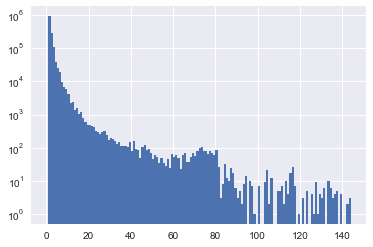

In [19]:
_ = plt.hist(virscan2_multiplicities, bins=range(max(virscan2_multiplicities)), log=True)

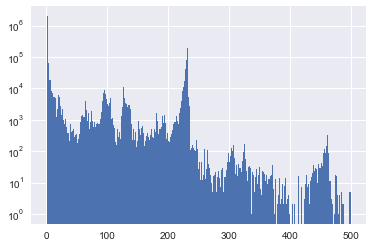

In [22]:
_ = plt.hist(staph_multiplicities, bins=range(500), log=True)

In [24]:
virscan2_multiplicities.mean()

2.0113040617725892

In [26]:
staph_multiplicities.mean()

54.704788917078488

In [29]:
(virscan2_multiplicities == 1).sum()

925488

In [30]:
(virscan2_multiplicities > 1).sum()

515410

In [31]:
(staph_multiplicities == 1).sum()

1982012

In [33]:
(staph_multiplicities > 1).sum()

1306435

In [34]:
(staph_multiplicities > 10).sum()

944915

Most of the k-mers have a single inbound and outbound edge.  The number of multiplicity=1 nodes can be taken as a proxy for unique kmers, which need to be covered by a protein tile.  In theory, for the multiplicity>1 nodes, it would be ideal if we could represent them with a single protein tile as well.  So the best we can hope to do (approx) is the sum of those values divided by tile size.  (Alternatively, it's simply equal to the number of nodes divided by the tile size, since each node represents a unique residue.)

In [35]:
# NUMBER OF OLIGOS IN BEST CASE (approx)
len(virscan2_multiplicities) / (tile_size - k)

35143.85365853659

In [36]:
# NUMBER OF OLIGOS IN BEST CASE (approx)
len(staph_multiplicities) / (tile_size - k)

80206.0243902439

Compute the component subgraphs

In [37]:
nx.number_weakly_connected_components(virscan2_dbg)

1597

In [38]:
nx.number_weakly_connected_components(staph_dbg)

9041

Note how that one quarter and one sixth of the number of input ORFs.

Compute some stats on the components

In [73]:
dbg = virscan2_dbg

component_avg_deg = []
component_num_branched_nodes = []
component_num_orfs = []
component_avg_multiplicity = []
component_max_multiplicity = []
for component in nx.weakly_connected_component_subgraphs(dbg):
    component_avg_deg.append(np.mean([p[1] for p in component.degree_iter()]))
    component_num_branched_nodes.append((np.asarray([p[1] for p in component.degree_iter()]) > 2).sum())
    component_num_orfs.append(len(set([orf for p in component.nodes_iter(True) for orf in p[1]['cds']])))
    component_avg_multiplicity.append(graph_sum_attr(component, 'multiplicity') / len(component))
    component_max_multiplicity.append(graph_max_attr(component, 'multiplicity'))

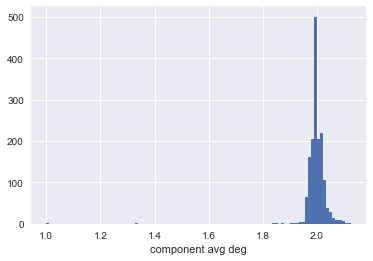

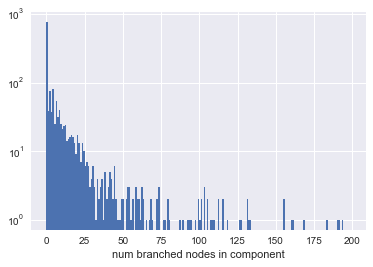

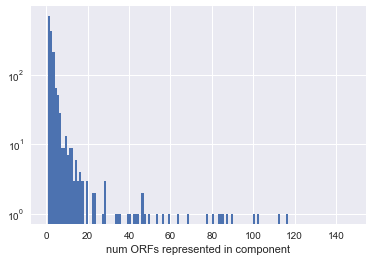

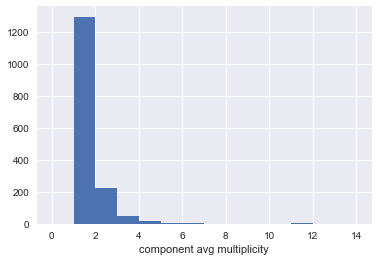

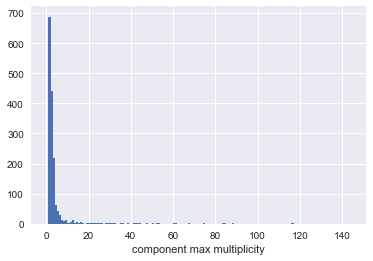

In [92]:
fig, ax = plt.subplots()
_ = ax.hist(component_avg_deg, bins=100, log=False)
_ = ax.set(xlabel='component avg deg')

fig, ax = plt.subplots()
_ = ax.hist(component_num_branched_nodes, bins=range(200), log=True)
_ = ax.set(xlabel='num branched nodes in component')

fig, ax = plt.subplots()
_ = ax.hist(component_num_orfs, bins=range(max(component_num_orfs)), log=True)
_ = ax.set(xlabel='num ORFs represented in component')

fig, ax = plt.subplots()
_ = ax.hist(component_avg_multiplicity, bins=range(ceil(max(component_avg_multiplicity))), log=False)
_ = ax.set(xlabel='component avg multiplicity')

fig, ax = plt.subplots()
_ = ax.hist(component_max_multiplicity, bins=range(ceil(max(component_max_multiplicity))), log=False)
_ = ax.set(xlabel='component max multiplicity')

In [93]:
dbg = staph_dbg

component_avg_deg = []
component_num_branched_nodes = []
component_num_orfs = []
component_avg_multiplicity = []
component_max_multiplicity = []
for component in nx.weakly_connected_component_subgraphs(dbg):
    component_avg_deg.append(np.mean([p[1] for p in component.degree_iter()]))
    component_num_branched_nodes.append((np.asarray([p[1] for p in component.degree_iter()]) > 2).sum())
    component_num_orfs.append(len(set([orf for p in component.nodes_iter(True) for orf in p[1]['cds']])))
    component_avg_multiplicity.append(graph_sum_attr(component, 'multiplicity') / len(component))
    component_max_multiplicity.append(graph_max_attr(component, 'multiplicity'))

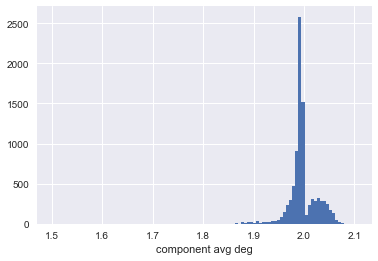

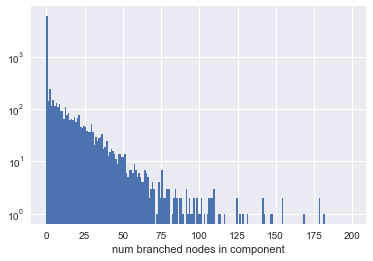

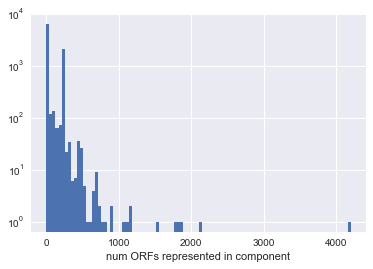

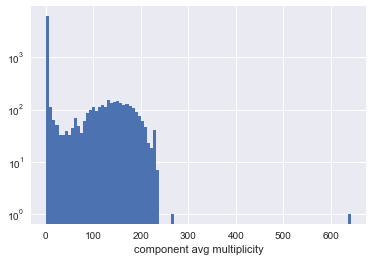

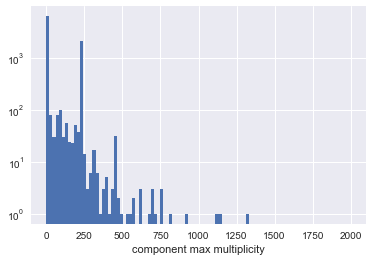

In [97]:
fig, ax = plt.subplots()
_ = ax.hist(component_avg_deg, bins=100, log=False)
_ = ax.set(xlabel='component avg deg')

fig, ax = plt.subplots()
_ = ax.hist(component_num_branched_nodes, bins=range(200), log=True)
_ = ax.set(xlabel='num branched nodes in component')

fig, ax = plt.subplots()
_ = ax.hist(component_num_orfs, bins=100, log=True)
_ = ax.set(xlabel='num ORFs represented in component')

fig, ax = plt.subplots()
_ = ax.hist(component_avg_multiplicity, bins=100, log=True)
_ = ax.set(xlabel='component avg multiplicity')

fig, ax = plt.subplots()
_ = ax.hist(component_max_multiplicity, bins=np.linspace(0, 2000, 100), log=True)
_ = ax.set(xlabel='component max multiplicity')

In [46]:
virscan2_components = list(nx.weakly_connected_component_subgraphs(virscan2_dbg))

In [47]:
staph_components = list(nx.weakly_connected_component_subgraphs(staph_dbg))

Here are some example components

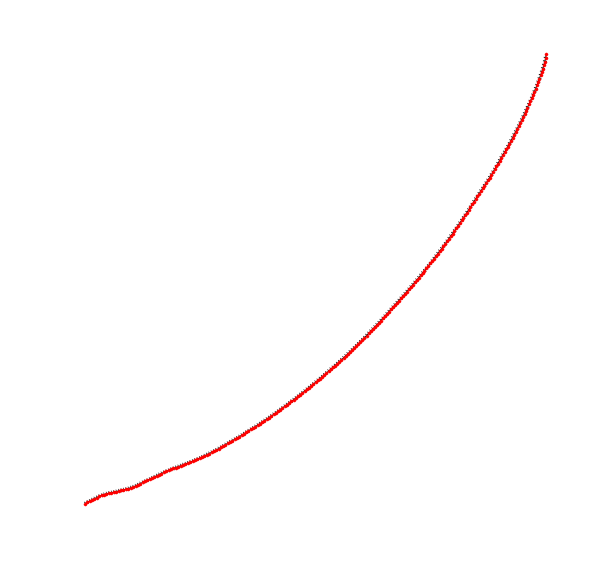

In [50]:
plot_graph(virscan2_components[690])

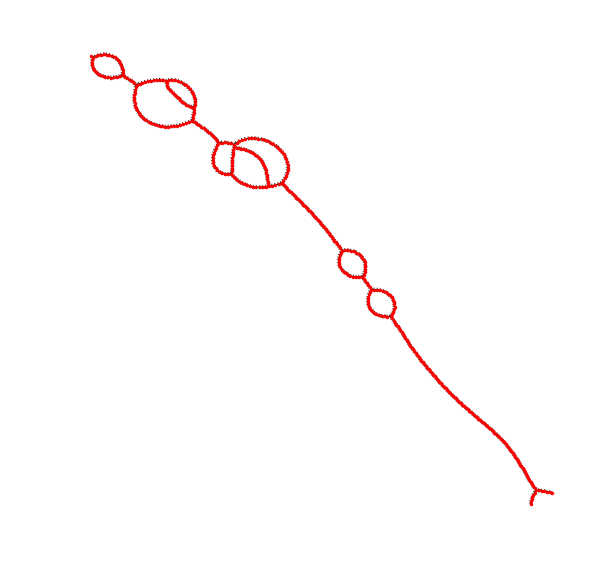

In [52]:
plot_graph(staph_components[45])

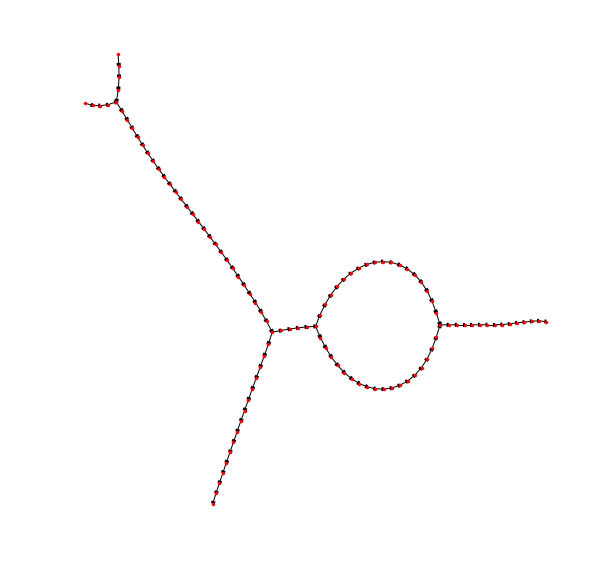

In [53]:
plot_graph(staph_components[1001])

We can add the coverage of the simple-design protein tile library on top of the DBG and then compare the coverage on each k-mer to the multiplicity.

In [101]:
count_kmers_into_attr(virscan2_dbg, virscan2_pep_file, k, attr='coverage')
count_kmers_into_attr(staph_dbg, staph_pep_file, k, attr='coverage')

Compute the coverage values

In [103]:
# recompute m to ensure same order as c
virscan2_multiplicity = []
virscan2_coverage = []
for d in virscan2_dbg.node.values():
    virscan2_multiplicity.append(d['multiplicity'])
    virscan2_coverage.append(d.get('coverage', 0))
virscan2_multiplicity = np.asarray(virscan2_multiplicity)
virscan2_coverage = np.asarray(virscan2_coverage)

In [104]:
# recompute m to ensure same order as c
staph_multiplicity = []
staph_coverage = []
for d in staph_dbg.node.values():
    staph_multiplicity.append(d['multiplicity'])
    staph_coverage.append(d.get('coverage', 0))
staph_multiplicity = np.asarray(staph_multiplicity)
staph_coverage = np.asarray(staph_coverage)

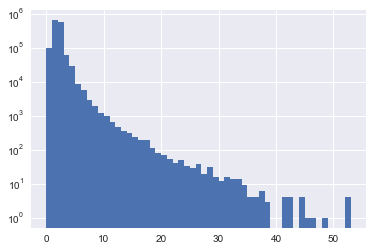

In [106]:
_ = plt.hist(virscan2_coverage, bins=range(max(virscan2_coverage)), log=True)

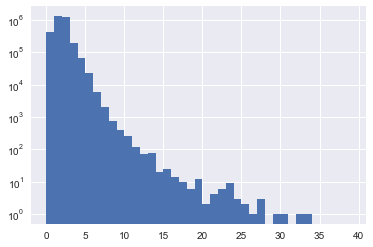

In [109]:
_ = plt.hist(staph_coverage, bins=range(40), log=True)

In [111]:
virscan2_coverage.mean()

1.5906490258158454

In [112]:
virscan2_coverage.max()

54

In [113]:
staph_coverage.mean()

1.4707015195926831

In [114]:
staph_coverage.max()

211

which is consistent with designing for a 2x library coverage?

Comparing the values against each other

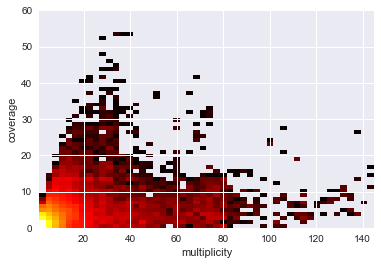

In [117]:
fig, ax = plt.subplots()
_ = ax.hist2d(virscan2_multiplicity, virscan2_coverage, bins=50, norm=mpl.colors.LogNorm(), cmap='hot')
_ = ax.set(xlabel='multiplicity', ylabel='coverage', ylim=(0, 60))

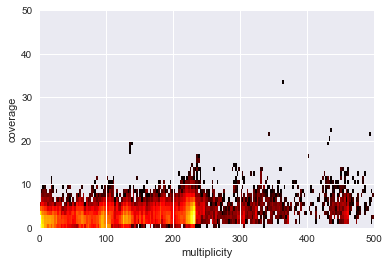

In [126]:
fig, ax = plt.subplots()
_ = ax.hist2d(staph_multiplicity, staph_coverage, bins=[np.linspace(0, 500, 201), np.linspace(0, 50, 51)], norm=mpl.colors.LogNorm(), cmap='hot')
_ = ax.set(xlabel='multiplicity', ylabel='coverage')

**Heuristic strategy**

Build the tile set over several passes.

1. Take all C-terminal and N-terminal tiles.
2. Then create the set of *all* possible tiles from the input ORFs and randomly permute.
3. First pass iteration. Accept a tile if
    - Tile length - sum of weights on nodes it covers > 0.95 * Tile length
4. Second pass iteration. Generate candidate tiles again. Accept a tile if
    - Tile length - sum of weights on nodes it covers > 0
    - Path length from new tile start to any other tile's start > 0.4 * Tile length
    - Path length from new tile end to any other tile's end > 0.4 * Tile length

In [220]:
def is_good_candidate(candidate, dbg, tile_size, k, frac_added_weight=0.95, weight_cutoff=20, covered_multiplicity_factor=0.5):
    covered_weight = sum_attr(dbg, gen_kmers(candidate, k), 'weight')
    max_weight = max_attr(dbg, gen_kmers(candidate, k), 'weight')
    covered_multiplicity = sum_attr(dbg, gen_kmers(candidate, k), 'multiplicity')
    p1 = tile_size - covered_weight > frac_added_weight * tile_size
    p2 = max_weight < weight_cutoff
    p3 = covered_multiplicity > (1 + covered_multiplicity_factor) * tile_size
    return (p1 and p2 and p3)

def all_tiles(fasta_file, tile_size):
    all_tiles = set()
    for sr in tqdm(SeqIO.parse(fasta_file, 'fasta')):
        s = str(sr.seq)
        if len(s) < tile_size:
            print('seq is shorter than tile size\n{}'.format(sr), file=sys.stderr)
            continue
        all_tiles |= set(gen_kmers(s, tile_size))
    return all_tiles

def cterm_tiles(fasta_file, tile_size):
    cterm_tiles = set()
    for sr in tqdm(SeqIO.parse(fasta_file, 'fasta')):
        s = str(sr.seq)
        if len(s) < tile_size:
            print('seq is shorter than tile size\n{}'.format(sr), file=sys.stderr)
            continue
        cterm_tiles.add(s[-tile_size:])
    return cterm_tiles

def select_candidates(candidates, selected_tiles, dbg, tile_size, k,
                      frac_added_weight, weight_cutoff, covered_multiplicity_factor):    
    for candidate in tqdm(candidates):
        if (candidate not in selected_tiles and
            is_good_candidate(candidate, dbg, tile_size, k, frac_added_weight, weight_cutoff, covered_multiplicity_factor)):
            selected_tiles.add(candidate)
            for kmer in gen_kmers(candidate, k):
                incr_attr(dbg, kmer, 'weight')

def tiling_stats(selected_tiles, dbg):
    print('Num tiles: {}'.format(len(selected_tiles)))
    print('Frac kmers covered: {}'.format(graph_num_pos_attr(dbg, 'weight') / len(dbg)))
    print('Max kmer coverage: {}'.format(graph_max_attr(dbg, 'weight')))
    weighted_cov = sum([d['multiplicity'] for d in dbg.node.values() if d.get('weight', 0) > 0]) / graph_sum_attr(dbg, 'multiplicity')
    print('Weighted coverage: {}'.format(weighted_cov))
    cterm_cov = sum([1 for d in dbg.node.values() if (d.get('weight', 0) and d.get('cterm', False))]) / graph_sum_attr(dbg, 'cterm')
    print('C-term coverage: {}'.format(cterm_cov))

In [205]:
sum([True, 0, 0, True])

2

In [195]:
# VIRSCAN2 FIRST
orf_file = virscan2_orf_file
dbg = virscan2_dbg

Generate candidate tiles

In [196]:
all_candidate_tiles = all_tiles(orf_file, tile_size)
cterm_candidate_tiles = cterm_tiles(orf_file, tile_size)
all_candidate_tiles = list(all_candidate_tiles - cterm_candidate_tiles)
cterm_candidate_tiles = list(cterm_candidate_tiles)

seq is shorter than tile size
ID: sp|P0CK28|A145_VACCC
Name: sp|P0CK28|A145_VACCC
Description: sp|P0CK28|A145_VACCC Virion membrane protein A14.5 OS=Vaccinia virus (strain Copenhagen) GN=A 14.5L PE=2 SV=1
Number of features: 0
Seq('MISNYEPLLLLVITCCVLLFNFTISSKTKIDIIFAVQTIVFIWFIFHFVHSAI', SingleLetterAlphabet())
seq is shorter than tile size
ID: sp|P0CK27|A145_VAR67
Name: sp|P0CK27|A145_VAR67
Description: sp|P0CK27|A145_VAR67 Virion membrane protein A14.5 OS=Variola virus (isolate Human/India/Ind3/1967) GN=A 14.5L PE=2 SV=1
Number of features: 0
Seq('MISNYEPLLLLVITCCVLLFNFTISSKTKIDIIFAVQTIVFIWFIFHFVHSAI', SingleLetterAlphabet())
seq is shorter than tile size
ID: sp|P11817|E417_ADE03
Name: sp|P11817|E417_ADE03
Description: sp|P11817|E417_ADE03 Probable early E4 17 kDa protein (Fragment) OS=Human adenovirus B serotype 3 PE=4 SV=1
Number of features: 0
Seq('FKAVRGERLVYSVKWEGGGKITTRIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: sp|P0C6H9|HBEAG_HBVD2
Name: sp|P0C6H9|HBEAG_HBVD

seq is shorter than tile size
ID: sp|P08804|VPU_HV1N5
Name: sp|P08804|VPU_HV1N5
Description: sp|P08804|VPU_HV1N5 Protein Vpu (Fragment) OS=Human immunodeficiency virus type 1 group M subtype B (isolate NY5) GN=vpu PE=3 SV=1
Number of features: 0
Seq('RKVDRIIDRIRERAEDSGNESEGDQEELSALVEMGHDAPWDVNDL', SingleLetterAlphabet())
seq is shorter than tile size
ID: sp|P23210|VP19_HHV1K
Name: sp|P23210|VP19_HHV1K
Description: sp|P23210|VP19_HHV1K Triplex capsid protein VP19C (Fragment) OS=Human herpesvirus 1 (strain KOS) GN=UL38 PE=3 SV=1
Number of features: 0
Seq('MKTNPL', SingleLetterAlphabet())
seq is shorter than tile size
ID: sp|Q02513|VE1_HPV53
Name: sp|Q02513|VE1_HPV53
Description: sp|Q02513|VE1_HPV53 Replication protein E1 (Fragment) OS=Human papillomavirus type 53 GN=E1 PE=3 SV=1
Number of features: 0
Seq('AFHYAQLADVDSNAQAFLKSNMQAKYVKDCGIMCRHYKRAQQQQMNMKQWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: sp|P19326|Z_LYCVP
Name: sp|P19326|Z_LYCVP
Description: sp|P19326|Z_LYCVP

seq is shorter than tile size
ID: sp|P19326|Z_LYCVP
Name: sp|P19326|Z_LYCVP
Description: sp|P19326|Z_LYCVP RING finger protein Z (Fragment) OS=Lymphocytic choriomeningitis virus (strain Pasteur) GN=Z PE=3 SV=1
Number of features: 0
Seq('PDTTYLGPLNCKSCWQKFDSLVRCHDHYLCRHCLNLLLTSSDRCPLCKYPL', SingleLetterAlphabet())


In [197]:
random.shuffle(all_candidate_tiles)
random.shuffle(cterm_candidate_tiles)

In [198]:
reset_attr(dbg, 'weight')
selected_tiles = set()

In [199]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.95, 10, 5)
tiling_stats(selected_tiles, dbg)

Num tiles: 833
Frac kmers covered: 0.023853180447193346
Max kmer coverage: 18
Weighted coverage: 0.16663043583277778


In [200]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.95, 10, 2)
tiling_stats(selected_tiles, dbg)

Num tiles: 2466
Frac kmers covered: 0.07078988242054608
Max kmer coverage: 18
Weighted coverage: 0.2772783673627127


In [201]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.95, 10, 0.5)
tiling_stats(selected_tiles, dbg)

Num tiles: 6608
Frac kmers covered: 0.19010991756529608
Max kmer coverage: 18
Weighted coverage: 0.42518781374176867


In [202]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.75, 10, 0.2)
tiling_stats(selected_tiles, dbg)

Num tiles: 15371
Frac kmers covered: 0.4071599794017342
Max kmer coverage: 18
Weighted coverage: 0.6294948662633657


In [203]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.55, 10, 0.2)
tiling_stats(selected_tiles, dbg)

Num tiles: 20127
Frac kmers covered: 0.4837691495164821
Max kmer coverage: 18
Weighted coverage: 0.7009255080253022


In [204]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.35, 10, 0.2)
tiling_stats(selected_tiles, dbg)

Num tiles: 24596
Frac kmers covered: 0.529167921671069
Max kmer coverage: 18
Weighted coverage: 0.7399450809569357


In [208]:
tiling_stats(selected_tiles, dbg)

Num tiles: 24596
Frac kmers covered: 0.529167921671069
Max kmer coverage: 18
Weighted coverage: 0.7399450809569357
C-term coverage: 0.3711278195488722


In [209]:
# STAPH
orf_file = staph_orf_file
dbg = staph_dbg

In [210]:
all_candidate_tiles = all_tiles(orf_file, tile_size)
cterm_candidate_tiles = cterm_tiles(orf_file, tile_size)
all_candidate_tiles = list(all_candidate_tiles - cterm_candidate_tiles)
cterm_candidate_tiles = list(cterm_candidate_tiles)

seq is shorter than tile size
ID: WP_000009238.1
Name: WP_000009238.1
Description: WP_000009238.1
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_000031108.1
Name: WP_000031108.1
Description: WP_000031108.1
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_000048129.1
Name: WP_000048129.1
Description: WP_000048129.1
Number of features: 0
Seq('MSKTYKSYLVAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_000051210.1
Name: WP_000051210.1
Description: WP_000051210.1
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_000064214.1
Name: WP_000064214.1
Description: WP_000064214.1
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlp

Seq('MSKSSDALFNSLTQSFELIEGVYNELVTDNLKIVMYKPRKESTSGRINRRFK', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_001794441.1
Name: WP_001794441.1
Description: WP_001794441.1
Number of features: 0
Seq('MTYGSIVAILCALFVIFFIPYMEKKDKKKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_001795146.1
Name: WP_001795146.1
Description: WP_001795146.1
Number of features: 0
Seq('MIFSQNLFRCPTPTCIVCRNWESNFSVLGPTPQLALPVEFLFEILCVGAPLL', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_001795991.1
Name: WP_001795991.1
Description: WP_001795991.1
Number of features: 0
Seq('MRLKECGLILGIDLLDHIIIGDNRFTSLVEAGYFDEND', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_001797788.1
Name: WP_001797788.1
Description: WP_001797788.1
Number of features: 0
Seq('MIFSQNLFRRPTPTCIVCRISFRNSFCWGPAKILLE', SingleLetterAlphabet())
seq is shorter than tile size
ID: WP_001801916.1
Name: WP_001801916.1
Description: WP_001801916.1
Number of features: 0
Seq('MINYAIYFNNININSIMALNDNNYQFE

Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00385_3B_prokka|PROKKA_01130
Name: ER00385_3B_prokka|PROKKA_01130
Description: ER00385_3B_prokka|PROKKA_01130
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00385_3B_prokka|PROKKA_01131
Name: ER00385_3B_prokka|PROKKA_01131
Description: ER00385_3B_prokka|PROKKA_01131
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00385_3B_prokka|PROKKA_01149
Name: ER00385_3B_prokka|PROKKA_01149
Description: ER00385_3B_prokka|PROKKA_01149
Number of features: 0
Seq('MNHTIVDSADFQLQANDLISIQGFGRAHITDLGGKTKKDKTHITYRTLFK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00385_3B_prokka|PROKKA_01267
Name: ER00385_3B_prokka|PROKKA_01267
Description: ER00385_3B_prokka|PROKKA_01267
Number of features: 0
Seq('MTRELRKKL

seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_01724
Name: ER00573_3B_prokka|PROKKA_01724
Description: ER00573_3B_prokka|PROKKA_01724
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_01890
Name: ER00573_3B_prokka|PROKKA_01890
Description: ER00573_3B_prokka|PROKKA_01890
Number of features: 0
Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_01897
Name: ER00573_3B_prokka|PROKKA_01897
Description: ER00573_3B_prokka|PROKKA_01897
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_01916
Name: ER00573_3B_prokka|PROKKA_01916
Description: ER00573_3B_prokka|PROKKA_01916
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is 

seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA_00827
Name: ER00594_3B_prokka|PROKKA_00827
Description: ER00594_3B_prokka|PROKKA_00827
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA_00871
Name: ER00594_3B_prokka|PROKKA_00871
Description: ER00594_3B_prokka|PROKKA_00871
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA_00979
Name: ER00594_3B_prokka|PROKKA_00979
Description: ER00594_3B_prokka|PROKKA_00979
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA_01018
Name: ER00594_3B_prokka|PROKKA_01018
Description: ER00594_3B_prokka|PROKKA_01018
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
I

Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA_02644
Name: ER00594_3B_prokka|PROKKA_02644
Description: ER00594_3B_prokka|PROKKA_02644
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA_02731
Name: ER00594_3B_prokka|PROKKA_02731
Description: ER00594_3B_prokka|PROKKA_02731
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA_02760
Name: ER00594_3B_prokka|PROKKA_02760
Description: ER00594_3B_prokka|PROKKA_02760
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00610_3B_prokka|PROKKA_00027
Name: ER00610_3B_prokka|PROKKA_00027
Description: ER00610_3B_prokka|PROKKA_00027
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQT

seq is shorter than tile size
ID: ER00658_3B_prokka|PROKKA_00296
Name: ER00658_3B_prokka|PROKKA_00296
Description: ER00658_3B_prokka|PROKKA_00296
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00658_3B_prokka|PROKKA_00420
Name: ER00658_3B_prokka|PROKKA_00420
Description: ER00658_3B_prokka|PROKKA_00420
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00658_3B_prokka|PROKKA_00437
Name: ER00658_3B_prokka|PROKKA_00437
Description: ER00658_3B_prokka|PROKKA_00437
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00658_3B_prokka|PROKKA_00603
Name: ER00658_3B_prokka|PROKKA_00603
Description: ER00658_3B_prokka|PROKKA_00603
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter t

seq is shorter than tile size
ID: ER00658_3B_prokka|PROKKA_02860
Name: ER00658_3B_prokka|PROKKA_02860
Description: ER00658_3B_prokka|PROKKA_02860
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00695_3B_prokka|PROKKA_00056
Name: ER00695_3B_prokka|PROKKA_00056
Description: ER00695_3B_prokka|PROKKA_00056
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00695_3B_prokka|PROKKA_00074
Name: ER00695_3B_prokka|PROKKA_00074
Description: ER00695_3B_prokka|PROKKA_00074
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00695_3B_prokka|PROKKA_00239
Name: ER00695_3B_prokka|PROKKA_00239
Description: ER00695_3B_prokka|PROKKA_00239
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile

seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_00274
Name: ER00707_3B_prokka|PROKKA_00274
Description: ER00707_3B_prokka|PROKKA_00274
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_00398
Name: ER00707_3B_prokka|PROKKA_00398
Description: ER00707_3B_prokka|PROKKA_00398
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_00415
Name: ER00707_3B_prokka|PROKKA_00415
Description: ER00707_3B_prokka|PROKKA_00415
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_00581
Name: ER00707_3B_prokka|PROKKA_00581
Description: ER00707_3B_prokka|PROKKA_00581
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter t

seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_02056
Name: ER00707_3B_prokka|PROKKA_02056
Description: ER00707_3B_prokka|PROKKA_02056
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_02165
Name: ER00707_3B_prokka|PROKKA_02165
Description: ER00707_3B_prokka|PROKKA_02165
Number of features: 0
Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_02184
Name: ER00707_3B_prokka|PROKKA_02184
Description: ER00707_3B_prokka|PROKKA_02184
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00707_3B_prokka|PROKKA_02197
Name: ER00707_3B_prokka|PROKKA_02197
Description: ER00707_3B_prokka|PROKKA_02197
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID:

seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02482
Name: ER00749_3B_prokka|PROKKA_02482
Description: ER00749_3B_prokka|PROKKA_02482
Number of features: 0
Seq('MKSMKKIADELNVTKMTVYNNAKKANVKFQKN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02495
Name: ER00749_3B_prokka|PROKKA_02495
Description: ER00749_3B_prokka|PROKKA_02495
Number of features: 0
Seq('MKDILVIGATGKQGNAVVKQLLEDGWFCCKVKNIANH', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02497
Name: ER00749_3B_prokka|PROKKA_02497
Description: ER00749_3B_prokka|PROKKA_02497
Number of features: 0
Seq('MKFGNYKIDSFYLIMIIGFLATSLFFPFMLLSIFVLLIIGLEKDDKEG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02500
Name: ER00749_3B_prokka|PROKKA_02500
Description: ER00749_3B_prokka|PROKKA_02500
Number of features: 0
Seq('MSNKKKIKVTLAMINVLLTAVELYLQWQLSKSENEL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_pr

Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00767_3B_prokka|PROKKA_02613
Name: ER00767_3B_prokka|PROKKA_02613
Description: ER00767_3B_prokka|PROKKA_02613
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00887_3B_prokka|PROKKA_00014
Name: ER00887_3B_prokka|PROKKA_00014
Description: ER00887_3B_prokka|PROKKA_00014
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEVPSDYEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00887_3B_prokka|PROKKA_00032
Name: ER00887_3B_prokka|PROKKA_00032
Description: ER00887_3B_prokka|PROKKA_00032
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00887_3B_prokka|PROKKA_00040
Name: ER00887_3B_prokka|PROKKA_00040
Description: ER00887_3B_prokka|PROKKA_00040
Number of features: 0
Seq('MKLLRRLFNKKHE

seq is shorter than tile size
ID: ER00887_3B_prokka|PROKKA_01388
Name: ER00887_3B_prokka|PROKKA_01388
Description: ER00887_3B_prokka|PROKKA_01388
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00887_3B_prokka|PROKKA_01406
Name: ER00887_3B_prokka|PROKKA_01406
Description: ER00887_3B_prokka|PROKKA_01406
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00887_3B_prokka|PROKKA_01572
Name: ER00887_3B_prokka|PROKKA_01572
Description: ER00887_3B_prokka|PROKKA_01572
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00887_3B_prokka|PROKKA_01696
Name: ER00887_3B_prokka|PROKKA_01696
Description: ER00887_3B_prokka|PROKKA_01696
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00887_

seq is shorter than tile size
ID: ER00951_3B_prokka|PROKKA_00061
Name: ER00951_3B_prokka|PROKKA_00061
Description: ER00951_3B_prokka|PROKKA_00061
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00951_3B_prokka|PROKKA_00066
Name: ER00951_3B_prokka|PROKKA_00066
Description: ER00951_3B_prokka|PROKKA_00066
Number of features: 0
Seq('MKEMKRKSVGCYVRVSTISQDIDKFSINGQITQIKEYCQQGNYELLY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00951_3B_prokka|PROKKA_00069
Name: ER00951_3B_prokka|PROKKA_00069
Description: ER00951_3B_prokka|PROKKA_00069
Number of features: 0
Seq('MDMENKKTEWKALYDISKESEMGVAERVSEYG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00951_3B_prokka|PROKKA_00083
Name: ER00951_3B_prokka|PROKKA_00083
Description: ER00951_3B_prokka|PROKKA_00083
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00951_3B_prokka|P

seq is shorter than tile size
ID: ER00951_3B_prokka|PROKKA_02773
Name: ER00951_3B_prokka|PROKKA_02773
Description: ER00951_3B_prokka|PROKKA_02773
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01009_3B_prokka|PROKKA_00017
Name: ER01009_3B_prokka|PROKKA_00017
Description: ER01009_3B_prokka|PROKKA_00017
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01009_3B_prokka|PROKKA_00058
Name: ER01009_3B_prokka|PROKKA_00058
Description: ER01009_3B_prokka|PROKKA_00058
Number of features: 0
Seq('MNYFRYKQFNKDVITVAVGYYLRYALSYRDISEILSERGVNVHHSTVYR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01009_3B_prokka|PROKKA_00062
Name: ER01009_3B_prokka|PROKKA_00062
Description: ER01009_3B_prokka|PROKKA_00062
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
se

seq is shorter than tile size
ID: ER01009_3B_prokka|PROKKA_02596
Name: ER01009_3B_prokka|PROKKA_02596
Description: ER01009_3B_prokka|PROKKA_02596
Number of features: 0
Seq('MKDILVIGATGKQGNAVVKQLLEDGWFCCKVKNIANH', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01009_3B_prokka|PROKKA_02598
Name: ER01009_3B_prokka|PROKKA_02598
Description: ER01009_3B_prokka|PROKKA_02598
Number of features: 0
Seq('MKFGNYKIDSFYLIMIIGFLATSLFFPFMLLSIFVLLIIGLEKDDKEG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01009_3B_prokka|PROKKA_02601
Name: ER01009_3B_prokka|PROKKA_02601
Description: ER01009_3B_prokka|PROKKA_02601
Number of features: 0
Seq('MSNKKKIKVTLAMINVLLTAVELYLQWQLSKSENEL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01009_3B_prokka|PROKKA_02608
Name: ER01009_3B_prokka|PROKKA_02608
Description: ER01009_3B_prokka|PROKKA_02608
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01009_

Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01062_3B_prokka|PROKKA_02831
Name: ER01062_3B_prokka|PROKKA_02831
Description: ER01062_3B_prokka|PROKKA_02831
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01073_3B_prokka|PROKKA_00030
Name: ER01073_3B_prokka|PROKKA_00030
Description: ER01073_3B_prokka|PROKKA_00030
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01073_3B_prokka|PROKKA_00039
Name: ER01073_3B_prokka|PROKKA_00039
Description: ER01073_3B_prokka|PROKKA_00039
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01073_3B_prokka|PROKKA_00053
Name: ER01073_3B_prokka|PROKKA_00053
Description: ER01073_3B_prokka|PROKKA_00053
Number of features: 0
Seq('MIMKHMHLSVLALTFC

seq is shorter than tile size
ID: ER01109_3B_prokka|PROKKA_00786
Name: ER01109_3B_prokka|PROKKA_00786
Description: ER01109_3B_prokka|PROKKA_00786
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01109_3B_prokka|PROKKA_00801
Name: ER01109_3B_prokka|PROKKA_00801
Description: ER01109_3B_prokka|PROKKA_00801
Number of features: 0
Seq('MKMYLAYICLVSLLTILLLAISNMYVAFSVYAWLITLGCNLTGGLENE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01109_3B_prokka|PROKKA_00816
Name: ER01109_3B_prokka|PROKKA_00816
Description: ER01109_3B_prokka|PROKKA_00816
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01109_3B_prokka|PROKKA_00817
Name: ER01109_3B_prokka|PROKKA_00817
Description: ER01109_3B_prokka|PROKKA_00817
Number of features: 0
Seq('MTEQMYLLLFLLSLPLLLFIGRKTHFYCLDKKNGCR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0

Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01109_3B_prokka|PROKKA_02503
Name: ER01109_3B_prokka|PROKKA_02503
Description: ER01109_3B_prokka|PROKKA_02503
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01109_3B_prokka|PROKKA_02712
Name: ER01109_3B_prokka|PROKKA_02712
Description: ER01109_3B_prokka|PROKKA_02712
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01109_3B_prokka|PROKKA_02796
Name: ER01109_3B_prokka|PROKKA_02796
Description: ER01109_3B_prokka|PROKKA_02796
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01184_3A_prokka|PROKKA_00056
Name: ER01184_3A_prokka|PROKKA_00056
Description: ER01184_3A_prokka|PROKKA_00056
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDE

seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_00407
Name: ER01418_3B_prokka|PROKKA_00407
Description: ER01418_3B_prokka|PROKKA_00407
Number of features: 0
Seq('MSVSIGVGYLTDDDPKSQRKVFKDADDMVHVAKNQGRNKVMFNPIINL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_00435
Name: ER01418_3B_prokka|PROKKA_00435
Description: ER01418_3B_prokka|PROKKA_00435
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_00474
Name: ER01418_3B_prokka|PROKKA_00474
Description: ER01418_3B_prokka|PROKKA_00474
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_00511
Name: ER01418_3B_prokka|PROKKA_00511
Description: ER01418_3B_prokka|PROKKA_00511
Number of features: 0
Seq('MKNGGKYTFELHKKLQENRMADVIDGTNIDNIEVNIK', SingleLetterAlphabet())
seq is shorter than tile siz

Seq('MGFKNNLTSNLTIKSVIQSLKIENVDGKGAMPTTIQELRERRTTC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_02363
Name: ER01418_3B_prokka|PROKKA_02363
Description: ER01418_3B_prokka|PROKKA_02363
Number of features: 0
Seq('MQDNKQGLQANPEYTIHYLSQEIMRLTQENAMLKAYIQENKENQQCAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_02388
Name: ER01418_3B_prokka|PROKKA_02388
Description: ER01418_3B_prokka|PROKKA_02388
Number of features: 0
Seq('MKKFFFIGLLVFVVFLQQQPLFGSAMIKTNMVLNNMIKHSKTMLLTMYL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_02403
Name: ER01418_3B_prokka|PROKKA_02403
Description: ER01418_3B_prokka|PROKKA_02403
Number of features: 0
Seq('MSKLQDVIVQEMKVKKRIDSAEEIMELKQFIKNYVQSHSFIKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01418_3B_prokka|PROKKA_02459
Name: ER01418_3B_prokka|PROKKA_02459
Description: ER01418_3B_prokka|PROKKA_02459
Number of features: 0
Seq('MTEQQKFK

Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_00806
Name: ER01425_3B_prokka|PROKKA_00806
Description: ER01425_3B_prokka|PROKKA_00806
Number of features: 0
Seq('MSNIYKSYLIAVLCFTILAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_00816
Name: ER01425_3B_prokka|PROKKA_00816
Description: ER01425_3B_prokka|PROKKA_00816
Number of features: 0
Seq('MITKEFLKTKLECSDMYAQKLIDEAQGDENRLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_00825
Name: ER01425_3B_prokka|PROKKA_00825
Description: ER01425_3B_prokka|PROKKA_00825
Number of features: 0
Seq('MLEIIDQRDALLEEKYLNDDWWYELDYWLNKRKSESEQIDIDRVLKFIEELKR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_00837
Name: ER01425_3B_prokka|PROKKA_00837
Description: ER01425_3B_prokka|PROKKA_00837
Number of features: 0
Seq('

seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_02261
Name: ER01425_3B_prokka|PROKKA_02261
Description: ER01425_3B_prokka|PROKKA_02261
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_02414
Name: ER01425_3B_prokka|PROKKA_02414
Description: ER01425_3B_prokka|PROKKA_02414
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_02478
Name: ER01425_3B_prokka|PROKKA_02478
Description: ER01425_3B_prokka|PROKKA_02478
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_prokka|PROKKA_02586
Name: ER01425_3B_prokka|PROKKA_02586
Description: ER01425_3B_prokka|PROKKA_02586
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01425_3B_

seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_00029
Name: ER01507_3B_prokka|PROKKA_00029
Description: ER01507_3B_prokka|PROKKA_00029
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_00038
Name: ER01507_3B_prokka|PROKKA_00038
Description: ER01507_3B_prokka|PROKKA_00038
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_00059
Name: ER01507_3B_prokka|PROKKA_00059
Description: ER01507_3B_prokka|PROKKA_00059
Number of features: 0
Seq('MNNWIKVAQISVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_00065
Name: ER01507_3B_prokka|PROKKA_00065
Description: ER01507_3B_prokka|PROKKA_00065
Number of features: 0
Seq('MYEENIYIKNSEYEFDNNLKQLASYLNIPVSIVRPYKEDLTLYQYKKRTSHISFN', SingleLetterAlphabet())
seq is shorter than tile size


seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_02703
Name: ER01507_3B_prokka|PROKKA_02703
Description: ER01507_3B_prokka|PROKKA_02703
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_02790
Name: ER01507_3B_prokka|PROKKA_02790
Description: ER01507_3B_prokka|PROKKA_02790
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_02813
Name: ER01507_3B_prokka|PROKKA_02813
Description: ER01507_3B_prokka|PROKKA_02813
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01524_3B_prokka|PROKKA_00029
Name: ER01524_3B_prokka|PROKKA_00029
Description: ER01524_3B_prokka|PROKKA_00029
Number of features: 0
Seq('MNKETLIDLIDMMIGLTEIERKRLSEMEMRKVEIRYKMALTEKTDEMIG', SingleLetterAlphabet())
seq is shorter than til

seq is shorter than tile size
ID: ER01524_3B_prokka|PROKKA_02674
Name: ER01524_3B_prokka|PROKKA_02674
Description: ER01524_3B_prokka|PROKKA_02674
Number of features: 0
Seq('MITVAVIDTGVDIYHNKLYKYINLSKSFC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01524_3B_prokka|PROKKA_02756
Name: ER01524_3B_prokka|PROKKA_02756
Description: ER01524_3B_prokka|PROKKA_02756
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01524_3B_prokka|PROKKA_02843
Name: ER01524_3B_prokka|PROKKA_02843
Description: ER01524_3B_prokka|PROKKA_02843
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01524_3B_prokka|PROKKA_02878
Name: ER01524_3B_prokka|PROKKA_02878
Description: ER01524_3B_prokka|PROKKA_02878
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01532_3

seq is shorter than tile size
ID: ER01532_3B_prokka|PROKKA_02728
Name: ER01532_3B_prokka|PROKKA_02728
Description: ER01532_3B_prokka|PROKKA_02728
Number of features: 0
Seq('MNKETLIDLIDMMIGLTEIERKRLSEMEMRKVEIRYKMALTEKTDEMIG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01532_3B_prokka|PROKKA_02790
Name: ER01532_3B_prokka|PROKKA_02790
Description: ER01532_3B_prokka|PROKKA_02790
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01560_3B_prokka|PROKKA_00074
Name: ER01560_3B_prokka|PROKKA_00074
Description: ER01560_3B_prokka|PROKKA_00074
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01560_3B_prokka|PROKKA_00083
Name: ER01560_3B_prokka|PROKKA_00083
Description: ER01560_3B_prokka|PROKKA_00083
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter th

seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_00326
Name: ER01564_3B_prokka|PROKKA_00326
Description: ER01564_3B_prokka|PROKKA_00326
Number of features: 0
Seq('MNNWIRAAQLTVTIITEVIVIMKEVQDGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_00367
Name: ER01564_3B_prokka|PROKKA_00367
Description: ER01564_3B_prokka|PROKKA_00367
Number of features: 0
Seq('MKMYLTYICLVSLLTILLLAISNMYVAFSVYGMMATYGFNLTGGLENE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_00384
Name: ER01564_3B_prokka|PROKKA_00384
Description: ER01564_3B_prokka|PROKKA_00384
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_00385
Name: ER01564_3B_prokka|PROKKA_00385
Description: ER01564_3B_prokka|PROKKA_00385
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B

seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_02758
Name: ER01564_3B_prokka|PROKKA_02758
Description: ER01564_3B_prokka|PROKKA_02758
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_02789
Name: ER01564_3B_prokka|PROKKA_02789
Description: ER01564_3B_prokka|PROKKA_02789
Number of features: 0
Seq('MGAVIKVGAKVIGWGAASGAGLYGLEKIFKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_02790
Name: ER01564_3B_prokka|PROKKA_02790
Description: ER01564_3B_prokka|PROKKA_02790
Number of features: 0
Seq('MGALIKTGAKIIGSGAAGGLGTYIGHKILGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_02791
Name: ER01564_3B_prokka|PROKKA_02791
Description: ER01564_3B_prokka|PROKKA_02791
Number of features: 0
Seq('MGAVAKFLGKAALGGAAGGATYAGLKKIFG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01564_3B_prokka|PROKKA_

seq is shorter than tile size
ID: ER01570_3B_prokka|PROKKA_01832
Name: ER01570_3B_prokka|PROKKA_01832
Description: ER01570_3B_prokka|PROKKA_01832
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01570_3B_prokka|PROKKA_01867
Name: ER01570_3B_prokka|PROKKA_01867
Description: ER01570_3B_prokka|PROKKA_01867
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01570_3B_prokka|PROKKA_01919
Name: ER01570_3B_prokka|PROKKA_01919
Description: ER01570_3B_prokka|PROKKA_01919
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01570_3B_prokka|PROKKA_01991
Name: ER01570_3B_prokka|PROKKA_01991
Description: ER01570_3B_prokka|PROKKA_01991
Number of features: 0
Seq('MQDNKQGLQANPEYTIHYLSQEIMRLTQENAMLKAYIQENKENQQCAEEE', SingleLetterAlphabet())


Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01689_3B_prokka|PROKKA_02555
Name: ER01689_3B_prokka|PROKKA_02555
Description: ER01689_3B_prokka|PROKKA_02555
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01689_3B_prokka|PROKKA_02593
Name: ER01689_3B_prokka|PROKKA_02593
Description: ER01689_3B_prokka|PROKKA_02593
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01689_3B_prokka|PROKKA_02677
Name: ER01689_3B_prokka|PROKKA_02677
Description: ER01689_3B_prokka|PROKKA_02677
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01719_3B_prokka|PROKKA_00030
Name: ER01719_3B_prokka|PROKKA_00030
Description: ER01719_3B_prokka|PROKKA_00030
Number of features: 0
Seq('MNYFRYKQFNKDVITVAVGYYLRYALSYRDISEILSERGVNVHHSTVYR

Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01746_3B_prokka|PROKKA_00601
Name: ER01746_3B_prokka|PROKKA_00601
Description: ER01746_3B_prokka|PROKKA_00601
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01746_3B_prokka|PROKKA_00819
Name: ER01746_3B_prokka|PROKKA_00819
Description: ER01746_3B_prokka|PROKKA_00819
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01746_3B_prokka|PROKKA_00863
Name: ER01746_3B_prokka|PROKKA_00863
Description: ER01746_3B_prokka|PROKKA_00863
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01746_3B_prokka|PROKKA_00971
Name: ER01746_3B_prokka|PROKKA_00971
Description: ER01746_3B_prokka|PROKKA_00971
Number of features: 0
Seq('MRQFIKRTVKTILVGYVI

seq is shorter than tile size
ID: ER01776_3B_prokka|PROKKA_00860
Name: ER01776_3B_prokka|PROKKA_00860
Description: ER01776_3B_prokka|PROKKA_00860
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01776_3B_prokka|PROKKA_00962
Name: ER01776_3B_prokka|PROKKA_00962
Description: ER01776_3B_prokka|PROKKA_00962
Number of features: 0
Seq('MRQFIKRIIKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01776_3B_prokka|PROKKA_01001
Name: ER01776_3B_prokka|PROKKA_01001
Description: ER01776_3B_prokka|PROKKA_01001
Number of features: 0
Seq('MRRAHEKKPLTTKSCKVKEGYMRRAQAKRPLTTKSCKVKEGYMRRAHA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01776_3B_prokka|PROKKA_01002
Name: ER01776_3B_prokka|PROKKA_01002
Description: ER01776_3B_prokka|PROKKA_01002
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER01776_3B_prokka|PROKKA_02655
Name: ER01776_3B_prokka|PROKKA_02655
Description: ER01776_3B_prokka|PROKKA_02655
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01803_3B_prokka|PROKKA_00029
Name: ER01803_3B_prokka|PROKKA_00029
Description: ER01803_3B_prokka|PROKKA_00029
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01803_3B_prokka|PROKKA_00038
Name: ER01803_3B_prokka|PROKKA_00038
Description: ER01803_3B_prokka|PROKKA_00038
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01803_3B_prokka|PROKKA_00059
Name: ER01803_3B_prokka|PROKKA_00059
Description: ER01803_3B_prokka|PROKKA_00059
Number of features: 0
Seq('MNNWIKVAQISVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0180

seq is shorter than tile size
ID: ER01817_3B_prokka|PROKKA_01070
Name: ER01817_3B_prokka|PROKKA_01070
Description: ER01817_3B_prokka|PROKKA_01070
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01817_3B_prokka|PROKKA_01109
Name: ER01817_3B_prokka|PROKKA_01109
Description: ER01817_3B_prokka|PROKKA_01109
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01817_3B_prokka|PROKKA_01189
Name: ER01817_3B_prokka|PROKKA_01189
Description: ER01817_3B_prokka|PROKKA_01189
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01817_3B_prokka|PROKKA_01202
Name: ER01817_3B_prokka|PROKKA_01202
Description: ER01817_3B_prokka|PROKKA_01202
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile s

seq is shorter than tile size
ID: ER01817_3B_prokka|PROKKA_02729
Name: ER01817_3B_prokka|PROKKA_02729
Description: ER01817_3B_prokka|PROKKA_02729
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01817_3B_prokka|PROKKA_02816
Name: ER01817_3B_prokka|PROKKA_02816
Description: ER01817_3B_prokka|PROKKA_02816
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01823_3B_prokka|PROKKA_00056
Name: ER01823_3B_prokka|PROKKA_00056
Description: ER01823_3B_prokka|PROKKA_00056
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01823_3B_prokka|PROKKA_00074
Name: ER01823_3B_prokka|PROKKA_00074
Description: ER01823_3B_prokka|PROKKA_00074
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01823_

seq is shorter than tile size
ID: ER01836_3B_prokka|PROKKA_01006
Name: ER01836_3B_prokka|PROKKA_01006
Description: ER01836_3B_prokka|PROKKA_01006
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01836_3B_prokka|PROKKA_01045
Name: ER01836_3B_prokka|PROKKA_01045
Description: ER01836_3B_prokka|PROKKA_01045
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01836_3B_prokka|PROKKA_01125
Name: ER01836_3B_prokka|PROKKA_01125
Description: ER01836_3B_prokka|PROKKA_01125
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01836_3B_prokka|PROKKA_01138
Name: ER01836_3B_prokka|PROKKA_01138
Description: ER01836_3B_prokka|PROKKA_01138
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile s

Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01836_3B_prokka|PROKKA_02822
Name: ER01836_3B_prokka|PROKKA_02822
Description: ER01836_3B_prokka|PROKKA_02822
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01838_3B_prokka|PROKKA_00031
Name: ER01838_3B_prokka|PROKKA_00031
Description: ER01838_3B_prokka|PROKKA_00031
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01838_3B_prokka|PROKKA_00040
Name: ER01838_3B_prokka|PROKKA_00040
Description: ER01838_3B_prokka|PROKKA_00040
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01838_3B_prokka|PROKKA_00129
Name: ER01838_3B_prokka|PROKKA_00129
Description: ER01838_3B_prokka|PROKKA_00129
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQR

seq is shorter than tile size
ID: ER01838_3B_prokka|PROKKA_01850
Name: ER01838_3B_prokka|PROKKA_01850
Description: ER01838_3B_prokka|PROKKA_01850
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01838_3B_prokka|PROKKA_01869
Name: ER01838_3B_prokka|PROKKA_01869
Description: ER01838_3B_prokka|PROKKA_01869
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01838_3B_prokka|PROKKA_01904
Name: ER01838_3B_prokka|PROKKA_01904
Description: ER01838_3B_prokka|PROKKA_01904
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01838_3B_prokka|PROKKA_01954
Name: ER01838_3B_prokka|PROKKA_01954
Description: ER01838_3B_prokka|PROKKA_01954
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq

seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_00100
Name: ER01892_3B_prokka|PROKKA_00100
Description: ER01892_3B_prokka|PROKKA_00100
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_00118
Name: ER01892_3B_prokka|PROKKA_00118
Description: ER01892_3B_prokka|PROKKA_00118
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_00283
Name: ER01892_3B_prokka|PROKKA_00283
Description: ER01892_3B_prokka|PROKKA_00283
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_00408
Name: ER01892_3B_prokka|PROKKA_00408
Description: ER01892_3B_prokka|PROKKA_00408
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_

Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_01663
Name: ER01892_3B_prokka|PROKKA_01663
Description: ER01892_3B_prokka|PROKKA_01663
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_01832
Name: ER01892_3B_prokka|PROKKA_01832
Description: ER01892_3B_prokka|PROKKA_01832
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_01847
Name: ER01892_3B_prokka|PROKKA_01847
Description: ER01892_3B_prokka|PROKKA_01847
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01892_3B_prokka|PROKKA_01889
Name: ER01892_3B_prokka|PROKKA_01889
Description: ER01892_3B_prokka|PROKKA_01889
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQIS

seq is shorter than tile size
ID: ER01935_3B_prokka|PROKKA_01838
Name: ER01935_3B_prokka|PROKKA_01838
Description: ER01935_3B_prokka|PROKKA_01838
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01935_3B_prokka|PROKKA_01852
Name: ER01935_3B_prokka|PROKKA_01852
Description: ER01935_3B_prokka|PROKKA_01852
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01935_3B_prokka|PROKKA_01894
Name: ER01935_3B_prokka|PROKKA_01894
Description: ER01935_3B_prokka|PROKKA_01894
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01935_3B_prokka|PROKKA_01946
Name: ER01935_3B_prokka|PROKKA_01946
Description: ER01935_3B_prokka|PROKKA_01946
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_01978
Name: ER02087_3A_prokka|PROKKA_01978
Description: ER02087_3A_prokka|PROKKA_01978
Number of features: 0
Seq('MNTLVNMFFDFIIKLAKAIGIVGGVNACSSLFDEPKVPAELTNLYDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_02028
Name: ER02087_3A_prokka|PROKKA_02028
Description: ER02087_3A_prokka|PROKKA_02028
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_02153
Name: ER02087_3A_prokka|PROKKA_02153
Description: ER02087_3A_prokka|PROKKA_02153
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_02166
Name: ER02087_3A_prokka|PROKKA_02166
Description: ER02087_3A_prokka|PROKKA_02166
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0

seq is shorter than tile size
ID: ER02170_3B_prokka|PROKKA_01973
Name: ER02170_3B_prokka|PROKKA_01973
Description: ER02170_3B_prokka|PROKKA_01973
Number of features: 0
Seq('MQDNKQGLQANPEYTIHYLSQEIMRLTQENAMLKAYIQENKENQQCAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02170_3B_prokka|PROKKA_01977
Name: ER02170_3B_prokka|PROKKA_01977
Description: ER02170_3B_prokka|PROKKA_01977
Number of features: 0
Seq('MMDLIENGKDANEVLKMPFHYVLSIYQNKNNDISEEKAEALIDAF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02170_3B_prokka|PROKKA_01993
Name: ER02170_3B_prokka|PROKKA_01993
Description: ER02170_3B_prokka|PROKKA_01993
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02170_3B_prokka|PROKKA_02013
Name: ER02170_3B_prokka|PROKKA_02013
Description: ER02170_3B_prokka|PROKKA_02013
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPLLYFTTAWSIAGFASIGTFIYYKEYFYEE', SingleLetterAlphabet())
seq

Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02262_3B_prokka|PROKKA_01851
Name: ER02262_3B_prokka|PROKKA_01851
Description: ER02262_3B_prokka|PROKKA_01851
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02262_3B_prokka|PROKKA_01870
Name: ER02262_3B_prokka|PROKKA_01870
Description: ER02262_3B_prokka|PROKKA_01870
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02262_3B_prokka|PROKKA_01905
Name: ER02262_3B_prokka|PROKKA_01905
Description: ER02262_3B_prokka|PROKKA_01905
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02262_3B_prokka|PROKKA_01958
Name: ER02262_3B_prokka|PROKKA_01958
Description: ER02262_3B_prokka|PROKKA_01958
Number of features: 0
Seq('

Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02360_3B_prokka|PROKKA_01538
Name: ER02360_3B_prokka|PROKKA_01538
Description: ER02360_3B_prokka|PROKKA_01538
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02360_3B_prokka|PROKKA_01573
Name: ER02360_3B_prokka|PROKKA_01573
Description: ER02360_3B_prokka|PROKKA_01573
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02360_3B_prokka|PROKKA_01646
Name: ER02360_3B_prokka|PROKKA_01646
Description: ER02360_3B_prokka|PROKKA_01646
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02360_3B_prokka|PROKKA_01815
Name: ER02360_3B_prokka|PROKKA_01815
Description: ER02360_3B_prokka|PROKKA_01815
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', Sin

Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02443_3B_prokka|PROKKA_01253
Name: ER02443_3B_prokka|PROKKA_01253
Description: ER02443_3B_prokka|PROKKA_01253
Number of features: 0
Seq('MENNDSNEVAYLLKDGKFTKVYVNQDSVSFVPG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02443_3B_prokka|PROKKA_01255
Name: ER02443_3B_prokka|PROKKA_01255
Description: ER02443_3B_prokka|PROKKA_01255
Number of features: 0
Seq('MLDSQLDGNVTAKELSESFKELVEEFESIEKAKKNSNSKDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02443_3B_prokka|PROKKA_01279
Name: ER02443_3B_prokka|PROKKA_01279
Description: ER02443_3B_prokka|PROKKA_01279
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02443_3B_prokka|PROKKA_01375
Name: ER02443_3B_prokka|PROKKA_01375
Description: ER02443_3B_prokka|PROKKA_01375
Number of features: 0
Seq('MGPNTEDDEKSAYNNVQVWDGPQQREIGFPISTDNASW

seq is shorter than tile size
ID: ER02495_3B_prokka|PROKKA_01367
Name: ER02495_3B_prokka|PROKKA_01367
Description: ER02495_3B_prokka|PROKKA_01367
Number of features: 0
Seq('MGPNTEDDEKSAYNNVQVWDGPQQREIGFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02495_3B_prokka|PROKKA_01379
Name: ER02495_3B_prokka|PROKKA_01379
Description: ER02495_3B_prokka|PROKKA_01379
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02495_3B_prokka|PROKKA_01428
Name: ER02495_3B_prokka|PROKKA_01428
Description: ER02495_3B_prokka|PROKKA_01428
Number of features: 0
Seq('MLKLISPTFEDIKTWYQLKEYSKEDIAWYVDMEVIDKEEYAIITGEKYPENLES', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02495_3B_prokka|PROKKA_01436
Name: ER02495_3B_prokka|PROKKA_01436
Description: ER02495_3B_prokka|PROKKA_01436
Number of features: 0
Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorte

Seq('MGPNTEDDEKSAYNNVQVWDGPQQREIGFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01400
Name: ER02524_3B_prokka|PROKKA_01400
Description: ER02524_3B_prokka|PROKKA_01400
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01449
Name: ER02524_3B_prokka|PROKKA_01449
Description: ER02524_3B_prokka|PROKKA_01449
Number of features: 0
Seq('MLKLISPTFEDIKTWYQLKEYSKEDIAWYVDMEVIDKEEYAIITGEKYPENLES', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01457
Name: ER02524_3B_prokka|PROKKA_01457
Description: ER02524_3B_prokka|PROKKA_01457
Number of features: 0
Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01477
Name: ER02524_3B_prokka|PROKKA_01477
Description: ER02524_3B_prokka|PROKKA_01477
Number of features: 0
Seq('MIKQILRL

seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_00247
Name: ER02578_3B_prokka|PROKKA_00247
Description: ER02578_3B_prokka|PROKKA_00247
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_00249
Name: ER02578_3B_prokka|PROKKA_00249
Description: ER02578_3B_prokka|PROKKA_00249
Number of features: 0
Seq('MNTLVNMFFDFIIKLAKAIGIVGGVNACSSLFDEPKVPAELTNLYDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_00302
Name: ER02578_3B_prokka|PROKKA_00302
Description: ER02578_3B_prokka|PROKKA_00302
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_00410
Name: ER02578_3B_prokka|PROKKA_00410
Description: ER02578_3B_prokka|PROKKA_00410
Number of features: 0
Seq('MLKLISPTFEDIKTWYQLKEYSKEDIAWYVDMEVIDKEEYAIITGEKYPENLES', SingleLetterAlphabet())
seq is sho

seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_03429
Name: ER02578_3B_prokka|PROKKA_03429
Description: ER02578_3B_prokka|PROKKA_03429
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_03430
Name: ER02578_3B_prokka|PROKKA_03430
Description: ER02578_3B_prokka|PROKKA_03430
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_03442
Name: ER02578_3B_prokka|PROKKA_03442
Description: ER02578_3B_prokka|PROKKA_03442
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02578_3B_prokka|PROKKA_03524
Name: ER02578_3B_prokka|PROKKA_03524
Description: ER02578_3B_prokka|PROKKA_03524
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than 

Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02603_3B_prokka|PROKKA_02731
Name: ER02603_3B_prokka|PROKKA_02731
Description: ER02603_3B_prokka|PROKKA_02731
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02603_3B_prokka|PROKKA_02807
Name: ER02603_3B_prokka|PROKKA_02807
Description: ER02603_3B_prokka|PROKKA_02807
Number of features: 0
Seq('MRNTNKFLLIPYLLWMVIFIIVPVVLLIYFSFLDINGHFSFTNYQQIFTTNI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02603_3B_prokka|PROKKA_02828
Name: ER02603_3B_prokka|PROKKA_02828
Description: ER02603_3B_prokka|PROKKA_02828
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02603_3B_prokka|PROKKA_02829
Name: ER02603_3B_prokka|PROKKA_02829
Description: ER02603_3B_prokka|PROKKA_02829
Number of features: 0
Seq('MKRDTYQSYLF

seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_00280
Name: ER02611_3A_prokka|PROKKA_00280
Description: ER02611_3A_prokka|PROKKA_00280
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_00405
Name: ER02611_3A_prokka|PROKKA_00405
Description: ER02611_3A_prokka|PROKKA_00405
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_00422
Name: ER02611_3A_prokka|PROKKA_00422
Description: ER02611_3A_prokka|PROKKA_00422
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_00588
Name: ER02611_3A_prokka|PROKKA_00588
Description: ER02611_3A_prokka|PROKKA_00588
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter t

seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_01946
Name: ER02611_3A_prokka|PROKKA_01946
Description: ER02611_3A_prokka|PROKKA_01946
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_01977
Name: ER02611_3A_prokka|PROKKA_01977
Description: ER02611_3A_prokka|PROKKA_01977
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_01999
Name: ER02611_3A_prokka|PROKKA_01999
Description: ER02611_3A_prokka|PROKKA_01999
Number of features: 0
Seq('MAKRGKKNGKQSTSRTAKLASKVLRDKRSGKKAKSLAGSVLAQS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02611_3A_prokka|PROKKA_02004
Name: ER02611_3A_prokka|PROKKA_02004
Description: ER02611_3A_prokka|PROKKA_02004
Number of features: 0
Seq('MKITNCKIKKETIVYEVLTSGNQPFTYELPKDLSSHNARKYLEFISQKIDGDKLN', SingleLetterAlphabet())
seq is shor

Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02612_3B_prokka|PROKKA_01115
Name: ER02612_3B_prokka|PROKKA_01115
Description: ER02612_3B_prokka|PROKKA_01115
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02612_3B_prokka|PROKKA_01116
Name: ER02612_3B_prokka|PROKKA_01116
Description: ER02612_3B_prokka|PROKKA_01116
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02612_3B_prokka|PROKKA_01252
Name: ER02612_3B_prokka|PROKKA_01252
Description: ER02612_3B_prokka|PROKKA_01252
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFYKNYEPV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02612_3B_prokka|PROKKA_01256
Name: ER02612_3B_prokka|PROKKA_01256
Description: ER02612_3B_prokka|PROKKA_01256
Number of features: 0
Seq('MFKVNYSILSYYPEYNI

seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00059
Name: ER02637_3B_prokka|PROKKA_00059
Description: ER02637_3B_prokka|PROKKA_00059
Number of features: 0
Seq('MKFGKTIAVVLASSVLLAGCTTDKKKLRHI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00072
Name: ER02637_3B_prokka|PROKKA_00072
Description: ER02637_3B_prokka|PROKKA_00072
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00073
Name: ER02637_3B_prokka|PROKKA_00073
Description: ER02637_3B_prokka|PROKKA_00073
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEDTCTEHMHKIP', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00091
Name: ER02637_3B_prokka|PROKKA_00091
Description: ER02637_3B_prokka|PROKKA_00091
Number of features: 0
Seq('MVAKHVRLLPFYLQYSDEGYLTSIYLVEILIAPSESVT', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0

seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_02056
Name: ER02637_3B_prokka|PROKKA_02056
Description: ER02637_3B_prokka|PROKKA_02056
Number of features: 0
Seq('MNVDMAIEMCNHRVLKVDAPIVEGSFIAAVKLSIGGSIDDALAEIKQSF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_02132
Name: ER02637_3B_prokka|PROKKA_02132
Description: ER02637_3B_prokka|PROKKA_02132
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_02224
Name: ER02637_3B_prokka|PROKKA_02224
Description: ER02637_3B_prokka|PROKKA_02224
Number of features: 0
Seq('MKIINTTRLPEALGPYSHATVVNGMVYTSGQIPLNVDGKIVSADVQAQTKQVLEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_02304
Name: ER02637_3B_prokka|PROKKA_02304
Description: ER02637_3B_prokka|PROKKA_02304
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlp

Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_00559
Name: ER02637_3C_prokka|PROKKA_00559
Description: ER02637_3C_prokka|PROKKA_00559
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_00677
Name: ER02637_3C_prokka|PROKKA_00677
Description: ER02637_3C_prokka|PROKKA_00677
Number of features: 0
Seq('MIYTVTFNPSIDYVIFTNDFKIDGLNRATATYKFAGGKVLMSRAS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_00788
Name: ER02637_3C_prokka|PROKKA_00788
Description: ER02637_3C_prokka|PROKKA_00788
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_00819
Name: ER02637_3C_prokka|PROKKA_00819
Description: ER02637_3C_prokka|PROKKA_00819
Number of features: 0
Seq('MNRLRIIK

seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_02486
Name: ER02637_3C_prokka|PROKKA_02486
Description: ER02637_3C_prokka|PROKKA_02486
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_02495
Name: ER02637_3C_prokka|PROKKA_02495
Description: ER02637_3C_prokka|PROKKA_02495
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_02559
Name: ER02637_3C_prokka|PROKKA_02559
Description: ER02637_3C_prokka|PROKKA_02559
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_02667
Name: ER02637_3C_prokka|PROKKA_02667
Description: ER02637_3C_prokka|PROKKA_02667
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3C_prokka|PROKKA_02705
Name

seq is shorter than tile size
ID: ER02658_3B_prokka|PROKKA_02782
Name: ER02658_3B_prokka|PROKKA_02782
Description: ER02658_3B_prokka|PROKKA_02782
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02693_3B_prokka|PROKKA_00030
Name: ER02693_3B_prokka|PROKKA_00030
Description: ER02693_3B_prokka|PROKKA_00030
Number of features: 0
Seq('MNYFRYKQFNKDVITVAVGYYLRYALSYRDISEILSERGVNVHHSTVYR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02693_3B_prokka|PROKKA_00034
Name: ER02693_3B_prokka|PROKKA_00034
Description: ER02693_3B_prokka|PROKKA_00034
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02693_3B_prokka|PROKKA_00043
Name: ER02693_3B_prokka|PROKKA_00043
Description: ER02693_3B_prokka|PROKKA_00043
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than t

seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_00853
Name: ER02703_3B_prokka|PROKKA_00853
Description: ER02703_3B_prokka|PROKKA_00853
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_00897
Name: ER02703_3B_prokka|PROKKA_00897
Description: ER02703_3B_prokka|PROKKA_00897
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_01005
Name: ER02703_3B_prokka|PROKKA_01005
Description: ER02703_3B_prokka|PROKKA_01005
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_01044
Name: ER02703_3B_prokka|PROKKA_01044
Description: ER02703_3B_prokka|PROKKA_01044
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
I

Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_02270
Name: ER02703_3B_prokka|PROKKA_02270
Description: ER02703_3B_prokka|PROKKA_02270
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_02301
Name: ER02703_3B_prokka|PROKKA_02301
Description: ER02703_3B_prokka|PROKKA_02301
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_02457
Name: ER02703_3B_prokka|PROKKA_02457
Description: ER02703_3B_prokka|PROKKA_02457
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02703_3B_prokka|PROKKA_02666
Name: ER02703_3B_prokka|PROKKA_02666
Description: ER02703_3B_prokka|PROKKA_02666
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQA

seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_02539
Name: ER02746_3B_prokka|PROKKA_02539
Description: ER02746_3B_prokka|PROKKA_02539
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_02623
Name: ER02746_3B_prokka|PROKKA_02623
Description: ER02746_3B_prokka|PROKKA_02623
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_02632
Name: ER02746_3B_prokka|PROKKA_02632
Description: ER02746_3B_prokka|PROKKA_02632
Number of features: 0
Seq('MNTKILTGMTGSSLERKINNFINDNQIEVIDIKFSSSVFYFGVMIIYK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_02636
Name: ER02746_3B_prokka|PROKKA_02636
Description: ER02746_3B_prokka|PROKKA_02636
Number of features: 0
Seq('MQYNTTRSITENQDNKTLKDMTKSGKQRPWREKKIDNVRFCCKVKK', SingleLetterAlphabet())
seq is shorter than tile si

Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02836_3A_prokka|PROKKA_00057
Name: ER02836_3A_prokka|PROKKA_00057
Description: ER02836_3A_prokka|PROKKA_00057
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02836_3A_prokka|PROKKA_00078
Name: ER02836_3A_prokka|PROKKA_00078
Description: ER02836_3A_prokka|PROKKA_00078
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02836_3A_prokka|PROKKA_00244
Name: ER02836_3A_prokka|PROKKA_00244
Description: ER02836_3A_prokka|PROKKA_00244
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02836_3A_prokka|PROKKA_00316
Name: ER02836_3A_prokka|PROKKA_00316
Description: ER02836_3A_prokka|PROKKA_00316
Number of features: 0
Seq('MKRLLSLLLASALILSACG

seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_00280
Name: ER02837_3A_prokka|PROKKA_00280
Description: ER02837_3A_prokka|PROKKA_00280
Number of features: 0
Seq('MTQKELANKVGVTRQTISLIEKGVHNPSLSLCKNICSVLNKNLDEIFGEKPQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_00324
Name: ER02837_3A_prokka|PROKKA_00324
Description: ER02837_3A_prokka|PROKKA_00324
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_00448
Name: ER02837_3A_prokka|PROKKA_00448
Description: ER02837_3A_prokka|PROKKA_00448
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_00465
Name: ER02837_3A_prokka|PROKKA_00465
Description: ER02837_3A_prokka|PROKKA_00465
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than

seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_01992
Name: ER02837_3A_prokka|PROKKA_01992
Description: ER02837_3A_prokka|PROKKA_01992
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_01994
Name: ER02837_3A_prokka|PROKKA_01994
Description: ER02837_3A_prokka|PROKKA_01994
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_01995
Name: ER02837_3A_prokka|PROKKA_01995
Description: ER02837_3A_prokka|PROKKA_01995
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02837_3A_prokka|PROKKA_02025
Name: ER02837_3A_prokka|PROKKA_02025
Description: ER02837_3A_prokka|PROKKA_02025
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than t

seq is shorter than tile size
ID: ER02878_3A_prokka|PROKKA_02125
Name: ER02878_3A_prokka|PROKKA_02125
Description: ER02878_3A_prokka|PROKKA_02125
Number of features: 0
Seq('MNDSNQGLQANPQYTIHYLSQEITRLTQENAMLKAYIQEQNEKSKSAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02878_3A_prokka|PROKKA_02129
Name: ER02878_3A_prokka|PROKKA_02129
Description: ER02878_3A_prokka|PROKKA_02129
Number of features: 0
Seq('MMDLIENGKDANEVLKMPFHYVLSIYQNKNNDISEEKAEALIDAF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02878_3A_prokka|PROKKA_02145
Name: ER02878_3A_prokka|PROKKA_02145
Description: ER02878_3A_prokka|PROKKA_02145
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02878_3A_prokka|PROKKA_02163
Name: ER02878_3A_prokka|PROKKA_02163
Description: ER02878_3A_prokka|PROKKA_02163
Number of features: 0
Seq('MSKTYKSYLVAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq

seq is shorter than tile size
ID: ER02886_3A_prokka|PROKKA_01929
Name: ER02886_3A_prokka|PROKKA_01929
Description: ER02886_3A_prokka|PROKKA_01929
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02886_3A_prokka|PROKKA_01944
Name: ER02886_3A_prokka|PROKKA_01944
Description: ER02886_3A_prokka|PROKKA_01944
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02886_3A_prokka|PROKKA_01945
Name: ER02886_3A_prokka|PROKKA_01945
Description: ER02886_3A_prokka|PROKKA_01945
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02886_3A_prokka|PROKKA_01977
Name: ER02886_3A_prokka|PROKKA_01977
Description: ER02886_3A_prokka|PROKKA_01977
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile

seq is shorter than tile size
ID: ER02919_3A_prokka|PROKKA_02085
Name: ER02919_3A_prokka|PROKKA_02085
Description: ER02919_3A_prokka|PROKKA_02085
Number of features: 0
Seq('MNTLVNMFFDFIIKLAKAIGIVGGVNACSSLFDEPKVPAELTNLYDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02919_3A_prokka|PROKKA_02135
Name: ER02919_3A_prokka|PROKKA_02135
Description: ER02919_3A_prokka|PROKKA_02135
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02919_3A_prokka|PROKKA_02261
Name: ER02919_3A_prokka|PROKKA_02261
Description: ER02919_3A_prokka|PROKKA_02261
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02919_3A_prokka|PROKKA_02275
Name: ER02919_3A_prokka|PROKKA_02275
Description: ER02919_3A_prokka|PROKKA_02275
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0

seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_00415
Name: ER02969_3A_prokka|PROKKA_00415
Description: ER02969_3A_prokka|PROKKA_00415
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_00545
Name: ER02969_3A_prokka|PROKKA_00545
Description: ER02969_3A_prokka|PROKKA_00545
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_00581
Name: ER02969_3A_prokka|PROKKA_00581
Description: ER02969_3A_prokka|PROKKA_00581
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_00784
Name: ER02969_3A_prokka|PROKKA_00784
Description: ER02969_3A_prokka|PROKKA_00784
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_02195
Name: ER02969_3A_prokka|PROKKA_02195
Description: ER02969_3A_prokka|PROKKA_02195
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_02226
Name: ER02969_3A_prokka|PROKKA_02226
Description: ER02969_3A_prokka|PROKKA_02226
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_02381
Name: ER02969_3A_prokka|PROKKA_02381
Description: ER02969_3A_prokka|PROKKA_02381
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02969_3A_prokka|PROKKA_02589
Name: ER02969_3A_prokka|PROKKA_02589
Description: ER02969_3A_prokka|PROKKA_02589
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQA

Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02988_3A_prokka|PROKKA_00545
Name: ER02988_3A_prokka|PROKKA_00545
Description: ER02988_3A_prokka|PROKKA_00545
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02988_3A_prokka|PROKKA_00581
Name: ER02988_3A_prokka|PROKKA_00581
Description: ER02988_3A_prokka|PROKKA_00581
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02988_3A_prokka|PROKKA_00623
Name: ER02988_3A_prokka|PROKKA_00623
Description: ER02988_3A_prokka|PROKKA_00623
Number of features: 0
Seq('MMKKLINKKETFLTDMLEGLLIAHPELDLIANTVIVKKLRKNMV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02988_3A_prokka|PROKKA_00783
Name: ER02988_3A_prokka|PROKKA_00783
Description: ER02988_3A_prokka|PROKKA_00783
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEI

Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_00832
Name: ER02989_3A_prokka|PROKKA_00832
Description: ER02989_3A_prokka|PROKKA_00832
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_00863
Name: ER02989_3A_prokka|PROKKA_00863
Description: ER02989_3A_prokka|PROKKA_00863
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_00867
Name: ER02989_3A_prokka|PROKKA_00867
Description: ER02989_3A_prokka|PROKKA_00867
Number of features: 0
Seq('MVTKEFLKIKLECSDMYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_00883
Name: ER02989_3A_prokka|PROKKA_00883
Description: ER02989_3A_prokka|PROKKA_00883
Number of features: 0
Seq('MM

seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_02146
Name: ER02989_3A_prokka|PROKKA_02146
Description: ER02989_3A_prokka|PROKKA_02146
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_02255
Name: ER02989_3A_prokka|PROKKA_02255
Description: ER02989_3A_prokka|PROKKA_02255
Number of features: 0
Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_02274
Name: ER02989_3A_prokka|PROKKA_02274
Description: ER02989_3A_prokka|PROKKA_02274
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02989_3A_prokka|PROKKA_02287
Name: ER02989_3A_prokka|PROKKA_02287
Description: ER02989_3A_prokka|PROKKA_02287
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID:

seq is shorter than tile size
ID: ER03023_3A_prokka|PROKKA_02751
Name: ER03023_3A_prokka|PROKKA_02751
Description: ER03023_3A_prokka|PROKKA_02751
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03023_3A_prokka|PROKKA_02835
Name: ER03023_3A_prokka|PROKKA_02835
Description: ER03023_3A_prokka|PROKKA_02835
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03113_3A_prokka|PROKKA_00031
Name: ER03113_3A_prokka|PROKKA_00031
Description: ER03113_3A_prokka|PROKKA_00031
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03113_3A_prokka|PROKKA_00062
Name: ER03113_3A_prokka|PROKKA_00062
Description: ER03113_3A_prokka|PROKKA_00062
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter th

seq is shorter than tile size
ID: ER03113_3A_prokka|PROKKA_02641
Name: ER03113_3A_prokka|PROKKA_02641
Description: ER03113_3A_prokka|PROKKA_02641
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03113_3A_prokka|PROKKA_02728
Name: ER03113_3A_prokka|PROKKA_02728
Description: ER03113_3A_prokka|PROKKA_02728
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03159_3A_prokka|PROKKA_00004
Name: ER03159_3A_prokka|PROKKA_00004
Description: ER03159_3A_prokka|PROKKA_00004
Number of features: 0
Seq('MKVTNTIRFEEEKKNLIDNVVNTLEEYKDVIDSELRTIRNTGSVAKLKIM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03159_3A_prokka|PROKKA_00038
Name: ER03159_3A_prokka|PROKKA_00038
Description: ER03159_3A_prokka|PROKKA_00038
Number of features: 0
Seq('MKVTNTIRFEEEKKNLIDNVVNTLEEYKDVIDSELRTIRNTGSVAKLKIM', SingleLetterAlphabet())
seq is shorter than t

seq is shorter than tile size
ID: ER03159_3A_prokka|PROKKA_01593
Name: ER03159_3A_prokka|PROKKA_01593
Description: ER03159_3A_prokka|PROKKA_01593
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03159_3A_prokka|PROKKA_01660
Name: ER03159_3A_prokka|PROKKA_01660
Description: ER03159_3A_prokka|PROKKA_01660
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03159_3A_prokka|PROKKA_01672
Name: ER03159_3A_prokka|PROKKA_01672
Description: ER03159_3A_prokka|PROKKA_01672
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03159_3A_prokka|PROKKA_01767
Name: ER03159_3A_prokka|PROKKA_01767
Description: ER03159_3A_prokka|PROKKA_01767
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0315

seq is shorter than tile size
ID: ER03234_3A_prokka|PROKKA_00448
Name: ER03234_3A_prokka|PROKKA_00448
Description: ER03234_3A_prokka|PROKKA_00448
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03234_3A_prokka|PROKKA_00486
Name: ER03234_3A_prokka|PROKKA_00486
Description: ER03234_3A_prokka|PROKKA_00486
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03234_3A_prokka|PROKKA_00559
Name: ER03234_3A_prokka|PROKKA_00559
Description: ER03234_3A_prokka|PROKKA_00559
Number of features: 0
Seq('MTFNHIVFKNLRQNLKHYAMYLFSLFLASSYISVLQPYSLLKV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03234_3A_prokka|PROKKA_00571
Name: ER03234_3A_prokka|PROKKA_00571
Description: ER03234_3A_prokka|PROKKA_00571
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03234

Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03298_3A_prokka|PROKKA_01000
Name: ER03298_3A_prokka|PROKKA_01000
Description: ER03298_3A_prokka|PROKKA_01000
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03298_3A_prokka|PROKKA_01039
Name: ER03298_3A_prokka|PROKKA_01039
Description: ER03298_3A_prokka|PROKKA_01039
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03298_3A_prokka|PROKKA_01119
Name: ER03298_3A_prokka|PROKKA_01119
Description: ER03298_3A_prokka|PROKKA_01119
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03298_3A_prokka|PROKKA_01132
Name: ER03298_3A_prokka|PROKKA_01132
Description: ER03298_3A_prokka|PROKKA_01132
Number of features: 0
Seq('MEGLFNAIKDTVTAA

seq is shorter than tile size
ID: ER03298_3A_prokka|PROKKA_02746
Name: ER03298_3A_prokka|PROKKA_02746
Description: ER03298_3A_prokka|PROKKA_02746
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03321_3A_prokka|PROKKA_00073
Name: ER03321_3A_prokka|PROKKA_00073
Description: ER03321_3A_prokka|PROKKA_00073
Number of features: 0
Seq('MHFLKEGDLTIYFYIWNKKEYLTSDLFDLTESEKQEINHQVIDEIEEEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03321_3A_prokka|PROKKA_00074
Name: ER03321_3A_prokka|PROKKA_00074
Description: ER03321_3A_prokka|PROKKA_00074
Number of features: 0
Seq('MSNKKKIKVTLAMINVLLTAVELYLQWQLSKSENEL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03321_3A_prokka|PROKKA_00081
Name: ER03321_3A_prokka|PROKKA_00081
Description: ER03321_3A_prokka|PROKKA_00081
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter 

seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_00801
Name: ER03364_3A_prokka|PROKKA_00801
Description: ER03364_3A_prokka|PROKKA_00801
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_00827
Name: ER03364_3A_prokka|PROKKA_00827
Description: ER03364_3A_prokka|PROKKA_00827
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_00936
Name: ER03364_3A_prokka|PROKKA_00936
Description: ER03364_3A_prokka|PROKKA_00936
Number of features: 0
Seq('MRQFIKRIVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_00975
Name: ER03364_3A_prokka|PROKKA_00975
Description: ER03364_3A_prokka|PROKKA_00975
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
I

seq is shorter than tile size
ID: ER03442_3A_prokka|PROKKA_01239
Name: ER03442_3A_prokka|PROKKA_01239
Description: ER03442_3A_prokka|PROKKA_01239
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03442_3A_prokka|PROKKA_01243
Name: ER03442_3A_prokka|PROKKA_01243
Description: ER03442_3A_prokka|PROKKA_01243
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03442_3A_prokka|PROKKA_01247
Name: ER03442_3A_prokka|PROKKA_01247
Description: ER03442_3A_prokka|PROKKA_01247
Number of features: 0
Seq('MENNDSNEVAYLLKDGKFTKVYVNQDSVSFVPG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03442_3A_prokka|PROKKA_01249
Name: ER03442_3A_prokka|PROKKA_01249
Description: ER03442_3A_prokka|PROKKA_01249
Number of features: 0
Seq('MLDSQLDGNVTAKELSESFKELVEEFESIEKAKKNSNSKDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03442_3A_prokka|PROKKA_0127

seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_00057
Name: ER03444_3A_prokka|PROKKA_00057
Description: ER03444_3A_prokka|PROKKA_00057
Number of features: 0
Seq('MIEWFEKEACDGFMLMAPTYPESFEKFVYLVIPIFQERVILEATMRVIC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_00223
Name: ER03444_3A_prokka|PROKKA_00223
Description: ER03444_3A_prokka|PROKKA_00223
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_00297
Name: ER03444_3A_prokka|PROKKA_00297
Description: ER03444_3A_prokka|PROKKA_00297
Number of features: 0
Seq('MNLKEVDINIEEWEMVEIPFYTEEELTYRLNNGLPITKGELEEQESKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_00302
Name: ER03444_3A_prokka|PROKKA_00302
Description: ER03444_3A_prokka|PROKKA_00302
Number of features: 0
Seq('MKEFNEKLQELLERDQNDMIEPIEWSQENEEVSNDETIITTKFKYKVPTPNKRKD', SingleLetterAlphabet())


seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_01746
Name: ER03444_3A_prokka|PROKKA_01746
Description: ER03444_3A_prokka|PROKKA_01746
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_01775
Name: ER03444_3A_prokka|PROKKA_01775
Description: ER03444_3A_prokka|PROKKA_01775
Number of features: 0
Seq('MMWFIIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_01791
Name: ER03444_3A_prokka|PROKKA_01791
Description: ER03444_3A_prokka|PROKKA_01791
Number of features: 0
Seq('MVTKEFLKTKLECSDMYAQKLIDEAQGDENRLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03444_3A_prokka|PROKKA_01795
Name: ER03444_3A_prokka|PROKKA_01795
Description: ER03444_3A_prokka|PROKKA_01795
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRNAMHAVKVEKILKSPFS', SingleLetterAlphabet())
seq is shorter than 

Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_00666
Name: ER03448_3A_prokka|PROKKA_00666
Description: ER03448_3A_prokka|PROKKA_00666
Number of features: 0
Seq('MIYTVTFNPSIDYVIFTNDFKIDGLNRATATYKFAGGKVLMSRAS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_00774
Name: ER03448_3A_prokka|PROKKA_00774
Description: ER03448_3A_prokka|PROKKA_00774
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_00810
Name: ER03448_3A_prokka|PROKKA_00810
Description: ER03448_3A_prokka|PROKKA_00810
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_00940
Name: ER03448_3A_prokka|PROKKA_00940
Description: ER03448_3A_prokka|PROKKA_00940
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGE

Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_02546
Name: ER03448_3A_prokka|PROKKA_02546
Description: ER03448_3A_prokka|PROKKA_02546
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_02617
Name: ER03448_3A_prokka|PROKKA_02617
Description: ER03448_3A_prokka|PROKKA_02617
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_02654
Name: ER03448_3A_prokka|PROKKA_02654
Description: ER03448_3A_prokka|PROKKA_02654
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03448_3A_prokka|PROKKA_02681
Name: ER03448_3A_prokka|PROKKA_02681
Description: ER03448_3A_prokka|PROKKA_02681
Number of features: 0
Seq('MVDKNKKQETTRSNPLN

seq is shorter than tile size
ID: ER03481_3B_prokka|PROKKA_01140
Name: ER03481_3B_prokka|PROKKA_01140
Description: ER03481_3B_prokka|PROKKA_01140
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03481_3B_prokka|PROKKA_01152
Name: ER03481_3B_prokka|PROKKA_01152
Description: ER03481_3B_prokka|PROKKA_01152
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03481_3B_prokka|PROKKA_01153
Name: ER03481_3B_prokka|PROKKA_01153
Description: ER03481_3B_prokka|PROKKA_01153
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03481_3B_prokka|PROKKA_01290
Name: ER03481_3B_prokka|PROKKA_01290
Description: ER03481_3B_prokka|PROKKA_01290
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFYKNYEPV', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER03489_3B_prokka|PROKKA_00187
Name: ER03489_3B_prokka|PROKKA_00187
Description: ER03489_3B_prokka|PROKKA_00187
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03489_3B_prokka|PROKKA_00236
Name: ER03489_3B_prokka|PROKKA_00236
Description: ER03489_3B_prokka|PROKKA_00236
Number of features: 0
Seq('MKGALIDDLKIQNLRGERTINDAAKYNSKEKTGASPYEGIRTCL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03489_3B_prokka|PROKKA_00291
Name: ER03489_3B_prokka|PROKKA_00291
Description: ER03489_3B_prokka|PROKKA_00291
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03489_3B_prokka|PROKKA_00330
Name: ER03489_3B_prokka|PROKKA_00330
Description: ER03489_3B_prokka|PROKKA_00330
Number of features: 0
Seq('MSVGAFLTLGFVIFSIHKGRRTKNESARKSNI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03489_3B

seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_00431
Name: ER03493_3B_prokka|PROKKA_00431
Description: ER03493_3B_prokka|PROKKA_00431
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_00469
Name: ER03493_3B_prokka|PROKKA_00469
Description: ER03493_3B_prokka|PROKKA_00469
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_00599
Name: ER03493_3B_prokka|PROKKA_00599
Description: ER03493_3B_prokka|PROKKA_00599
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_00635
Name: ER03493_3B_prokka|PROKKA_00635
Description: ER03493_3B_prokka|PROKKA_00635
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than til

seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_00559
Name: ER03544_3B_prokka|PROKKA_00559
Description: ER03544_3B_prokka|PROKKA_00559
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_00788
Name: ER03544_3B_prokka|PROKKA_00788
Description: ER03544_3B_prokka|PROKKA_00788
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_00819
Name: ER03544_3B_prokka|PROKKA_00819
Description: ER03544_3B_prokka|PROKKA_00819
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_00823
Name: ER03544_3B_prokka|PROKKA_00823
Description: ER03544_3B_prokka|PROKKA_00823
Number of features: 0
Seq('MVTKEFLKIKLECSDMYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is 

Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_02298
Name: ER03544_3B_prokka|PROKKA_02298
Description: ER03544_3B_prokka|PROKKA_02298
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_02311
Name: ER03544_3B_prokka|PROKKA_02311
Description: ER03544_3B_prokka|PROKKA_02311
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_02343
Name: ER03544_3B_prokka|PROKKA_02343
Description: ER03544_3B_prokka|PROKKA_02343
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03544_3B_prokka|PROKKA_02488
Name: ER03544_3B_prokka|PROKKA_02488
Description: ER03544_3B_prokka|PROKKA_02488
Number of features: 0
Seq('MARLNITFSPQAFEDYKYF

seq is shorter than tile size
ID: ER03556_3B_prokka|PROKKA_01292
Name: ER03556_3B_prokka|PROKKA_01292
Description: ER03556_3B_prokka|PROKKA_01292
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFYKNYEPV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03556_3B_prokka|PROKKA_01296
Name: ER03556_3B_prokka|PROKKA_01296
Description: ER03556_3B_prokka|PROKKA_01296
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03556_3B_prokka|PROKKA_01320
Name: ER03556_3B_prokka|PROKKA_01320
Description: ER03556_3B_prokka|PROKKA_01320
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03556_3B_prokka|PROKKA_01414
Name: ER03556_3B_prokka|PROKKA_01414
Description: ER03556_3B_prokka|PROKKA_01414
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID

seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_00579
Name: ER03588_3B_prokka|PROKKA_00579
Description: ER03588_3B_prokka|PROKKA_00579
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_00807
Name: ER03588_3B_prokka|PROKKA_00807
Description: ER03588_3B_prokka|PROKKA_00807
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_00838
Name: ER03588_3B_prokka|PROKKA_00838
Description: ER03588_3B_prokka|PROKKA_00838
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_00842
Name: ER03588_3B_prokka|PROKKA_00842
Description: ER03588_3B_prokka|PROKKA_00842
Number of features: 0
Seq('MVTKEFLKIKLECSDMYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is 

seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_02519
Name: ER03588_3B_prokka|PROKKA_02519
Description: ER03588_3B_prokka|PROKKA_02519
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_02583
Name: ER03588_3B_prokka|PROKKA_02583
Description: ER03588_3B_prokka|PROKKA_02583
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_02692
Name: ER03588_3B_prokka|PROKKA_02692
Description: ER03588_3B_prokka|PROKKA_02692
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_02730
Name: ER03588_3B_prokka|PROKKA_02730
Description: ER03588_3B_prokka|PROKKA_02730
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03588_3B_prokka|PROKKA_02814


seq is shorter than tile size
ID: ER03710_3B_prokka|PROKKA_02609
Name: ER03710_3B_prokka|PROKKA_02609
Description: ER03710_3B_prokka|PROKKA_02609
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_00016
Name: ER03717_3B_prokka|PROKKA_00016
Description: ER03717_3B_prokka|PROKKA_00016
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_00067
Name: ER03717_3B_prokka|PROKKA_00067
Description: ER03717_3B_prokka|PROKKA_00067
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_00070
Name: ER03717_3B_prokka|PROKKA_00070
Description: ER03717_3B_prokka|PROKKA_00070
Number of features: 0
Seq('MHKYIKITQLVITILSEIIIWMKESERKEVSYE', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02079
Name: ER03717_3B_prokka|PROKKA_02079
Description: ER03717_3B_prokka|PROKKA_02079
Number of features: 0
Seq('MNDSNQGLQANPQYTIHYLSQEITRLTQENAMLKAYIQEQNEKSKSAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02083
Name: ER03717_3B_prokka|PROKKA_02083
Description: ER03717_3B_prokka|PROKKA_02083
Number of features: 0
Seq('MMDLIENGKDANEVLKMPFHYVLSIYQNKNNDISEEKAEALIDAF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02099
Name: ER03717_3B_prokka|PROKKA_02099
Description: ER03717_3B_prokka|PROKKA_02099
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02117
Name: ER03717_3B_prokka|PROKKA_02117
Description: ER03717_3B_prokka|PROKKA_02117
Number of features: 0
Seq('MSKTYKSYLVAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq

seq is shorter than tile size
ID: ER03720_3B_prokka|PROKKA_01788
Name: ER03720_3B_prokka|PROKKA_01788
Description: ER03720_3B_prokka|PROKKA_01788
Number of features: 0
Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03720_3B_prokka|PROKKA_01795
Name: ER03720_3B_prokka|PROKKA_01795
Description: ER03720_3B_prokka|PROKKA_01795
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03720_3B_prokka|PROKKA_01814
Name: ER03720_3B_prokka|PROKKA_01814
Description: ER03720_3B_prokka|PROKKA_01814
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03720_3B_prokka|PROKKA_01849
Name: ER03720_3B_prokka|PROKKA_01849
Description: ER03720_3B_prokka|PROKKA_01849
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq i

seq is shorter than tile size
ID: ER03737_3B_prokka|PROKKA_01789
Name: ER03737_3B_prokka|PROKKA_01789
Description: ER03737_3B_prokka|PROKKA_01789
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03737_3B_prokka|PROKKA_01803
Name: ER03737_3B_prokka|PROKKA_01803
Description: ER03737_3B_prokka|PROKKA_01803
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03737_3B_prokka|PROKKA_01845
Name: ER03737_3B_prokka|PROKKA_01845
Description: ER03737_3B_prokka|PROKKA_01845
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03737_3B_prokka|PROKKA_01897
Name: ER03737_3B_prokka|PROKKA_01897
Description: ER03737_3B_prokka|PROKKA_01897
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

seq is shorter than tile size
ID: ER03750_3B_prokka|PROKKA_02628
Name: ER03750_3B_prokka|PROKKA_02628
Description: ER03750_3B_prokka|PROKKA_02628
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03750_3B_prokka|PROKKA_02715
Name: ER03750_3B_prokka|PROKKA_02715
Description: ER03750_3B_prokka|PROKKA_02715
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03755_3B_prokka|PROKKA_00014
Name: ER03755_3B_prokka|PROKKA_00014
Description: ER03755_3B_prokka|PROKKA_00014
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03755_3B_prokka|PROKKA_00061
Name: ER03755_3B_prokka|PROKKA_00061
Description: ER03755_3B_prokka|PROKKA_00061
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter th

seq is shorter than tile size
ID: ER03755_3B_prokka|PROKKA_02881
Name: ER03755_3B_prokka|PROKKA_02881
Description: ER03755_3B_prokka|PROKKA_02881
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03759_3B_prokka|PROKKA_00082
Name: ER03759_3B_prokka|PROKKA_00082
Description: ER03759_3B_prokka|PROKKA_00082
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03759_3B_prokka|PROKKA_00085
Name: ER03759_3B_prokka|PROKKA_00085
Description: ER03759_3B_prokka|PROKKA_00085
Number of features: 0
Seq('MHKYIKITQLVITILSEIIIWMKESERKEVSYE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03759_3B_prokka|PROKKA_00089
Name: ER03759_3B_prokka|PROKKA_00089
Description: ER03759_3B_prokka|PROKKA_00089
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size

seq is shorter than tile size
ID: ER03759_3B_prokka|PROKKA_02133
Name: ER03759_3B_prokka|PROKKA_02133
Description: ER03759_3B_prokka|PROKKA_02133
Number of features: 0
Seq('MSKTYKSYLVAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03759_3B_prokka|PROKKA_02159
Name: ER03759_3B_prokka|PROKKA_02159
Description: ER03759_3B_prokka|PROKKA_02159
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03759_3B_prokka|PROKKA_02161
Name: ER03759_3B_prokka|PROKKA_02161
Description: ER03759_3B_prokka|PROKKA_02161
Number of features: 0
Seq('MNTLVNMFFDFIIKLAKAIGIVGGVNACSSLFDEPKVPAELTNLYDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03759_3B_prokka|PROKKA_02213
Name: ER03759_3B_prokka|PROKKA_02213
Description: ER03759_3B_prokka|PROKKA_02213
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shor

seq is shorter than tile size
ID: ER03760_3B_prokka|PROKKA_01295
Name: ER03760_3B_prokka|PROKKA_01295
Description: ER03760_3B_prokka|PROKKA_01295
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03760_3B_prokka|PROKKA_01330
Name: ER03760_3B_prokka|PROKKA_01330
Description: ER03760_3B_prokka|PROKKA_01330
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03760_3B_prokka|PROKKA_01333
Name: ER03760_3B_prokka|PROKKA_01333
Description: ER03760_3B_prokka|PROKKA_01333
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03760_3B_prokka|PROKKA_01360
Name: ER03760_3B_prokka|PROKKA_01360
Description: ER03760_3B_prokka|PROKKA_01360
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03760_3B_pro

seq is shorter than tile size
ID: ER03760_3B_prokka|PROKKA_02861
Name: ER03760_3B_prokka|PROKKA_02861
Description: ER03760_3B_prokka|PROKKA_02861
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_00083
Name: ER03761_3B_prokka|PROKKA_00083
Description: ER03761_3B_prokka|PROKKA_00083
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_00086
Name: ER03761_3B_prokka|PROKKA_00086
Description: ER03761_3B_prokka|PROKKA_00086
Number of features: 0
Seq('MHKYIKITQLVITILSEIIIWMKESERKEVSYE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_00090
Name: ER03761_3B_prokka|PROKKA_00090
Description: ER03761_3B_prokka|PROKKA_00090
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size

seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_02321
Name: ER03761_3B_prokka|PROKKA_02321
Description: ER03761_3B_prokka|PROKKA_02321
Number of features: 0
Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_02340
Name: ER03761_3B_prokka|PROKKA_02340
Description: ER03761_3B_prokka|PROKKA_02340
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_02353
Name: ER03761_3B_prokka|PROKKA_02353
Description: ER03761_3B_prokka|PROKKA_02353
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_02385
Name: ER03761_3B_prokka|PROKKA_02385
Description: ER03761_3B_prokka|PROKKA_02385
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile

seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_00064
Name: ER03763_3B_prokka|PROKKA_00064
Description: ER03763_3B_prokka|PROKKA_00064
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_00111
Name: ER03763_3B_prokka|PROKKA_00111
Description: ER03763_3B_prokka|PROKKA_00111
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_00114
Name: ER03763_3B_prokka|PROKKA_00114
Description: ER03763_3B_prokka|PROKKA_00114
Number of features: 0
Seq('MHKYIKITQLVITILSEIIIWMKESERKEVSYE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_00118
Name: ER03763_3B_prokka|PROKKA_00118
Description: ER03763_3B_prokka|PROKKA_00118
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile 

seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_01731
Name: ER03763_3B_prokka|PROKKA_01731
Description: ER03763_3B_prokka|PROKKA_01731
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_01732
Name: ER03763_3B_prokka|PROKKA_01732
Description: ER03763_3B_prokka|PROKKA_01732
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_01744
Name: ER03763_3B_prokka|PROKKA_01744
Description: ER03763_3B_prokka|PROKKA_01744
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03763_3B_prokka|PROKKA_01826
Name: ER03763_3B_prokka|PROKKA_01826
Description: ER03763_3B_prokka|PROKKA_01826
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_00054
Name: ER03783_3B_prokka|PROKKA_00054
Description: ER03783_3B_prokka|PROKKA_00054
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_00055
Name: ER03783_3B_prokka|PROKKA_00055
Description: ER03783_3B_prokka|PROKKA_00055
Number of features: 0
Seq('MTEQMYLLLFLLSLPLLLFIVRKTHFYYLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_00130
Name: ER03783_3B_prokka|PROKKA_00130
Description: ER03783_3B_prokka|PROKKA_00130
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFYKNYEPV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_00134
Name: ER03783_3B_prokka|PROKKA_00134
Description: ER03783_3B_prokka|PROKKA_00134
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_p

seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_02764
Name: ER03783_3B_prokka|PROKKA_02764
Description: ER03783_3B_prokka|PROKKA_02764
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_02767
Name: ER03783_3B_prokka|PROKKA_02767
Description: ER03783_3B_prokka|PROKKA_02767
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_02794
Name: ER03783_3B_prokka|PROKKA_02794
Description: ER03783_3B_prokka|PROKKA_02794
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_prokka|PROKKA_02799
Name: ER03783_3B_prokka|PROKKA_02799
Description: ER03783_3B_prokka|PROKKA_02799
Number of features: 0
Seq('MKLLRRLFNKKHENLIDVWHGNQWLKVKESKLKKYKVVSDREGKKYLIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03783_3B_pro

seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_00279
Name: ER03857_3B_prokka|PROKKA_00279
Description: ER03857_3B_prokka|PROKKA_00279
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_00331
Name: ER03857_3B_prokka|PROKKA_00331
Description: ER03857_3B_prokka|PROKKA_00331
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_00430
Name: ER03857_3B_prokka|PROKKA_00430
Description: ER03857_3B_prokka|PROKKA_00430
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_00468
Name: ER03857_3B_prokka|PROKKA_00468
Description: ER03857_3B_prokka|PROKKA_00468
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter 

seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_02076
Name: ER03857_3B_prokka|PROKKA_02076
Description: ER03857_3B_prokka|PROKKA_02076
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_02078
Name: ER03857_3B_prokka|PROKKA_02078
Description: ER03857_3B_prokka|PROKKA_02078
Number of features: 0
Seq('MNTLFNLFFDFITGILKNIGNIAAYSTCDFIMDEVEVPKELTQLHE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_02127
Name: ER03857_3B_prokka|PROKKA_02127
Description: ER03857_3B_prokka|PROKKA_02127
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03857_3B_prokka|PROKKA_02247
Name: ER03857_3B_prokka|PROKKA_02247
Description: ER03857_3B_prokka|PROKKA_02247
Number of features: 0
Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile

seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_01567
Name: ER03864_3B_prokka|PROKKA_01567
Description: ER03864_3B_prokka|PROKKA_01567
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_01638
Name: ER03864_3B_prokka|PROKKA_01638
Description: ER03864_3B_prokka|PROKKA_01638
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_01810
Name: ER03864_3B_prokka|PROKKA_01810
Description: ER03864_3B_prokka|PROKKA_01810
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_01829
Name: ER03864_3B_prokka|PROKKA_01829
Description: ER03864_3B_prokka|PROKKA_01829
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is sh

seq is shorter than tile size
ID: ER03868_3B_prokka|PROKKA_01278
Name: ER03868_3B_prokka|PROKKA_01278
Description: ER03868_3B_prokka|PROKKA_01278
Number of features: 0
Seq('MYFAQLDGEITNKQSQELLDKEYKKAIELENKNKEQKLEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03868_3B_prokka|PROKKA_01280
Name: ER03868_3B_prokka|PROKKA_01280
Description: ER03868_3B_prokka|PROKKA_01280
Number of features: 0
Seq('MSIQHLDGYISIEDFFKHMEELSKKEELEKEINQSKSKYQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03868_3B_prokka|PROKKA_01301
Name: ER03868_3B_prokka|PROKKA_01301
Description: ER03868_3B_prokka|PROKKA_01301
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03868_3B_prokka|PROKKA_01406
Name: ER03868_3B_prokka|PROKKA_01406
Description: ER03868_3B_prokka|PROKKA_01406
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID:

Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03910_3B_prokka|PROKKA_01237
Name: ER03910_3B_prokka|PROKKA_01237
Description: ER03910_3B_prokka|PROKKA_01237
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03910_3B_prokka|PROKKA_01332
Name: ER03910_3B_prokka|PROKKA_01332
Description: ER03910_3B_prokka|PROKKA_01332
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03910_3B_prokka|PROKKA_01344
Name: ER03910_3B_prokka|PROKKA_01344
Description: ER03910_3B_prokka|PROKKA_01344
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03910_3B_prokka|PROKKA_01411
Name: ER03910_3B_prokka|PROKKA_01411
Description: ER03910_3B_prokka|PROKKA_01411
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL'

seq is shorter than tile size
ID: ER03913_3B_prokka|PROKKA_01522
Name: ER03913_3B_prokka|PROKKA_01522
Description: ER03913_3B_prokka|PROKKA_01522
Number of features: 0
Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03913_3B_prokka|PROKKA_01542
Name: ER03913_3B_prokka|PROKKA_01542
Description: ER03913_3B_prokka|PROKKA_01542
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03913_3B_prokka|PROKKA_01571
Name: ER03913_3B_prokka|PROKKA_01571
Description: ER03913_3B_prokka|PROKKA_01571
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03913_3B_prokka|PROKKA_01598
Name: ER03913_3B_prokka|PROKKA_01598
Description: ER03913_3B_prokka|PROKKA_01598
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile si

seq is shorter than tile size
ID: ER03928_3B_prokka|PROKKA_01119
Name: ER03928_3B_prokka|PROKKA_01119
Description: ER03928_3B_prokka|PROKKA_01119
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03928_3B_prokka|PROKKA_01120
Name: ER03928_3B_prokka|PROKKA_01120
Description: ER03928_3B_prokka|PROKKA_01120
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03928_3B_prokka|PROKKA_01154
Name: ER03928_3B_prokka|PROKKA_01154
Description: ER03928_3B_prokka|PROKKA_01154
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03928_3B_prokka|PROKKA_01167
Name: ER03928_3B_prokka|PROKKA_01167
Description: ER03928_3B_prokka|PROKKA_01167
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size


seq is shorter than tile size
ID: ER03930_3B_prokka|PROKKA_00252
Name: ER03930_3B_prokka|PROKKA_00252
Description: ER03930_3B_prokka|PROKKA_00252
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03930_3B_prokka|PROKKA_00376
Name: ER03930_3B_prokka|PROKKA_00376
Description: ER03930_3B_prokka|PROKKA_00376
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03930_3B_prokka|PROKKA_00393
Name: ER03930_3B_prokka|PROKKA_00393
Description: ER03930_3B_prokka|PROKKA_00393
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03930_3B_prokka|PROKKA_00559
Name: ER03930_3B_prokka|PROKKA_00559
Description: ER03930_3B_prokka|PROKKA_00559
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter t

seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00497
Name: ER03947_3B_prokka|PROKKA_00497
Description: ER03947_3B_prokka|PROKKA_00497
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00581
Name: ER03947_3B_prokka|PROKKA_00581
Description: ER03947_3B_prokka|PROKKA_00581
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00620
Name: ER03947_3B_prokka|PROKKA_00620
Description: ER03947_3B_prokka|PROKKA_00620
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00626
Name: ER03947_3B_prokka|PROKKA_00626
Description: ER03947_3B_prokka|PROKKA_00626
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile siz

seq is shorter than tile size
ID: ER03967_3A_prokka|PROKKA_01415
Name: ER03967_3A_prokka|PROKKA_01415
Description: ER03967_3A_prokka|PROKKA_01415
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03967_3A_prokka|PROKKA_01418
Name: ER03967_3A_prokka|PROKKA_01418
Description: ER03967_3A_prokka|PROKKA_01418
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03967_3A_prokka|PROKKA_01453
Name: ER03967_3A_prokka|PROKKA_01453
Description: ER03967_3A_prokka|PROKKA_01453
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03967_3A_prokka|PROKKA_01525
Name: ER03967_3A_prokka|PROKKA_01525
Description: ER03967_3A_prokka|PROKKA_01525
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03967

seq is shorter than tile size
ID: ER03996_3B_prokka|PROKKA_00850
Name: ER03996_3B_prokka|PROKKA_00850
Description: ER03996_3B_prokka|PROKKA_00850
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03996_3B_prokka|PROKKA_00894
Name: ER03996_3B_prokka|PROKKA_00894
Description: ER03996_3B_prokka|PROKKA_00894
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03996_3B_prokka|PROKKA_01002
Name: ER03996_3B_prokka|PROKKA_01002
Description: ER03996_3B_prokka|PROKKA_01002
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03996_3B_prokka|PROKKA_01041
Name: ER03996_3B_prokka|PROKKA_01041
Description: ER03996_3B_prokka|PROKKA_01041
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
I

seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_00074
Name: ER04013_3A_prokka|PROKKA_00074
Description: ER04013_3A_prokka|PROKKA_00074
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_00083
Name: ER04013_3A_prokka|PROKKA_00083
Description: ER04013_3A_prokka|PROKKA_00083
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_00171
Name: ER04013_3A_prokka|PROKKA_00171
Description: ER04013_3A_prokka|PROKKA_00171
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_00272
Name: ER04013_3A_prokka|PROKKA_00272
Description: ER04013_3A_prokka|PROKKA_00272
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_01824
Name: ER04013_3A_prokka|PROKKA_01824
Description: ER04013_3A_prokka|PROKKA_01824
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_01859
Name: ER04013_3A_prokka|PROKKA_01859
Description: ER04013_3A_prokka|PROKKA_01859
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_01910
Name: ER04013_3A_prokka|PROKKA_01910
Description: ER04013_3A_prokka|PROKKA_01910
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04013_3A_prokka|PROKKA_01982
Name: ER04013_3A_prokka|PROKKA_01982
Description: ER04013_3A_prokka|PROKKA_01982
Number of features: 0
Seq('MNDSNQGLQANPQYTIHYLSQEITRLTQENAMLKAYIQEQNEKSKSAEEE', SingleLetterAlphabet())


Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_00632
Name: ER04020_4A_prokka|PROKKA_00632
Description: ER04020_4A_prokka|PROKKA_00632
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_00861
Name: ER04020_4A_prokka|PROKKA_00861
Description: ER04020_4A_prokka|PROKKA_00861
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_00892
Name: ER04020_4A_prokka|PROKKA_00892
Description: ER04020_4A_prokka|PROKKA_00892
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_00896
Name: ER04020_4A_prokka|PROKKA_00896
Description: ER04020_4A_prokka|PROKKA_00896
Number of features: 0
Seq('MVTK

seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_02369
Name: ER04020_4A_prokka|PROKKA_02369
Description: ER04020_4A_prokka|PROKKA_02369
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_02382
Name: ER04020_4A_prokka|PROKKA_02382
Description: ER04020_4A_prokka|PROKKA_02382
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_02414
Name: ER04020_4A_prokka|PROKKA_02414
Description: ER04020_4A_prokka|PROKKA_02414
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_prokka|PROKKA_02559
Name: ER04020_4A_prokka|PROKKA_02559
Description: ER04020_4A_prokka|PROKKA_02559
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04020_4A_

seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_00378
Name: ER04060_3A_prokka|PROKKA_00378
Description: ER04060_3A_prokka|PROKKA_00378
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_00415
Name: ER04060_3A_prokka|PROKKA_00415
Description: ER04060_3A_prokka|PROKKA_00415
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_00545
Name: ER04060_3A_prokka|PROKKA_00545
Description: ER04060_3A_prokka|PROKKA_00545
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_00581
Name: ER04060_3A_prokka|PROKKA_00581
Description: ER04060_3A_prokka|PROKKA_00581
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than til

Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_02190
Name: ER04060_3A_prokka|PROKKA_02190
Description: ER04060_3A_prokka|PROKKA_02190
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_02221
Name: ER04060_3A_prokka|PROKKA_02221
Description: ER04060_3A_prokka|PROKKA_02221
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_02377
Name: ER04060_3A_prokka|PROKKA_02377
Description: ER04060_3A_prokka|PROKKA_02377
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04060_3A_prokka|PROKKA_02585
Name: ER04060_3A_prokka|PROKKA_02585
Description: ER04060_3A_prokka|PROKKA_02585
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQA

seq is shorter than tile size
ID: ER04069_3A_prokka|PROKKA_01588
Name: ER04069_3A_prokka|PROKKA_01588
Description: ER04069_3A_prokka|PROKKA_01588
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04069_3A_prokka|PROKKA_01659
Name: ER04069_3A_prokka|PROKKA_01659
Description: ER04069_3A_prokka|PROKKA_01659
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04069_3A_prokka|PROKKA_01831
Name: ER04069_3A_prokka|PROKKA_01831
Description: ER04069_3A_prokka|PROKKA_01831
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04069_3A_prokka|PROKKA_01850
Name: ER04069_3A_prokka|PROKKA_01850
Description: ER04069_3A_prokka|PROKKA_01850
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is sh

seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_00816
Name: ER04085_3B_prokka|PROKKA_00816
Description: ER04085_3B_prokka|PROKKA_00816
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_00847
Name: ER04085_3B_prokka|PROKKA_00847
Description: ER04085_3B_prokka|PROKKA_00847
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_00851
Name: ER04085_3B_prokka|PROKKA_00851
Description: ER04085_3B_prokka|PROKKA_00851
Number of features: 0
Seq('MVTKEFLKIKLECSDMYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_00867
Name: ER04085_3B_prokka|PROKKA_00867
Description: ER04085_3B_prokka|PROKKA_00867
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKER', SingleLetterAlphabet())
seq is shorter than tile siz

Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_02325
Name: ER04085_3B_prokka|PROKKA_02325
Description: ER04085_3B_prokka|PROKKA_02325
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_02338
Name: ER04085_3B_prokka|PROKKA_02338
Description: ER04085_3B_prokka|PROKKA_02338
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_02370
Name: ER04085_3B_prokka|PROKKA_02370
Description: ER04085_3B_prokka|PROKKA_02370
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04085_3B_prokka|PROKKA_02515
Name: ER04085_3B_prokka|PROKKA_02515
Description: ER04085_3B_prokka|PROKKA_02515
Number of features: 0
Seq('MARLNITFSPQAFEDYKYF

Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_00113
Name: ER04115_3B_prokka|PROKKA_00113
Description: ER04115_3B_prokka|PROKKA_00113
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_00281
Name: ER04115_3B_prokka|PROKKA_00281
Description: ER04115_3B_prokka|PROKKA_00281
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_00405
Name: ER04115_3B_prokka|PROKKA_00405
Description: ER04115_3B_prokka|PROKKA_00405
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_00422
Name: ER04115_3B_prokka|PROKKA_00422
Description: ER04115_3B_prokka|PROKKA_00422
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLK

Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_02370
Name: ER04115_3B_prokka|PROKKA_02370
Description: ER04115_3B_prokka|PROKKA_02370
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_02515
Name: ER04115_3B_prokka|PROKKA_02515
Description: ER04115_3B_prokka|PROKKA_02515
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_02524
Name: ER04115_3B_prokka|PROKKA_02524
Description: ER04115_3B_prokka|PROKKA_02524
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04115_3B_prokka|PROKKA_02588
Name: ER04115_3B_prokka|PROKKA_02588
Description: ER04115_3B_prokka|PROKKA_02588
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleL

Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04127_3A_prokka|PROKKA_00507
Name: ER04127_3A_prokka|PROKKA_00507
Description: ER04127_3A_prokka|PROKKA_00507
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04127_3A_prokka|PROKKA_00637
Name: ER04127_3A_prokka|PROKKA_00637
Description: ER04127_3A_prokka|PROKKA_00637
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04127_3A_prokka|PROKKA_00673
Name: ER04127_3A_prokka|PROKKA_00673
Description: ER04127_3A_prokka|PROKKA_00673
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04127_3A_prokka|PROKKA_00892
Name: ER04127_3A_prokka|PROKKA_00892
Description: ER04127_3A_prokka|PROKKA_00892
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKI

seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_00074
Name: ER04142_3A_prokka|PROKKA_00074
Description: ER04142_3A_prokka|PROKKA_00074
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_00242
Name: ER04142_3A_prokka|PROKKA_00242
Description: ER04142_3A_prokka|PROKKA_00242
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_00369
Name: ER04142_3A_prokka|PROKKA_00369
Description: ER04142_3A_prokka|PROKKA_00369
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_00386
Name: ER04142_3A_prokka|PROKKA_00386
Description: ER04142_3A_prokka|PROKKA_00386
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_02215
Name: ER04142_3A_prokka|PROKKA_02215
Description: ER04142_3A_prokka|PROKKA_02215
Number of features: 0
Seq('MAQNLDIFDFELTEEDKQQIATLEESNSQFFSHADPEMIKALTSRELDV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_02228
Name: ER04142_3A_prokka|PROKKA_02228
Description: ER04142_3A_prokka|PROKKA_02228
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_02241
Name: ER04142_3A_prokka|PROKKA_02241
Description: ER04142_3A_prokka|PROKKA_02241
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04142_3A_prokka|PROKKA_02272
Name: ER04142_3A_prokka|PROKKA_02272
Description: ER04142_3A_prokka|PROKKA_02272
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile s

seq is shorter than tile size
ID: ER04163_3A_prokka|PROKKA_01334
Name: ER04163_3A_prokka|PROKKA_01334
Description: ER04163_3A_prokka|PROKKA_01334
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04163_3A_prokka|PROKKA_01338
Name: ER04163_3A_prokka|PROKKA_01338
Description: ER04163_3A_prokka|PROKKA_01338
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04163_3A_prokka|PROKKA_01342
Name: ER04163_3A_prokka|PROKKA_01342
Description: ER04163_3A_prokka|PROKKA_01342
Number of features: 0
Seq('MENNDSNEVAYLLKDGKFTKVYVNQDSVSFVPG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04163_3A_prokka|PROKKA_01344
Name: ER04163_3A_prokka|PROKKA_01344
Description: ER04163_3A_prokka|PROKKA_01344
Number of features: 0
Seq('MLDSQLDGNVTAKELSESFKELVEEFESIEKAKKNSNSKDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04163_3A_prokka|PROKKA_0136

Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_00248
Name: ER04164_3B_prokka|PROKKA_00248
Description: ER04164_3B_prokka|PROKKA_00248
Number of features: 0
Seq('MTQKELANKVGVTRQTISLIEKGVHNPSLSLCKNICSVLNKNLDEIFGEKPQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_00292
Name: ER04164_3B_prokka|PROKKA_00292
Description: ER04164_3B_prokka|PROKKA_00292
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_00416
Name: ER04164_3B_prokka|PROKKA_00416
Description: ER04164_3B_prokka|PROKKA_00416
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_00433
Name: ER04164_3B_prokka|PROKKA_00433
Description: ER04164_3B_prokka|PROKKA_00433
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNN

seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_02192
Name: ER04164_3B_prokka|PROKKA_02192
Description: ER04164_3B_prokka|PROKKA_02192
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_02205
Name: ER04164_3B_prokka|PROKKA_02205
Description: ER04164_3B_prokka|PROKKA_02205
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_02236
Name: ER04164_3B_prokka|PROKKA_02236
Description: ER04164_3B_prokka|PROKKA_02236
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164_3B_prokka|PROKKA_02389
Name: ER04164_3B_prokka|PROKKA_02389
Description: ER04164_3B_prokka|PROKKA_02389
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04164

seq is shorter than tile size
ID: ER04165_3B_prokka|PROKKA_02839
Name: ER04165_3B_prokka|PROKKA_02839
Description: ER04165_3B_prokka|PROKKA_02839
Number of features: 0
Seq('MNYFRYKQFNKDVITVAVGYYLRYALSYRDISEILRDVV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04166_3B_prokka|PROKKA_00004
Name: ER04166_3B_prokka|PROKKA_00004
Description: ER04166_3B_prokka|PROKKA_00004
Number of features: 0
Seq('MTFSLLTKVAMSGLILTGAIGTAGLVSVPVANVEAKAAEFNPKVDKLLKFEVSKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04166_3B_prokka|PROKKA_00018
Name: ER04166_3B_prokka|PROKKA_00018
Description: ER04166_3B_prokka|PROKKA_00018
Number of features: 0
Seq('MQYNTTRSITENQDNKTLKDMTKSGKQRPWREKKIDNVRFCCKVKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04166_3B_prokka|PROKKA_00022
Name: ER04166_3B_prokka|PROKKA_00022
Description: ER04166_3B_prokka|PROKKA_00022
Number of features: 0
Seq('MNTKILTGMTGSSLERKINNFINDNQIEVIDIKFSSSVFYFGVMIIYK', SingleLetterAlphabet())
seq is short

seq is shorter than tile size
ID: ER04174_3A_prokka|PROKKA_01042
Name: ER04174_3A_prokka|PROKKA_01042
Description: ER04174_3A_prokka|PROKKA_01042
Number of features: 0
Seq('MPPHIQQMLYEIQLKAGIPQKLMEMQGLINDETTKEEKKENE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04174_3A_prokka|PROKKA_01043
Name: ER04174_3A_prokka|PROKKA_01043
Description: ER04174_3A_prokka|PROKKA_01043
Number of features: 0
Seq('MSNIYKSYLVAVLCFTVLAIVLMPLLYFTTAWSIAGFASIATFIFYKEYFYGE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04174_3A_prokka|PROKKA_01061
Name: ER04174_3A_prokka|PROKKA_01061
Description: ER04174_3A_prokka|PROKKA_01061
Number of features: 0
Seq('MMWFIIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04174_3A_prokka|PROKKA_01087
Name: ER04174_3A_prokka|PROKKA_01087
Description: ER04174_3A_prokka|PROKKA_01087
Number of features: 0
Seq('MGLPNPKTRKPTASEVVEWAKSNIGKRINIDGYRGA', SingleLetterAlphabet())
seq is shorter than t

seq is shorter than tile size
ID: ER04174_3A_prokka|PROKKA_02662
Name: ER04174_3A_prokka|PROKKA_02662
Description: ER04174_3A_prokka|PROKKA_02662
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04174_3A_prokka|PROKKA_02749
Name: ER04174_3A_prokka|PROKKA_02749
Description: ER04174_3A_prokka|PROKKA_02749
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04181_3A_prokka|PROKKA_00008
Name: ER04181_3A_prokka|PROKKA_00008
Description: ER04181_3A_prokka|PROKKA_00008
Number of features: 0
Seq('MTFSLLTKVAMSGLILTGAIGTAGLVSVPVANVEAKAAEFNPKVDKLLKFEVSKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04181_3A_prokka|PROKKA_00018
Name: ER04181_3A_prokka|PROKKA_00018
Description: ER04181_3A_prokka|PROKKA_00018
Number of features: 0
Seq('MNTKILTGMTGSSLERKINNFINDNQIEVIDIKFSSSVFYFGVMIIYK', SingleLetterAlphabet())
seq is shorter tha

Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04181_3A_prokka|PROKKA_01548
Name: ER04181_3A_prokka|PROKKA_01548
Description: ER04181_3A_prokka|PROKKA_01548
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEVPSDFEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04181_3A_prokka|PROKKA_01563
Name: ER04181_3A_prokka|PROKKA_01563
Description: ER04181_3A_prokka|PROKKA_01563
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04181_3A_prokka|PROKKA_01571
Name: ER04181_3A_prokka|PROKKA_01571
Description: ER04181_3A_prokka|PROKKA_01571
Number of features: 0
Seq('MKLLRRLFNKKHENLIDVWHGNQWLKVKESKLKKYKVVSDREGKKYLIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04181_3A_prokka|PROKKA_01576
Name: ER04181_3A_prokka|PROKKA_01576
Description: ER04181_3A_prokka|PROKKA_01576
Number of features

seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_00405
Name: ER04219_3B_prokka|PROKKA_00405
Description: ER04219_3B_prokka|PROKKA_00405
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_00535
Name: ER04219_3B_prokka|PROKKA_00535
Description: ER04219_3B_prokka|PROKKA_00535
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_00571
Name: ER04219_3B_prokka|PROKKA_00571
Description: ER04219_3B_prokka|PROKKA_00571
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_00790
Name: ER04219_3B_prokka|PROKKA_00790
Description: ER04219_3B_prokka|PROKKA_00790
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_02269
Name: ER04219_3B_prokka|PROKKA_02269
Description: ER04219_3B_prokka|PROKKA_02269
Number of features: 0
Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_02293
Name: ER04219_3B_prokka|PROKKA_02293
Description: ER04219_3B_prokka|PROKKA_02293
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_02324
Name: ER04219_3B_prokka|PROKKA_02324
Description: ER04219_3B_prokka|PROKKA_02324
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04219_3B_prokka|PROKKA_02480
Name: ER04219_3B_prokka|PROKKA_02480
Description: ER04219_3B_prokka|PROKKA_02480
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: 

Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_00560
Name: ER04235_3A_prokka|PROKKA_00560
Description: ER04235_3A_prokka|PROKKA_00560
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_00789
Name: ER04235_3A_prokka|PROKKA_00789
Description: ER04235_3A_prokka|PROKKA_00789
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_00820
Name: ER04235_3A_prokka|PROKKA_00820
Description: ER04235_3A_prokka|PROKKA_00820
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_00824
Name: ER04235_3A_prokka|PROKKA_00824
Description: ER04235_3A_prokka|PROKKA_00824
Number of features: 0
Seq('MVTK

Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02279
Name: ER04235_3A_prokka|PROKKA_02279
Description: ER04235_3A_prokka|PROKKA_02279
Number of features: 0
Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02298
Name: ER04235_3A_prokka|PROKKA_02298
Description: ER04235_3A_prokka|PROKKA_02298
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02311
Name: ER04235_3A_prokka|PROKKA_02311
Description: ER04235_3A_prokka|PROKKA_02311
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02343
Name: ER04235_3A_prokka|PROKKA_02343
Description: ER04235_3A_prokka|PROKKA_02343
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLN

seq is shorter than tile size
ID: ER04242_3A_prokka|PROKKA_01552
Name: ER04242_3A_prokka|PROKKA_01552
Description: ER04242_3A_prokka|PROKKA_01552
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFYKNYEPV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04242_3A_prokka|PROKKA_01688
Name: ER04242_3A_prokka|PROKKA_01688
Description: ER04242_3A_prokka|PROKKA_01688
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04242_3A_prokka|PROKKA_01689
Name: ER04242_3A_prokka|PROKKA_01689
Description: ER04242_3A_prokka|PROKKA_01689
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04242_3A_prokka|PROKKA_01701
Name: ER04242_3A_prokka|PROKKA_01701
Description: ER04242_3A_prokka|PROKKA_01701
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER04246_3A_prokka|PROKKA_00759
Name: ER04246_3A_prokka|PROKKA_00759
Description: ER04246_3A_prokka|PROKKA_00759
Number of features: 0
Seq('MSLHFAILFWLALIFLVAATFILVLMKKLAKNLKKSPI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04246_3A_prokka|PROKKA_00772
Name: ER04246_3A_prokka|PROKKA_00772
Description: ER04246_3A_prokka|PROKKA_00772
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04246_3A_prokka|PROKKA_00785
Name: ER04246_3A_prokka|PROKKA_00785
Description: ER04246_3A_prokka|PROKKA_00785
Number of features: 0
Seq('MKMYLTYICLVSLLTILLLAISNMYVAFSVYGMMVTYGFNLTGGLENE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04246_3A_prokka|PROKKA_00811
Name: ER04246_3A_prokka|PROKKA_00811
Description: ER04246_3A_prokka|PROKKA_00811
Number of features: 0
Seq('MRKYNFDKFFLYMAVLSLPIVIFFPLMLSIPIIFFIFSIRKKED', SingleLetterAlphabet())
seq is shorter than tile size
ID:

seq is shorter than tile size
ID: ER04246_3A_prokka|PROKKA_02667
Name: ER04246_3A_prokka|PROKKA_02667
Description: ER04246_3A_prokka|PROKKA_02667
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04257_3A_prokka|PROKKA_00010
Name: ER04257_3A_prokka|PROKKA_00010
Description: ER04257_3A_prokka|PROKKA_00010
Number of features: 0
Seq('MNEWIGSNDIEVVTVETMVTVRGSVASTFSMFNAFRLWYKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04257_3A_prokka|PROKKA_00076
Name: ER04257_3A_prokka|PROKKA_00076
Description: ER04257_3A_prokka|PROKKA_00076
Number of features: 0
Seq('MIVFMPLSFNRDSKFHQGYYKASLYTLNFQQLIIINIFILVYIII', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04257_3A_prokka|PROKKA_00085
Name: ER04257_3A_prokka|PROKKA_00085
Description: ER04257_3A_prokka|PROKKA_00085
Number of features: 0
Seq('MKEIELTPKAEEDLEAIWDYSFRQIGVVQADA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

seq is shorter than tile size
ID: ER04257_3A_prokka|PROKKA_03195
Name: ER04257_3A_prokka|PROKKA_03195
Description: ER04257_3A_prokka|PROKKA_03195
Number of features: 0
Seq('MNTFSIIAIPFFAAAIVLLALAASRKNRTCYIVGGVLMASSVVNAVIGMAL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04257_3A_prokka|PROKKA_03271
Name: ER04257_3A_prokka|PROKKA_03271
Description: ER04257_3A_prokka|PROKKA_03271
Number of features: 0
Seq('MLFCTLFCKSAIAVITLATIVWLMLDILSPGIQGLS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04257_3A_prokka|PROKKA_03372
Name: ER04257_3A_prokka|PROKKA_03372
Description: ER04257_3A_prokka|PROKKA_03372
Number of features: 0
Seq('MISDIDYMKFTMSQERDKTEIDPVLRSKAWSAVILGLAMFWSVIALVICNVWFLS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04257_3A_prokka|PROKKA_03473
Name: ER04257_3A_prokka|PROKKA_03473
Description: ER04257_3A_prokka|PROKKA_03473
Number of features: 0
Seq('MRLGILFPVAIFIVAVVFLGWFFVGGYAAPGGA', SingleLetterAlphabet())
seq is shorter than tile 

seq is shorter than tile size
ID: ER04324_3B_prokka|PROKKA_00420
Name: ER04324_3B_prokka|PROKKA_00420
Description: ER04324_3B_prokka|PROKKA_00420
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04324_3B_prokka|PROKKA_00437
Name: ER04324_3B_prokka|PROKKA_00437
Description: ER04324_3B_prokka|PROKKA_00437
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04324_3B_prokka|PROKKA_00603
Name: ER04324_3B_prokka|PROKKA_00603
Description: ER04324_3B_prokka|PROKKA_00603
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04324_3B_prokka|PROKKA_00832
Name: ER04324_3B_prokka|PROKKA_00832
Description: ER04324_3B_prokka|PROKKA_00832
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile si

seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_00943
Name: ER04332_3A_prokka|PROKKA_00943
Description: ER04332_3A_prokka|PROKKA_00943
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_00983
Name: ER04332_3A_prokka|PROKKA_00983
Description: ER04332_3A_prokka|PROKKA_00983
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_01064
Name: ER04332_3A_prokka|PROKKA_01064
Description: ER04332_3A_prokka|PROKKA_01064
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_01076
Name: ER04332_3A_prokka|PROKKA_01076
Description: ER04332_3A_prokka|PROKKA_01076
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile s

seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_00313
Name: ER04379_3A_prokka|PROKKA_00313
Description: ER04379_3A_prokka|PROKKA_00313
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_00365
Name: ER04379_3A_prokka|PROKKA_00365
Description: ER04379_3A_prokka|PROKKA_00365
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_00463
Name: ER04379_3A_prokka|PROKKA_00463
Description: ER04379_3A_prokka|PROKKA_00463
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_00486
Name: ER04379_3A_prokka|PROKKA_00486
Description: ER04379_3A_prokka|PROKKA_00486
Number of features: 0
Seq('MEYLKRLALLISVIILTIFIMGCDSQSDTAENPKEGSKEAQIKKSFFENVRYVSN', SingleLetterAlphabet(

Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_01990
Name: ER04379_3A_prokka|PROKKA_01990
Description: ER04379_3A_prokka|PROKKA_01990
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_02042
Name: ER04379_3A_prokka|PROKKA_02042
Description: ER04379_3A_prokka|PROKKA_02042
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_02072
Name: ER04379_3A_prokka|PROKKA_02072
Description: ER04379_3A_prokka|PROKKA_02072
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQPEQLKGDVKVKEREIEILRSRLRHFEG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04379_3A_prokka|PROKKA_02084
Name: ER04379_3A_prokka|PROKKA_02084
Description: ER04379_3A_prokka|PROKKA_02084
Number of features: 0
Se

seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_00021
Name: ER04402_3A_prokka|PROKKA_00021
Description: ER04402_3A_prokka|PROKKA_00021
Number of features: 0
Seq('MNTKILTGMTGSSLERKINNFINDNQIEVIDIKFSSSVFYFGVMIIYK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_00077
Name: ER04402_3A_prokka|PROKKA_00077
Description: ER04402_3A_prokka|PROKKA_00077
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_00096
Name: ER04402_3A_prokka|PROKKA_00096
Description: ER04402_3A_prokka|PROKKA_00096
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_00263
Name: ER04402_3A_prokka|PROKKA_00263
Description: ER04402_3A_prokka|PROKKA_00263
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile 

seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_01562
Name: ER04402_3A_prokka|PROKKA_01562
Description: ER04402_3A_prokka|PROKKA_01562
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_01635
Name: ER04402_3A_prokka|PROKKA_01635
Description: ER04402_3A_prokka|PROKKA_01635
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_01804
Name: ER04402_3A_prokka|PROKKA_01804
Description: ER04402_3A_prokka|PROKKA_01804
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04402_3A_prokka|PROKKA_01818
Name: ER04402_3A_prokka|PROKKA_01818
Description: ER04402_3A_prokka|PROKKA_01818
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04402

Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKER', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04407_3A_prokka|PROKKA_00871
Name: ER04407_3A_prokka|PROKKA_00871
Description: ER04407_3A_prokka|PROKKA_00871
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04407_3A_prokka|PROKKA_00872
Name: ER04407_3A_prokka|PROKKA_00872
Description: ER04407_3A_prokka|PROKKA_00872
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04407_3A_prokka|PROKKA_00887
Name: ER04407_3A_prokka|PROKKA_00887
Description: ER04407_3A_prokka|PROKKA_00887
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04407_3A_prokka|PROKKA_00993
Name: ER04407_3A_prokka|PROKKA_00993
Description: ER04407_3A_prokka|PROKKA_00993
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPT

Seq('MNNWIKVAQISVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04421_3B_prokka|PROKKA_00177
Name: ER04421_3B_prokka|PROKKA_00177
Description: ER04421_3B_prokka|PROKKA_00177
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04421_3B_prokka|PROKKA_00276
Name: ER04421_3B_prokka|PROKKA_00276
Description: ER04421_3B_prokka|PROKKA_00276
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04421_3B_prokka|PROKKA_00328
Name: ER04421_3B_prokka|PROKKA_00328
Description: ER04421_3B_prokka|PROKKA_00328
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04421_3B_prokka|PROKKA_00426
Name: ER04421_3B_prokka|PROKKA_00426
Description: ER04421_3B_prokka|PROKKA_00426
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNP

seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_01519
Name: ER04436_3B_prokka|PROKKA_01519
Description: ER04436_3B_prokka|PROKKA_01519
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_01591
Name: ER04436_3B_prokka|PROKKA_01591
Description: ER04436_3B_prokka|PROKKA_01591
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_01758
Name: ER04436_3B_prokka|PROKKA_01758
Description: ER04436_3B_prokka|PROKKA_01758
Number of features: 0
Seq('MIQIKGELSIKLRLTKNSFIENEEVYTKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_01799
Name: ER04436_3B_prokka|PROKKA_01799
Description: ER04436_3B_prokka|PROKKA_01799
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile

Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04440_3A_prokka|PROKKA_02836
Name: ER04440_3A_prokka|PROKKA_02836
Description: ER04440_3A_prokka|PROKKA_02836
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04448_3B_prokka|PROKKA_00065
Name: ER04448_3B_prokka|PROKKA_00065
Description: ER04448_3B_prokka|PROKKA_00065
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04448_3B_prokka|PROKKA_00074
Name: ER04448_3B_prokka|PROKKA_00074
Description: ER04448_3B_prokka|PROKKA_00074
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04448_3B_prokka|PROKKA_00095
Name: ER04448_3B_prokka|PROKKA_00095
Description: ER04448_3B_prokka|PROKKA_00095
Number of features: 0
Seq('MNNWIKVAQISVTVIN

seq is shorter than tile size
ID: ER04450_3B_prokka|PROKKA_00302
Name: ER04450_3B_prokka|PROKKA_00302
Description: ER04450_3B_prokka|PROKKA_00302
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04450_3B_prokka|PROKKA_00401
Name: ER04450_3B_prokka|PROKKA_00401
Description: ER04450_3B_prokka|PROKKA_00401
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04450_3B_prokka|PROKKA_00439
Name: ER04450_3B_prokka|PROKKA_00439
Description: ER04450_3B_prokka|PROKKA_00439
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04450_3B_prokka|PROKKA_00569
Name: ER04450_3B_prokka|PROKKA_00569
Description: ER04450_3B_prokka|PROKKA_00569
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is s

seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_00329
Name: ER04451_3B_prokka|PROKKA_00329
Description: ER04451_3B_prokka|PROKKA_00329
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_00330
Name: ER04451_3B_prokka|PROKKA_00330
Description: ER04451_3B_prokka|PROKKA_00330
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_00342
Name: ER04451_3B_prokka|PROKKA_00342
Description: ER04451_3B_prokka|PROKKA_00342
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_00424
Name: ER04451_3B_prokka|PROKKA_00424
Description: ER04451_3B_prokka|PROKKA_00424
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_01897
Name: ER04451_3B_prokka|PROKKA_01897
Description: ER04451_3B_prokka|PROKKA_01897
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_01914
Name: ER04451_3B_prokka|PROKKA_01914
Description: ER04451_3B_prokka|PROKKA_01914
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_02039
Name: ER04451_3B_prokka|PROKKA_02039
Description: ER04451_3B_prokka|PROKKA_02039
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04451_3B_prokka|PROKKA_02206
Name: ER04451_3B_prokka|PROKKA_02206
Description: ER04451_3B_prokka|PROKKA_02206
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER04612_3B_prokka|PROKKA_02038
Name: ER04612_3B_prokka|PROKKA_02038
Description: ER04612_3B_prokka|PROKKA_02038
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04612_3B_prokka|PROKKA_02056
Name: ER04612_3B_prokka|PROKKA_02056
Description: ER04612_3B_prokka|PROKKA_02056
Number of features: 0
Seq('MITKEFLKTKLECSDVYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAVVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04612_3B_prokka|PROKKA_02060
Name: ER04612_3B_prokka|PROKKA_02060
Description: ER04612_3B_prokka|PROKKA_02060
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04612_3B_prokka|PROKKA_02066
Name: ER04612_3B_prokka|PROKKA_02066
Description: ER04612_3B_prokka|PROKKA_02066
Number of features: 0
Seq('MSNIYKSYLVAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet(

Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_01247
Name: ER04615_3B_prokka|PROKKA_01247
Description: ER04615_3B_prokka|PROKKA_01247
Number of features: 0
Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_01266
Name: ER04615_3B_prokka|PROKKA_01266
Description: ER04615_3B_prokka|PROKKA_01266
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_01279
Name: ER04615_3B_prokka|PROKKA_01279
Description: ER04615_3B_prokka|PROKKA_01279
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_01311
Name: ER04615_3B_prokka|PROKKA_01311
Description: ER04615_3B_prokka|PROKKA_01311
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLN

seq is shorter than tile size
ID: ER04636_3B_prokka|PROKKA_02010
Name: ER04636_3B_prokka|PROKKA_02010
Description: ER04636_3B_prokka|PROKKA_02010
Number of features: 0
Seq('MMDLIENGKDANEVLKMPFHYVLSIYQNKNNDISEEKAEALIDAF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04636_3B_prokka|PROKKA_02026
Name: ER04636_3B_prokka|PROKKA_02026
Description: ER04636_3B_prokka|PROKKA_02026
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04636_3B_prokka|PROKKA_02046
Name: ER04636_3B_prokka|PROKKA_02046
Description: ER04636_3B_prokka|PROKKA_02046
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPLLYFTTAWSIAGFASIGTFIYYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04636_3B_prokka|PROKKA_02076
Name: ER04636_3B_prokka|PROKKA_02076
Description: ER04636_3B_prokka|PROKKA_02076
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is sh

Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04928_3A_prokka|PROKKA_01147
Name: ER04928_3A_prokka|PROKKA_01147
Description: ER04928_3A_prokka|PROKKA_01147
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04928_3A_prokka|PROKKA_01149
Name: ER04928_3A_prokka|PROKKA_01149
Description: ER04928_3A_prokka|PROKKA_01149
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04928_3A_prokka|PROKKA_01201
Name: ER04928_3A_prokka|PROKKA_01201
Description: ER04928_3A_prokka|PROKKA_01201
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04928_3A_prokka|PROKKA_01243
Name: ER04928_3A_prokka|PROKKA_01243
Description: ER04928_3A_prokka|PROKKA_01243
Number of features: 0
Seq('MAKLDLNSLDDEHV

Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_00071
Name: ER04929_3A_prokka|PROKKA_00071
Description: ER04929_3A_prokka|PROKKA_00071
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_00092
Name: ER04929_3A_prokka|PROKKA_00092
Description: ER04929_3A_prokka|PROKKA_00092
Number of features: 0
Seq('MNNWIKVAQISVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_00182
Name: ER04929_3A_prokka|PROKKA_00182
Description: ER04929_3A_prokka|PROKKA_00182
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_00281
Name: ER04929_3A_prokka|PROKKA_00281
Description: ER04929_3A_prokka|PROKKA_00281
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN

seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_02073
Name: ER04929_3A_prokka|PROKKA_02073
Description: ER04929_3A_prokka|PROKKA_02073
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_02075
Name: ER04929_3A_prokka|PROKKA_02075
Description: ER04929_3A_prokka|PROKKA_02075
Number of features: 0
Seq('MNTLFNLFFDFITGILKNIGNIAAYSTCDFIMDEVEVPKELTQLHE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_02124
Name: ER04929_3A_prokka|PROKKA_02124
Description: ER04929_3A_prokka|PROKKA_02124
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04929_3A_prokka|PROKKA_02244
Name: ER04929_3A_prokka|PROKKA_02244
Description: ER04929_3A_prokka|PROKKA_02244
Number of features: 0
Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile

seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_00110
Name: ER05167_3A_prokka|PROKKA_00110
Description: ER05167_3A_prokka|PROKKA_00110
Number of features: 0
Seq('MNNWIKVAQISVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_00201
Name: ER05167_3A_prokka|PROKKA_00201
Description: ER05167_3A_prokka|PROKKA_00201
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_00299
Name: ER05167_3A_prokka|PROKKA_00299
Description: ER05167_3A_prokka|PROKKA_00299
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_00352
Name: ER05167_3A_prokka|PROKKA_00352
Description: ER05167_3A_prokka|PROKKA_00352
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0516

Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_02403
Name: ER05167_3A_prokka|PROKKA_02403
Description: ER05167_3A_prokka|PROKKA_02403
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_02560
Name: ER05167_3A_prokka|PROKKA_02560
Description: ER05167_3A_prokka|PROKKA_02560
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_02763
Name: ER05167_3A_prokka|PROKKA_02763
Description: ER05167_3A_prokka|PROKKA_02763
Number of features: 0
Seq('MNSDNMWLTVMGLIIIISIVGLLIAKKINPVVGMTIIPCLGQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05167_3A_prokka|PROKKA_02773
Name: ER05167_3A_prokka|PROKKA_02773
Description: ER05167_3A_prokka|PROKKA_02773
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQ

seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_00031
Name: ER05215_3A_prokka|PROKKA_00031
Description: ER05215_3A_prokka|PROKKA_00031
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_00040
Name: ER05215_3A_prokka|PROKKA_00040
Description: ER05215_3A_prokka|PROKKA_00040
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_00128
Name: ER05215_3A_prokka|PROKKA_00128
Description: ER05215_3A_prokka|PROKKA_00128
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_00229
Name: ER05215_3A_prokka|PROKKA_00229
Description: ER05215_3A_prokka|PROKKA_00229
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_01791
Name: ER05215_3A_prokka|PROKKA_01791
Description: ER05215_3A_prokka|PROKKA_01791
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_01842
Name: ER05215_3A_prokka|PROKKA_01842
Description: ER05215_3A_prokka|PROKKA_01842
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_01914
Name: ER05215_3A_prokka|PROKKA_01914
Description: ER05215_3A_prokka|PROKKA_01914
Number of features: 0
Seq('MNDSNQGLQANPQYTIHYLSQEITRLTQENAMLKAYIQEQNEKSKSAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05215_3A_prokka|PROKKA_01924
Name: ER05215_3A_prokka|PROKKA_01924
Description: ER05215_3A_prokka|PROKKA_01924
Number of features: 0
Seq('MAMYEVKKSYTDLEKGQYLKSGKRVEMTVKRAEYVNKKLKEHGVILERVKEE', SingleLetterAlphabe

seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_01016
Name: ER05238_3A_prokka|PROKKA_01016
Description: ER05238_3A_prokka|PROKKA_01016
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_01056
Name: ER05238_3A_prokka|PROKKA_01056
Description: ER05238_3A_prokka|PROKKA_01056
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_01105
Name: ER05238_3A_prokka|PROKKA_01105
Description: ER05238_3A_prokka|PROKKA_01105
Number of features: 0
Seq('MNQVPNDKLTVKESWTAGEISYSKETVDKIENSIKIRFLS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_01113
Name: ER05238_3A_prokka|PROKKA_01113
Description: ER05238_3A_prokka|PROKKA_01113
Number of features: 0
Seq('MPPHIQQMLYEIQLKAGIPQKLMEMQGLINDETTKEEKKENEQHL', SingleLetterAlphabet())
seq is shorter than tile size
ID:

seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_02661
Name: ER05238_3A_prokka|PROKKA_02661
Description: ER05238_3A_prokka|PROKKA_02661
Number of features: 0
Seq('MKDILVIGATGKQGNAVVKQLLEDGWFCCKVKNIANH', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_02663
Name: ER05238_3A_prokka|PROKKA_02663
Description: ER05238_3A_prokka|PROKKA_02663
Number of features: 0
Seq('MKFGNYKIDSFYLIMIIGFLATSLFFPFMLLSIFVLLIIGLEKDDKEG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_02666
Name: ER05238_3A_prokka|PROKKA_02666
Description: ER05238_3A_prokka|PROKKA_02666
Number of features: 0
Seq('MSNKKKIKVTLAMINVLLTAVELYLQWQLSKSENEL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05238_3A_prokka|PROKKA_02673
Name: ER05238_3A_prokka|PROKKA_02673
Description: ER05238_3A_prokka|PROKKA_02673
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05238_

seq is shorter than tile size
ID: ER05282_3A_prokka|PROKKA_01290
Name: ER05282_3A_prokka|PROKKA_01290
Description: ER05282_3A_prokka|PROKKA_01290
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05282_3A_prokka|PROKKA_01314
Name: ER05282_3A_prokka|PROKKA_01314
Description: ER05282_3A_prokka|PROKKA_01314
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05282_3A_prokka|PROKKA_01409
Name: ER05282_3A_prokka|PROKKA_01409
Description: ER05282_3A_prokka|PROKKA_01409
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05282_3A_prokka|PROKKA_01421
Name: ER05282_3A_prokka|PROKKA_01421
Description: ER05282_3A_prokka|PROKKA_01421
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_00545
Name: ER05310_3A_prokka|PROKKA_00545
Description: ER05310_3A_prokka|PROKKA_00545
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_00596
Name: ER05310_3A_prokka|PROKKA_00596
Description: ER05310_3A_prokka|PROKKA_00596
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_00798
Name: ER05310_3A_prokka|PROKKA_00798
Description: ER05310_3A_prokka|PROKKA_00798
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_00813
Name: ER05310_3A_prokka|PROKKA_00813
Description: ER05310_3A_prokka|PROKKA_00813
Number of features: 0
Seq('MKMYLAYICLVSLLTILLLAISNMYVAFSVYAWLITLGCNLTGGLENE', SingleLetterAlphabet())
seq is shorter than tile 

seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_01847
Name: ER05310_3A_prokka|PROKKA_01847
Description: ER05310_3A_prokka|PROKKA_01847
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_01866
Name: ER05310_3A_prokka|PROKKA_01866
Description: ER05310_3A_prokka|PROKKA_01866
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_01901
Name: ER05310_3A_prokka|PROKKA_01901
Description: ER05310_3A_prokka|PROKKA_01901
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05310_3A_prokka|PROKKA_01952
Name: ER05310_3A_prokka|PROKKA_01952
Description: ER05310_3A_prokka|PROKKA_01952
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq

seq is shorter than tile size
ID: ER05322_3A_prokka|PROKKA_02252
Name: ER05322_3A_prokka|PROKKA_02252
Description: ER05322_3A_prokka|PROKKA_02252
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05322_3A_prokka|PROKKA_02266
Name: ER05322_3A_prokka|PROKKA_02266
Description: ER05322_3A_prokka|PROKKA_02266
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05322_3A_prokka|PROKKA_02297
Name: ER05322_3A_prokka|PROKKA_02297
Description: ER05322_3A_prokka|PROKKA_02297
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05322_3A_prokka|PROKKA_02451
Name: ER05322_3A_prokka|PROKKA_02451
Description: ER05322_3A_prokka|PROKKA_02451
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05322

seq is shorter than tile size
ID: ER05353_3A_prokka|PROKKA_01107
Name: ER05353_3A_prokka|PROKKA_01107
Description: ER05353_3A_prokka|PROKKA_01107
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEGYMHRAHA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05353_3A_prokka|PROKKA_01108
Name: ER05353_3A_prokka|PROKKA_01108
Description: ER05353_3A_prokka|PROKKA_01108
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05353_3A_prokka|PROKKA_01190
Name: ER05353_3A_prokka|PROKKA_01190
Description: ER05353_3A_prokka|PROKKA_01190
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05353_3A_prokka|PROKKA_01202
Name: ER05353_3A_prokka|PROKKA_01202
Description: ER05353_3A_prokka|PROKKA_01202
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter t

seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_00029
Name: ER05364_3A_prokka|PROKKA_00029
Description: ER05364_3A_prokka|PROKKA_00029
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_00038
Name: ER05364_3A_prokka|PROKKA_00038
Description: ER05364_3A_prokka|PROKKA_00038
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_00059
Name: ER05364_3A_prokka|PROKKA_00059
Description: ER05364_3A_prokka|PROKKA_00059
Number of features: 0
Seq('MNNWIKVAQISVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_00149
Name: ER05364_3A_prokka|PROKKA_00149
Description: ER05364_3A_prokka|PROKKA_00149
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|P

Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_01879
Name: ER05364_3A_prokka|PROKKA_01879
Description: ER05364_3A_prokka|PROKKA_01879
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_01898
Name: ER05364_3A_prokka|PROKKA_01898
Description: ER05364_3A_prokka|PROKKA_01898
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_01933
Name: ER05364_3A_prokka|PROKKA_01933
Description: ER05364_3A_prokka|PROKKA_01933
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05364_3A_prokka|PROKKA_01985
Name: ER05364_3A_prokka|PROKKA_01985
Description: ER05364_3A_prokka|PROKKA_01985
Number of features: 0
Seq('

seq is shorter than tile size
ID: ER05368_3A_prokka|PROKKA_01028
Name: ER05368_3A_prokka|PROKKA_01028
Description: ER05368_3A_prokka|PROKKA_01028
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLEKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05368_3A_prokka|PROKKA_01197
Name: ER05368_3A_prokka|PROKKA_01197
Description: ER05368_3A_prokka|PROKKA_01197
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05368_3A_prokka|PROKKA_01271
Name: ER05368_3A_prokka|PROKKA_01271
Description: ER05368_3A_prokka|PROKKA_01271
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05368_3A_prokka|PROKKA_01306
Name: ER05368_3A_prokka|PROKKA_01306
Description: ER05368_3A_prokka|PROKKA_01306
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05368

seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_00268
Name: ER05387_3A_prokka|PROKKA_00268
Description: ER05387_3A_prokka|PROKKA_00268
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_00520
Name: ER05387_3A_prokka|PROKKA_00520
Description: ER05387_3A_prokka|PROKKA_00520
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_00686
Name: ER05387_3A_prokka|PROKKA_00686
Description: ER05387_3A_prokka|PROKKA_00686
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_00704
Name: ER05387_3A_prokka|PROKKA_00704
Description: ER05387_3A_prokka|PROKKA_00704
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile si

Seq('MKIYLTYICLVSLLTILLLAISNMYVAFSVYAWLITLGCNLTGEITTCENK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_02128
Name: ER05387_3A_prokka|PROKKA_02128
Description: ER05387_3A_prokka|PROKKA_02128
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_02130
Name: ER05387_3A_prokka|PROKKA_02130
Description: ER05387_3A_prokka|PROKKA_02130
Number of features: 0
Seq('MNTLVNMFFDFIIKLAKAIGIVGGVNACSSLFDEPKVPAELTNLYDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_02180
Name: ER05387_3A_prokka|PROKKA_02180
Description: ER05387_3A_prokka|PROKKA_02180
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05387_3A_prokka|PROKKA_02191
Name: ER05387_3A_prokka|PROKKA_02191
Description: ER05387_3A_prokka|PROKKA_02191
Number of features: 0
Seq('MKKTLLAS

Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05423_3A_prokka|PROKKA_01939
Name: ER05423_3A_prokka|PROKKA_01939
Description: ER05423_3A_prokka|PROKKA_01939
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05423_3A_prokka|PROKKA_01972
Name: ER05423_3A_prokka|PROKKA_01972
Description: ER05423_3A_prokka|PROKKA_01972
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05423_3A_prokka|PROKKA_01976
Name: ER05423_3A_prokka|PROKKA_01976
Description: ER05423_3A_prokka|PROKKA_01976
Number of features: 0
Seq('MVTKEFLKIKLECSDMYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05423_3A_prokka|PROKKA_01992
Name: ER05423_3A_prokka|PROKKA_01992
Description: ER05423_3A_prokka|PROKKA_01992
Number of features: 0
Seq('MM

seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_00886
Name: ER05435_3A_prokka|PROKKA_00886
Description: ER05435_3A_prokka|PROKKA_00886
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_00938
Name: ER05435_3A_prokka|PROKKA_00938
Description: ER05435_3A_prokka|PROKKA_00938
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_00973
Name: ER05435_3A_prokka|PROKKA_00973
Description: ER05435_3A_prokka|PROKKA_00973
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_00992
Name: ER05435_3A_prokka|PROKKA_00992
Description: ER05435_3A_prokka|PROKKA_00992
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq

Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_01212
Name: ER05457_3A_prokka|PROKKA_01212
Description: ER05457_3A_prokka|PROKKA_01212
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_01251
Name: ER05457_3A_prokka|PROKKA_01251
Description: ER05457_3A_prokka|PROKKA_01251
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_01257
Name: ER05457_3A_prokka|PROKKA_01257
Description: ER05457_3A_prokka|PROKKA_01257
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_01278
Name: ER05457_3A_prokka|PROKKA_01278
Description: ER05457_3A_prokka|PROKKA_01278
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMK

seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_02677
Name: ER05457_3A_prokka|PROKKA_02677
Description: ER05457_3A_prokka|PROKKA_02677
Number of features: 0
Seq('MTLFDMPNYLWITTLIMILLTIFCCLVLNKWFVSAVITFVILGVLAFFIPNFQSI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_02723
Name: ER05457_3A_prokka|PROKKA_02723
Description: ER05457_3A_prokka|PROKKA_02723
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_02747
Name: ER05457_3A_prokka|PROKKA_02747
Description: ER05457_3A_prokka|PROKKA_02747
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05457_3A_prokka|PROKKA_02751
Name: ER05457_3A_prokka|PROKKA_02751
Description: ER05457_3A_prokka|PROKKA_02751
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFYKNYEPV', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER05470_3A_prokka|PROKKA_00546
Name: ER05470_3A_prokka|PROKKA_00546
Description: ER05470_3A_prokka|PROKKA_00546
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05470_3A_prokka|PROKKA_00798
Name: ER05470_3A_prokka|PROKKA_00798
Description: ER05470_3A_prokka|PROKKA_00798
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05470_3A_prokka|PROKKA_00829
Name: ER05470_3A_prokka|PROKKA_00829
Description: ER05470_3A_prokka|PROKKA_00829
Number of features: 0
Seq('MNRLRIIKTALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05470_3A_prokka|PROKKA_00833
Name: ER05470_3A_prokka|PROKKA_00833
Description: ER05470_3A_prokka|PROKKA_00833
Number of features: 0
Seq('MVTKEFLKIKLECSDMYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is 

seq is shorter than tile size
ID: ER05502_3A_prokka|PROKKA_01349
Name: ER05502_3A_prokka|PROKKA_01349
Description: ER05502_3A_prokka|PROKKA_01349
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05502_3A_prokka|PROKKA_01352
Name: ER05502_3A_prokka|PROKKA_01352
Description: ER05502_3A_prokka|PROKKA_01352
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05502_3A_prokka|PROKKA_01379
Name: ER05502_3A_prokka|PROKKA_01379
Description: ER05502_3A_prokka|PROKKA_01379
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05502_3A_prokka|PROKKA_01384
Name: ER05502_3A_prokka|PROKKA_01384
Description: ER05502_3A_prokka|PROKKA_01384
Number of features: 0
Seq('MKLLRRLFNKKHENLIDVWHGNQWLKVKESKLKKYKVVSDREGKKYLIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05502_3A_pro

seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_00085
Name: ER05508_3A_prokka|PROKKA_00085
Description: ER05508_3A_prokka|PROKKA_00085
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_00209
Name: ER05508_3A_prokka|PROKKA_00209
Description: ER05508_3A_prokka|PROKKA_00209
Number of features: 0
Seq('MTQKELANKVGVTRQTISLIEKGVHNPSLSLCKNICSVLNKNLDEIFGEKPQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_00253
Name: ER05508_3A_prokka|PROKKA_00253
Description: ER05508_3A_prokka|PROKKA_00253
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_00377
Name: ER05508_3A_prokka|PROKKA_00377
Description: ER05508_3A_prokka|PROKKA_00377
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than 

Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05524_3A_prokka|PROKKA_00468
Name: ER05524_3A_prokka|PROKKA_00468
Description: ER05524_3A_prokka|PROKKA_00468
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05524_3A_prokka|PROKKA_00598
Name: ER05524_3A_prokka|PROKKA_00598
Description: ER05524_3A_prokka|PROKKA_00598
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05524_3A_prokka|PROKKA_00634
Name: ER05524_3A_prokka|PROKKA_00634
Description: ER05524_3A_prokka|PROKKA_00634
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05524_3A_prokka|PROKKA_00853
Name: ER05524_3A_prokka|PROKKA_00853
Description: ER05524_3A_prokka|PROKKA_00853
Number of features: 0
Seq('MKEKLLGTIIWSIATFYY

seq is shorter than tile size
ID: ER05526_3A_prokka|PROKKA_00561
Name: ER05526_3A_prokka|PROKKA_00561
Description: ER05526_3A_prokka|PROKKA_00561
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05526_3A_prokka|PROKKA_00790
Name: ER05526_3A_prokka|PROKKA_00790
Description: ER05526_3A_prokka|PROKKA_00790
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05526_3A_prokka|PROKKA_00817
Name: ER05526_3A_prokka|PROKKA_00817
Description: ER05526_3A_prokka|PROKKA_00817
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05526_3A_prokka|PROKKA_00922
Name: ER05526_3A_prokka|PROKKA_00922
Description: ER05526_3A_prokka|PROKKA_00922
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER05532_3A_prokka|PROKKA_00211
Name: ER05532_3A_prokka|PROKKA_00211
Description: ER05532_3A_prokka|PROKKA_00211
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05532_3A_prokka|PROKKA_00264
Name: ER05532_3A_prokka|PROKKA_00264
Description: ER05532_3A_prokka|PROKKA_00264
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05532_3A_prokka|PROKKA_00365
Name: ER05532_3A_prokka|PROKKA_00365
Description: ER05532_3A_prokka|PROKKA_00365
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05532_3A_prokka|PROKKA_00400
Name: ER05532_3A_prokka|PROKKA_00400
Description: ER05532_3A_prokka|PROKKA_00400
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter 

seq is shorter than tile size
ID: ER05576_3A_prokka|PROKKA_00535
Name: ER05576_3A_prokka|PROKKA_00535
Description: ER05576_3A_prokka|PROKKA_00535
Number of features: 0
Seq('MIIYRQYQHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05576_3A_prokka|PROKKA_00627
Name: ER05576_3A_prokka|PROKKA_00627
Description: ER05576_3A_prokka|PROKKA_00627
Number of features: 0
Seq('MAKSCLHILTNNEYATTRCQDGIVLFWPIDGEIELQKFRKSKIIEDDIYIYY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05576_3A_prokka|PROKKA_00720
Name: ER05576_3A_prokka|PROKKA_00720
Description: ER05576_3A_prokka|PROKKA_00720
Number of features: 0
Seq('MSLEAFHVANKMHILGPQQREFRKEILQTMQVGAGPQHKEILFL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05576_3A_prokka|PROKKA_00832
Name: ER05576_3A_prokka|PROKKA_00832
Description: ER05576_3A_prokka|PROKKA_00832
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())

seq is shorter than tile size
ID: ER05651_3A_prokka|PROKKA_00221
Name: ER05651_3A_prokka|PROKKA_00221
Description: ER05651_3A_prokka|PROKKA_00221
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05651_3A_prokka|PROKKA_00345
Name: ER05651_3A_prokka|PROKKA_00345
Description: ER05651_3A_prokka|PROKKA_00345
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05651_3A_prokka|PROKKA_00363
Name: ER05651_3A_prokka|PROKKA_00363
Description: ER05651_3A_prokka|PROKKA_00363
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05651_3A_prokka|PROKKA_00530
Name: ER05651_3A_prokka|PROKKA_00530
Description: ER05651_3A_prokka|PROKKA_00530
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter t

seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_00353
Name: ER05661_3A_prokka|PROKKA_00353
Description: ER05661_3A_prokka|PROKKA_00353
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_00370
Name: ER05661_3A_prokka|PROKKA_00370
Description: ER05661_3A_prokka|PROKKA_00370
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_00536
Name: ER05661_3A_prokka|PROKKA_00536
Description: ER05661_3A_prokka|PROKKA_00536
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_00765
Name: ER05661_3A_prokka|PROKKA_00765
Description: ER05661_3A_prokka|PROKKA_00765
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile si

seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02080
Name: ER05661_3A_prokka|PROKKA_02080
Description: ER05661_3A_prokka|PROKKA_02080
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGANIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02206
Name: ER05661_3A_prokka|PROKKA_02206
Description: ER05661_3A_prokka|PROKKA_02206
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02219
Name: ER05661_3A_prokka|PROKKA_02219
Description: ER05661_3A_prokka|PROKKA_02219
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02250
Name: ER05661_3A_prokka|PROKKA_02250
Description: ER05661_3A_prokka|PROKKA_02250
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size


seq is shorter than tile size
ID: ER05682_3A_prokka|PROKKA_02809
Name: ER05682_3A_prokka|PROKKA_02809
Description: ER05682_3A_prokka|PROKKA_02809
Number of features: 0
Seq('MADIQKMLEQKEKLQEKIKEEKKKEYEKFGRWFFNKFKVNRSADAKKIINKKFA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05686_3A_prokka|PROKKA_00039
Name: ER05686_3A_prokka|PROKKA_00039
Description: ER05686_3A_prokka|PROKKA_00039
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05686_3A_prokka|PROKKA_00042
Name: ER05686_3A_prokka|PROKKA_00042
Description: ER05686_3A_prokka|PROKKA_00042
Number of features: 0
Seq('MHKYIKITQLVITILSEIIIWMKESERKEVSYE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05686_3A_prokka|PROKKA_00046
Name: ER05686_3A_prokka|PROKKA_00046
Description: ER05686_3A_prokka|PROKKA_00046
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER05686_3A_prokka|PROKKA_01735
Name: ER05686_3A_prokka|PROKKA_01735
Description: ER05686_3A_prokka|PROKKA_01735
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLEKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05686_3A_prokka|PROKKA_01749
Name: ER05686_3A_prokka|PROKKA_01749
Description: ER05686_3A_prokka|PROKKA_01749
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05686_3A_prokka|PROKKA_01791
Name: ER05686_3A_prokka|PROKKA_01791
Description: ER05686_3A_prokka|PROKKA_01791
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05686_3A_prokka|PROKKA_01843
Name: ER05686_3A_prokka|PROKKA_01843
Description: ER05686_3A_prokka|PROKKA_01843
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_00813
Name: ER05716_3A_prokka|PROKKA_00813
Description: ER05716_3A_prokka|PROKKA_00813
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_00840
Name: ER05716_3A_prokka|PROKKA_00840
Description: ER05716_3A_prokka|PROKKA_00840
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_00948
Name: ER05716_3A_prokka|PROKKA_00948
Description: ER05716_3A_prokka|PROKKA_00948
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_00988
Name: ER05716_3A_prokka|PROKKA_00988
Description: ER05716_3A_prokka|PROKKA_00988
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
I

seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_02666
Name: ER05716_3A_prokka|PROKKA_02666
Description: ER05716_3A_prokka|PROKKA_02666
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_02684
Name: ER05716_3A_prokka|PROKKA_02684
Description: ER05716_3A_prokka|PROKKA_02684
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_02697
Name: ER05716_3A_prokka|PROKKA_02697
Description: ER05716_3A_prokka|PROKKA_02697
Number of features: 0
Seq('MSTKKKIKVTLAMINVLLTAVELYLQWQLSKSENEL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05716_3A_prokka|PROKKA_02710
Name: ER05716_3A_prokka|PROKKA_02710
Description: ER05716_3A_prokka|PROKKA_02710
Number of features: 0
Seq('MLQIVNYQQMDFQDSFFNTKIGGHKMTINLSETFANAKKRIY', SingleLetterAlphabet())
seq is shorter than tile siz

seq is shorter than tile size
ID: ER05718_3A_prokka|PROKKA_01313
Name: ER05718_3A_prokka|PROKKA_01313
Description: ER05718_3A_prokka|PROKKA_01313
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFDKNYEPV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05718_3A_prokka|PROKKA_01317
Name: ER05718_3A_prokka|PROKKA_01317
Description: ER05718_3A_prokka|PROKKA_01317
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05718_3A_prokka|PROKKA_01341
Name: ER05718_3A_prokka|PROKKA_01341
Description: ER05718_3A_prokka|PROKKA_01341
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05718_3A_prokka|PROKKA_01436
Name: ER05718_3A_prokka|PROKKA_01436
Description: ER05718_3A_prokka|PROKKA_01436
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID

Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05763_3A_prokka|PROKKA_00970
Name: ER05763_3A_prokka|PROKKA_00970
Description: ER05763_3A_prokka|PROKKA_00970
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05763_3A_prokka|PROKKA_01009
Name: ER05763_3A_prokka|PROKKA_01009
Description: ER05763_3A_prokka|PROKKA_01009
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05763_3A_prokka|PROKKA_01089
Name: ER05763_3A_prokka|PROKKA_01089
Description: ER05763_3A_prokka|PROKKA_01089
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05763_3A_prokka|PROKKA_01102
Name: ER05763_3A_prokka|PROKKA_01102
Description: ER05763_3A_prokka|PROKKA_01102
Number of features: 0
Seq('MEGLFNAIKDTVTAA

seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_00305
Name: ER05770_3A_prokka|PROKKA_00305
Description: ER05770_3A_prokka|PROKKA_00305
Number of features: 0
Seq('MVKNHNPKNEMQDMLTPLDAEEAAKTKLRLDMREIPKSSIKPEHFHLMYLLE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_00394
Name: ER05770_3A_prokka|PROKKA_00394
Description: ER05770_3A_prokka|PROKKA_00394
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_00411
Name: ER05770_3A_prokka|PROKKA_00411
Description: ER05770_3A_prokka|PROKKA_00411
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_00578
Name: ER05770_3A_prokka|PROKKA_00578
Description: ER05770_3A_prokka|PROKKA_00578
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is short

seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_01651
Name: ER05770_3A_prokka|PROKKA_01651
Description: ER05770_3A_prokka|PROKKA_01651
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_01724
Name: ER05770_3A_prokka|PROKKA_01724
Description: ER05770_3A_prokka|PROKKA_01724
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_01894
Name: ER05770_3A_prokka|PROKKA_01894
Description: ER05770_3A_prokka|PROKKA_01894
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_01908
Name: ER05770_3A_prokka|PROKKA_01908
Description: ER05770_3A_prokka|PROKKA_01908
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770

Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05786_3A_prokka|PROKKA_00816
Name: ER05786_3A_prokka|PROKKA_00816
Description: ER05786_3A_prokka|PROKKA_00816
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05786_3A_prokka|PROKKA_00921
Name: ER05786_3A_prokka|PROKKA_00921
Description: ER05786_3A_prokka|PROKKA_00921
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05786_3A_prokka|PROKKA_00960
Name: ER05786_3A_prokka|PROKKA_00960
Description: ER05786_3A_prokka|PROKKA_00960
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEGYMHRAHA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05786_3A_prokka|PROKKA_00961
Name: ER05786_3A_prokka|PROKKA_00961
Description: ER05786_3A_prokka|PROKKA_00961
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLK

seq is shorter than tile size
ID: ER05786_3A_prokka|PROKKA_02717
Name: ER05786_3A_prokka|PROKKA_02717
Description: ER05786_3A_prokka|PROKKA_02717
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05786_3A_prokka|PROKKA_02733
Name: ER05786_3A_prokka|PROKKA_02733
Description: ER05786_3A_prokka|PROKKA_02733
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05857_3A_prokka|PROKKA_00003
Name: ER05857_3A_prokka|PROKKA_00003
Description: ER05857_3A_prokka|PROKKA_00003
Number of features: 0
Seq('MTFSLLTKVAMSGLILTGAIGTAGLVSVPVANVEAKAAEFNPKVDKLLKFEVSKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05857_3A_prokka|PROKKA_00014
Name: ER05857_3A_prokka|PROKKA_00014
Description: ER05857_3A_prokka|PROKKA_00014
Number of features: 0
Seq('MNTKILTGMTGSSLERKINNFINDNQIEVIDIKFSSSVFYFGVMIIYK', SingleLetterAlphabet())
seq

seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_00086
Name: ER05911_3A_prokka|PROKKA_00086
Description: ER05911_3A_prokka|PROKKA_00086
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_00253
Name: ER05911_3A_prokka|PROKKA_00253
Description: ER05911_3A_prokka|PROKKA_00253
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_00377
Name: ER05911_3A_prokka|PROKKA_00377
Description: ER05911_3A_prokka|PROKKA_00377
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_00394
Name: ER05911_3A_prokka|PROKKA_00394
Description: ER05911_3A_prokka|PROKKA_00394
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_01859
Name: ER05911_3A_prokka|PROKKA_01859
Description: ER05911_3A_prokka|PROKKA_01859
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_01964
Name: ER05911_3A_prokka|PROKKA_01964
Description: ER05911_3A_prokka|PROKKA_01964
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_01979
Name: ER05911_3A_prokka|PROKKA_01979
Description: ER05911_3A_prokka|PROKKA_01979
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05911_3A_prokka|PROKKA_01980
Name: ER05911_3A_prokka|PROKKA_01980
Description: ER05911_3A_prokka|PROKKA_01980
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: 

Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05916_3A_prokka|PROKKA_02775
Name: ER05916_3A_prokka|PROKKA_02775
Description: ER05916_3A_prokka|PROKKA_02775
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05931_3A_prokka|PROKKA_00056
Name: ER05931_3A_prokka|PROKKA_00056
Description: ER05931_3A_prokka|PROKKA_00056
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05931_3A_prokka|PROKKA_00074
Name: ER05931_3A_prokka|PROKKA_00074
Description: ER05931_3A_prokka|PROKKA_00074
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05931_3A_prokka|PROKKA_00241
Name: ER05931_3A_prokka|PROKKA_00241
Description: ER05931_3A_prokka|PROKKA_00241
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFA

seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_00781
Name: ER05949_3A_prokka|PROKKA_00781
Description: ER05949_3A_prokka|PROKKA_00781
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_00812
Name: ER05949_3A_prokka|PROKKA_00812
Description: ER05949_3A_prokka|PROKKA_00812
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRSAKKIKKFTPEDSKGFPDITKDSIKEPK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_00816
Name: ER05949_3A_prokka|PROKKA_00816
Description: ER05949_3A_prokka|PROKKA_00816
Number of features: 0
Seq('MVTKEFLKIKLECSDMYAQKLIDEAQGDENKLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_00832
Name: ER05949_3A_prokka|PROKKA_00832
Description: ER05949_3A_prokka|PROKKA_00832
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKER', SingleLetterAlphabet())
seq is shorter than tile siz

Seq('MIFSQNLFRRPTPARLTRIEKSLLQAHFRSVNYCQYNFVEHRTLIYVPA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_02677
Name: ER05949_3A_prokka|PROKKA_02677
Description: ER05949_3A_prokka|PROKKA_02677
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_02687
Name: ER05949_3A_prokka|PROKKA_02687
Description: ER05949_3A_prokka|PROKKA_02687
Number of features: 0
Seq('MTFSLLTKVAMSGLILTGAIGTAGLVSVPVANVEAKAAEFNPKVDKLLKFEVSKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_02697
Name: ER05949_3A_prokka|PROKKA_02697
Description: ER05949_3A_prokka|PROKKA_02697
Number of features: 0
Seq('MNTKILTGMTGSSLERKINNFINDNQIEVIDIKFSSSVFYFGVMIIYK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_02701
Name: ER05949_3A_prokka|PROKKA_02701
Description: ER05949_3A_prokka|PROKKA_02701
Number of features: 0
Seq

seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_00280
Name: ER06047_3A_prokka|PROKKA_00280
Description: ER06047_3A_prokka|PROKKA_00280
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_00378
Name: ER06047_3A_prokka|PROKKA_00378
Description: ER06047_3A_prokka|PROKKA_00378
Number of features: 0
Seq('MKLYLVYVTLTSFLTILLLAISNMYVAFSVYGMMATYGFNLTGGLENE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_00399
Name: ER06047_3A_prokka|PROKKA_00399
Description: ER06047_3A_prokka|PROKKA_00399
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_00436
Name: ER06047_3A_prokka|PROKKA_00436
Description: ER06047_3A_prokka|PROKKA_00436
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter 

Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_01849
Name: ER06047_3A_prokka|PROKKA_01849
Description: ER06047_3A_prokka|PROKKA_01849
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_01884
Name: ER06047_3A_prokka|PROKKA_01884
Description: ER06047_3A_prokka|PROKKA_01884
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_01935
Name: ER06047_3A_prokka|PROKKA_01935
Description: ER06047_3A_prokka|PROKKA_01935
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06047_3A_prokka|PROKKA_02007
Name: ER06047_3A_prokka|PROKKA_02007
Description: ER06047_3A_prokka|PROKKA_02007
Number of features: 0
Seq

seq is shorter than tile size
ID: ER06052_3A_prokka|PROKKA_02660
Name: ER06052_3A_prokka|PROKKA_02660
Description: ER06052_3A_prokka|PROKKA_02660
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06052_3A_prokka|PROKKA_02747
Name: ER06052_3A_prokka|PROKKA_02747
Description: ER06052_3A_prokka|PROKKA_02747
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06052_3A_prokka|PROKKA_02753
Name: ER06052_3A_prokka|PROKKA_02753
Description: ER06052_3A_prokka|PROKKA_02753
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06052_3A_prokka|PROKKA_02775
Name: ER06052_3A_prokka|PROKKA_02775
Description: ER06052_3A_prokka|PROKKA_02775
Number of features: 0
Seq('MNYFRYKQFNKDVITVAVGYYLRYALSYRDISEIWFCCKVRKI', SingleLetterAlphabet())
seq is shorter than tile size

Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06126_3A_prokka|PROKKA_01786
Name: ER06126_3A_prokka|PROKKA_01786
Description: ER06126_3A_prokka|PROKKA_01786
Number of features: 0
Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06126_3A_prokka|PROKKA_01793
Name: ER06126_3A_prokka|PROKKA_01793
Description: ER06126_3A_prokka|PROKKA_01793
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06126_3A_prokka|PROKKA_01812
Name: ER06126_3A_prokka|PROKKA_01812
Description: ER06126_3A_prokka|PROKKA_01812
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06126_3A_prokka|PROKKA_01847
Name: ER06126_3A_prokka|PROKKA_01847
Description: ER06126_3A_prokka|PROKKA_01847
Number of features: 0
Seq('MS

Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06407_3A_prokka|PROKKA_02862
Name: ER06407_3A_prokka|PROKKA_02862
Description: ER06407_3A_prokka|PROKKA_02862
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_00001
Name: ER06446_3A_prokka|PROKKA_00001
Description: ER06446_3A_prokka|PROKKA_00001
Number of features: 0
Seq('MEHGTTTIFDGYTNIKLDNEIVTFNLKPLQTEKDVQKCSVFEYIQFLMGRNNKR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_00092
Name: ER06446_3A_prokka|PROKKA_00092
Description: ER06446_3A_prokka|PROKKA_00092
Number of features: 0
Seq('MKRIWTLIGRTLTMNNEQIEAFVEVLVPIIEERINKGN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_00095
Name: ER06446_3A_prokka|PROKKA_00095
Description: ER06446_3A_prokka|PROKKA_00095
Number of features: 0
Seq('MHKYIKITQLVITILSEIIIWMKE

Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01790
Name: ER06446_3A_prokka|PROKKA_01790
Description: ER06446_3A_prokka|PROKKA_01790
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLEKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01804
Name: ER06446_3A_prokka|PROKKA_01804
Description: ER06446_3A_prokka|PROKKA_01804
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01846
Name: ER06446_3A_prokka|PROKKA_01846
Description: ER06446_3A_prokka|PROKKA_01846
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01898
Name: ER06446_3A_prokka|PROKKA_01898
Description: ER06446_3A_prokka|PROKKA_01898
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDID

seq is shorter than tile size
ID: ER06467_3A_prokka|PROKKA_00864
Name: ER06467_3A_prokka|PROKKA_00864
Description: ER06467_3A_prokka|PROKKA_00864
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06467_3A_prokka|PROKKA_00973
Name: ER06467_3A_prokka|PROKKA_00973
Description: ER06467_3A_prokka|PROKKA_00973
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06467_3A_prokka|PROKKA_01012
Name: ER06467_3A_prokka|PROKKA_01012
Description: ER06467_3A_prokka|PROKKA_01012
Number of features: 0
Seq('MKRDTYQSYLFNNSEEPVHNGLRIIVYKEEEGYMRRAHA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06467_3A_prokka|PROKKA_01013
Name: ER06467_3A_prokka|PROKKA_01013
Description: ER06467_3A_prokka|PROKKA_01013
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size

seq is shorter than tile size
ID: ER06467_3A_prokka|PROKKA_02699
Name: ER06467_3A_prokka|PROKKA_02699
Description: ER06467_3A_prokka|PROKKA_02699
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06467_3A_prokka|PROKKA_02786
Name: ER06467_3A_prokka|PROKKA_02786
Description: ER06467_3A_prokka|PROKKA_02786
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06467_3A_prokka|PROKKA_02816
Name: ER06467_3A_prokka|PROKKA_02816
Description: ER06467_3A_prokka|PROKKA_02816
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06541_3A_prokka|PROKKA_00005
Name: ER06541_3A_prokka|PROKKA_00005
Description: ER06541_3A_prokka|PROKKA_00005
Number of features: 0
Seq('MQTILTEFEETHALYMRRKNMKQYNIFNQSFK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0654

Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06541_3A_prokka|PROKKA_01637
Name: ER06541_3A_prokka|PROKKA_01637
Description: ER06541_3A_prokka|PROKKA_01637
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06541_3A_prokka|PROKKA_01710
Name: ER06541_3A_prokka|PROKKA_01710
Description: ER06541_3A_prokka|PROKKA_01710
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06541_3A_prokka|PROKKA_01875
Name: ER06541_3A_prokka|PROKKA_01875
Description: ER06541_3A_prokka|PROKKA_01875
Number of features: 0
Seq('MKKKYILIIVSVILIGMIVITYAHNKQKRSLH', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06541_3A_prokka|PROKKA_01896
Name: ER06541_3A_prokka|PROKKA_01896
Description: ER06541_3A_prokka|PROKKA_01896
Number of features: 0
Seq('MTVKVHHKLGIGKFINLSIGDVIEIEAIIEETLYNT

seq is shorter than tile size
ID: ER06600_3A_prokka|PROKKA_02735
Name: ER06600_3A_prokka|PROKKA_02735
Description: ER06600_3A_prokka|PROKKA_02735
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06600_3A_prokka|PROKKA_02822
Name: ER06600_3A_prokka|PROKKA_02822
Description: ER06600_3A_prokka|PROKKA_02822
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06618_3A_prokka|PROKKA_00031
Name: ER06618_3A_prokka|PROKKA_00031
Description: ER06618_3A_prokka|PROKKA_00031
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06618_3A_prokka|PROKKA_00040
Name: ER06618_3A_prokka|PROKKA_00040
Description: ER06618_3A_prokka|PROKKA_00040
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

seq is shorter than tile size
ID: ER06690_3A_prokka|PROKKA_00039
Name: ER06690_3A_prokka|PROKKA_00039
Description: ER06690_3A_prokka|PROKKA_00039
Number of features: 0
Seq('MNWIKIAQLSVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06690_3A_prokka|PROKKA_00123
Name: ER06690_3A_prokka|PROKKA_00123
Description: ER06690_3A_prokka|PROKKA_00123
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06690_3A_prokka|PROKKA_00227
Name: ER06690_3A_prokka|PROKKA_00227
Description: ER06690_3A_prokka|PROKKA_00227
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06690_3A_prokka|PROKKA_00374
Name: ER06690_3A_prokka|PROKKA_00374
Description: ER06690_3A_prokka|PROKKA_00374
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFHNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06690

Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_00857
Name: ER06713_3A_prokka|PROKKA_00857
Description: ER06713_3A_prokka|PROKKA_00857
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_00858
Name: ER06713_3A_prokka|PROKKA_00858
Description: ER06713_3A_prokka|PROKKA_00858
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_00873
Name: ER06713_3A_prokka|PROKKA_00873
Description: ER06713_3A_prokka|PROKKA_00873
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_00978
Name: ER06713_3A_prokka|PROKKA_00978
Description: ER06713_3A_prokka|PROKKA_00978
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIK

seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_02891
Name: ER06713_3A_prokka|PROKKA_02891
Description: ER06713_3A_prokka|PROKKA_02891
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06881_3A_prokka|PROKKA_00029
Name: ER06881_3A_prokka|PROKKA_00029
Description: ER06881_3A_prokka|PROKKA_00029
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06881_3A_prokka|PROKKA_00060
Name: ER06881_3A_prokka|PROKKA_00060
Description: ER06881_3A_prokka|PROKKA_00060
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06881_3A_prokka|PROKKA_00069
Name: ER06881_3A_prokka|PROKKA_00069
Description: ER06881_3A_prokka|PROKKA_00069
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter th

Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06881_3A_prokka|PROKKA_01933
Name: ER06881_3A_prokka|PROKKA_01933
Description: ER06881_3A_prokka|PROKKA_01933
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06881_3A_prokka|PROKKA_01934
Name: ER06881_3A_prokka|PROKKA_01934
Description: ER06881_3A_prokka|PROKKA_01934
Number of features: 0
Seq('MESEQRYVNSLTREFNNEAEINAILKKDLVTQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06881_3A_prokka|PROKKA_01937
Name: ER06881_3A_prokka|PROKKA_01937
Description: ER06881_3A_prokka|PROKKA_01937
Number of features: 0
Seq('MVKILTEITSRVGNGVTTPYYAMIDSLAVVVNRLTITKGFMLYSMKQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06881_3A_prokka|PROKKA_01967
Name: ER06881_3A_prokka|PROKKA_01967
Description: ER06881_3A_prokka|PROKKA_01967
Number of features: 0
Seq('MMWFIIAIILLVI

Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06916_3A_prokka|PROKKA_01467
Name: ER06916_3A_prokka|PROKKA_01467
Description: ER06916_3A_prokka|PROKKA_01467
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06916_3A_prokka|PROKKA_01502
Name: ER06916_3A_prokka|PROKKA_01502
Description: ER06916_3A_prokka|PROKKA_01502
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06916_3A_prokka|PROKKA_01505
Name: ER06916_3A_prokka|PROKKA_01505
Description: ER06916_3A_prokka|PROKKA_01505
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06916_3A_prokka|PROKKA_01572
Name: ER06916_3A_prokka|PROKKA_01572
Description: ER06916_3A_prokka|PROKKA_01572
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDR

seq is shorter than tile size
ID: ER06934_3A_prokka|PROKKA_00632
Name: ER06934_3A_prokka|PROKKA_00632
Description: ER06934_3A_prokka|PROKKA_00632
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06934_3A_prokka|PROKKA_00850
Name: ER06934_3A_prokka|PROKKA_00850
Description: ER06934_3A_prokka|PROKKA_00850
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06934_3A_prokka|PROKKA_00894
Name: ER06934_3A_prokka|PROKKA_00894
Description: ER06934_3A_prokka|PROKKA_00894
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06934_3A_prokka|PROKKA_01002
Name: ER06934_3A_prokka|PROKKA_01002
Description: ER06934_3A_prokka|PROKKA_01002
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0693

seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_00023
Name: ER06955_3A_prokka|PROKKA_00023
Description: ER06955_3A_prokka|PROKKA_00023
Number of features: 0
Seq('MNTKILTGMTGSSLERKINNFINDNQIEVIDIKFSSSVFYFGVMIIYK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_00083
Name: ER06955_3A_prokka|PROKKA_00083
Description: ER06955_3A_prokka|PROKKA_00083
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_00092
Name: ER06955_3A_prokka|PROKKA_00092
Description: ER06955_3A_prokka|PROKKA_00092
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_00267
Name: ER06955_3A_prokka|PROKKA_00267
Description: ER06955_3A_prokka|PROKKA_00267
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than

Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_02447
Name: ER06955_3A_prokka|PROKKA_02447
Description: ER06955_3A_prokka|PROKKA_02447
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_02511
Name: ER06955_3A_prokka|PROKKA_02511
Description: ER06955_3A_prokka|PROKKA_02511
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_02619
Name: ER06955_3A_prokka|PROKKA_02619
Description: ER06955_3A_prokka|PROKKA_02619
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06955_3A_prokka|PROKKA_02657
Name: ER06955_3A_prokka|PROKKA_02657
Description: ER06955_3A_prokka|PROKKA_02657
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', Sin

seq is shorter than tile size
ID: ER06964_3A_prokka|PROKKA_01599
Name: ER06964_3A_prokka|PROKKA_01599
Description: ER06964_3A_prokka|PROKKA_01599
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06964_3A_prokka|PROKKA_01763
Name: ER06964_3A_prokka|PROKKA_01763
Description: ER06964_3A_prokka|PROKKA_01763
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06964_3A_prokka|PROKKA_01778
Name: ER06964_3A_prokka|PROKKA_01778
Description: ER06964_3A_prokka|PROKKA_01778
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06964_3A_prokka|PROKKA_01820
Name: ER06964_3A_prokka|PROKKA_01820
Description: ER06964_3A_prokka|PROKKA_01820
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER0696

seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_00987
Name: ER06968_3A_prokka|PROKKA_00987
Description: ER06968_3A_prokka|PROKKA_00987
Number of features: 0
Seq('MRQFIKRIVKTILVGYVIKFIRNKLSGKSSHPTDNKHK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_01027
Name: ER06968_3A_prokka|PROKKA_01027
Description: ER06968_3A_prokka|PROKKA_01027
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_01119
Name: ER06968_3A_prokka|PROKKA_01119
Description: ER06968_3A_prokka|PROKKA_01119
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_01269
Name: ER06968_3A_prokka|PROKKA_01269
Description: ER06968_3A_prokka|PROKKA_01269
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06968_3A_

seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_02858
Name: ER06968_3A_prokka|PROKKA_02858
Description: ER06968_3A_prokka|PROKKA_02858
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06977_3A_prokka|PROKKA_00007
Name: ER06977_3A_prokka|PROKKA_00007
Description: ER06977_3A_prokka|PROKKA_00007
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06977_3A_prokka|PROKKA_00011
Name: ER06977_3A_prokka|PROKKA_00011
Description: ER06977_3A_prokka|PROKKA_00011
Number of features: 0
Seq('MVDNQANVTGLIDWTEATHSDPSMDFIGHHRVFDDEGLEQLITAIR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06977_3A_prokka|PROKKA_00080
Name: ER06977_3A_prokka|PROKKA_00080
Description: ER06977_3A_prokka|PROKKA_00080
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size


seq is shorter than tile size
ID: ER07004_3A_prokka|PROKKA_01208
Name: ER07004_3A_prokka|PROKKA_01208
Description: ER07004_3A_prokka|PROKKA_01208
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07004_3A_prokka|PROKKA_01221
Name: ER07004_3A_prokka|PROKKA_01221
Description: ER07004_3A_prokka|PROKKA_01221
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07004_3A_prokka|PROKKA_01253
Name: ER07004_3A_prokka|PROKKA_01253
Description: ER07004_3A_prokka|PROKKA_01253
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07004_3A_prokka|PROKKA_01400
Name: ER07004_3A_prokka|PROKKA_01400
Description: ER07004_3A_prokka|PROKKA_01400
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07004_3A_

seq is shorter than tile size
ID: ER07032_3A_prokka|PROKKA_00353
Name: ER07032_3A_prokka|PROKKA_00353
Description: ER07032_3A_prokka|PROKKA_00353
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFQNRIKNNPQKTNPFLKLHENKNS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07032_3A_prokka|PROKKA_00526
Name: ER07032_3A_prokka|PROKKA_00526
Description: ER07032_3A_prokka|PROKKA_00526
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07032_3A_prokka|PROKKA_00758
Name: ER07032_3A_prokka|PROKKA_00758
Description: ER07032_3A_prokka|PROKKA_00758
Number of features: 0
Seq('MKENLLGTIIWSIATFCYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07032_3A_prokka|PROKKA_00773
Name: ER07032_3A_prokka|PROKKA_00773
Description: ER07032_3A_prokka|PROKKA_00773
Number of features: 0
Seq('MKMYLAYICLVSLLTILLLAISNMYVAFSVYAWLITLGCNLTGGLENE', SingleLetterAlphabet())
seq is sho

seq is shorter than tile size
ID: ER07032_3A_prokka|PROKKA_02547
Name: ER07032_3A_prokka|PROKKA_02547
Description: ER07032_3A_prokka|PROKKA_02547
Number of features: 0
Seq('MKKLFNEYFFTTSQATALIIFSLPMTDLFTKNLLLYMLLFIVIIGSTHLLRES', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07032_3A_prokka|PROKKA_02548
Name: ER07032_3A_prokka|PROKKA_02548
Description: ER07032_3A_prokka|PROKKA_02548
Number of features: 0
Seq('MAYTLTNIVENVTFSILKYEPTYFNYECCDGTKVANSL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07032_3A_prokka|PROKKA_02592
Name: ER07032_3A_prokka|PROKKA_02592
Description: ER07032_3A_prokka|PROKKA_02592
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07053_3A_prokka|PROKKA_00059
Name: ER07053_3A_prokka|PROKKA_00059
Description: ER07053_3A_prokka|PROKKA_00059
Number of features: 0
Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER07053_3A_prokka|PROKKA_01668
Name: ER07053_3A_prokka|PROKKA_01668
Description: ER07053_3A_prokka|PROKKA_01668
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07053_3A_prokka|PROKKA_01792
Name: ER07053_3A_prokka|PROKKA_01792
Description: ER07053_3A_prokka|PROKKA_01792
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07053_3A_prokka|PROKKA_01959
Name: ER07053_3A_prokka|PROKKA_01959
Description: ER07053_3A_prokka|PROKKA_01959
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07053_3A_prokka|PROKKA_01978
Name: ER07053_3A_prokka|PROKKA_01978
Description: ER07053_3A_prokka|PROKKA_01978
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07053_

Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_01033
Name: ER07102_3A_prokka|PROKKA_01033
Description: ER07102_3A_prokka|PROKKA_01033
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_01036
Name: ER07102_3A_prokka|PROKKA_01036
Description: ER07102_3A_prokka|PROKKA_01036
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_01063
Name: ER07102_3A_prokka|PROKKA_01063
Description: ER07102_3A_prokka|PROKKA_01063
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_01068
Name: ER07102_3A_prokka|PROKKA_01068
Description: ER07102_3A_prokka|PROKKA_01068
Number of features: 0
Seq('MKLLRRLFNKKHENLIDVWHGNQWLKVKESKLKKYKVVSDREG

seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_00789
Name: ER07103_3A_prokka|PROKKA_00789
Description: ER07103_3A_prokka|PROKKA_00789
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_00816
Name: ER07103_3A_prokka|PROKKA_00816
Description: ER07103_3A_prokka|PROKKA_00816
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_00921
Name: ER07103_3A_prokka|PROKKA_00921
Description: ER07103_3A_prokka|PROKKA_00921
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_00960
Name: ER07103_3A_prokka|PROKKA_00960
Description: ER07103_3A_prokka|PROKKA_00960
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEGYMHRAHA', SingleLetterAlphabet())
seq is shorter than tile si

seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_02240
Name: ER07103_3A_prokka|PROKKA_02240
Description: ER07103_3A_prokka|PROKKA_02240
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_02272
Name: ER07103_3A_prokka|PROKKA_02272
Description: ER07103_3A_prokka|PROKKA_02272
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_02417
Name: ER07103_3A_prokka|PROKKA_02417
Description: ER07103_3A_prokka|PROKKA_02417
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07103_3A_prokka|PROKKA_02426
Name: ER07103_3A_prokka|PROKKA_02426
Description: ER07103_3A_prokka|PROKKA_02426
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07103_3A_

Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07122_3A_prokka|PROKKA_01499
Name: ER07122_3A_prokka|PROKKA_01499
Description: ER07122_3A_prokka|PROKKA_01499
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07122_3A_prokka|PROKKA_01536
Name: ER07122_3A_prokka|PROKKA_01536
Description: ER07122_3A_prokka|PROKKA_01536
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07122_3A_prokka|PROKKA_01607
Name: ER07122_3A_prokka|PROKKA_01607
Description: ER07122_3A_prokka|PROKKA_01607
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07122_3A_prokka|PROKKA_01772
Name: ER07122_3A_prokka|PROKKA_01772
Description: ER07122_3A_prokka|PROKKA_01772
Number of features: 0
Seq('MKFKAIVAITLSLSLLTACGANQHKEN

Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07130_3A_prokka|PROKKA_00911
Name: ER07130_3A_prokka|PROKKA_00911
Description: ER07130_3A_prokka|PROKKA_00911
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07130_3A_prokka|PROKKA_01019
Name: ER07130_3A_prokka|PROKKA_01019
Description: ER07130_3A_prokka|PROKKA_01019
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07130_3A_prokka|PROKKA_01058
Name: ER07130_3A_prokka|PROKKA_01058
Description: ER07130_3A_prokka|PROKKA_01058
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07130_3A_prokka|PROKKA_01138
Name: ER07130_3A_prokka|PROKKA_01138
Description: ER07130_3A_prokka|PROKKA_01138
Number of features: 0
Seq('MKLFYIVFLIIIWLN

seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_00404
Name: ER07131_3A_prokka|PROKKA_00404
Description: ER07131_3A_prokka|PROKKA_00404
Number of features: 0
Seq('MRQLMGDFGIDREFKAIKKASNSNMLLDAKW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_00421
Name: ER07131_3A_prokka|PROKKA_00421
Description: ER07131_3A_prokka|PROKKA_00421
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFKNRIKNNPLKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_00588
Name: ER07131_3A_prokka|PROKKA_00588
Description: ER07131_3A_prokka|PROKKA_00588
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_00817
Name: ER07131_3A_prokka|PROKKA_00817
Description: ER07131_3A_prokka|PROKKA_00817
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile si

Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_02664
Name: ER07131_3A_prokka|PROKKA_02664
Description: ER07131_3A_prokka|PROKKA_02664
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_02749
Name: ER07131_3A_prokka|PROKKA_02749
Description: ER07131_3A_prokka|PROKKA_02749
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_02797
Name: ER07131_3A_prokka|PROKKA_02797
Description: ER07131_3A_prokka|PROKKA_02797
Number of features: 0
Seq('MNYLESLYWIHERTKFGIKPGVKRMEWMLAQFNNPQITLRVFM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07131_3A_prokka|PROKKA_02808
Name: ER07131_3A_prokka|PROKKA_02808
Description: ER07131_3A_prokka|PROKKA_02808
Number of features: 0
Seq('MKPVVVMTQTNDMQSDLVSIIHKPFIDIKATKF', 

seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_00844
Name: ER07227_3A_prokka|PROKKA_00844
Description: ER07227_3A_prokka|PROKKA_00844
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_00949
Name: ER07227_3A_prokka|PROKKA_00949
Description: ER07227_3A_prokka|PROKKA_00949
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_00988
Name: ER07227_3A_prokka|PROKKA_00988
Description: ER07227_3A_prokka|PROKKA_00988
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEGYMHRAHA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_00989
Name: ER07227_3A_prokka|PROKKA_00989
Description: ER07227_3A_prokka|PROKKA_00989
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_00248
Name: ER07288_3A_prokka|PROKKA_00248
Description: ER07288_3A_prokka|PROKKA_00248
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_00300
Name: ER07288_3A_prokka|PROKKA_00300
Description: ER07288_3A_prokka|PROKKA_00300
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_00398
Name: ER07288_3A_prokka|PROKKA_00398
Description: ER07288_3A_prokka|PROKKA_00398
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_00436
Name: ER07288_3A_prokka|PROKKA_00436
Description: ER07288_3A_prokka|PROKKA_00436
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter 

seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_02042
Name: ER07288_3A_prokka|PROKKA_02042
Description: ER07288_3A_prokka|PROKKA_02042
Number of features: 0
Seq('MQDNKQGLQANPEYTIHYLSQEIMRLTQENAMLKAYIQENKENQQCAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_02046
Name: ER07288_3A_prokka|PROKKA_02046
Description: ER07288_3A_prokka|PROKKA_02046
Number of features: 0
Seq('MMDLIENGKDANEVLKMPFHYVLSIYQNKNNDISEEKAEALIDAF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_02062
Name: ER07288_3A_prokka|PROKKA_02062
Description: ER07288_3A_prokka|PROKKA_02062
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07288_3A_prokka|PROKKA_02082
Name: ER07288_3A_prokka|PROKKA_02082
Description: ER07288_3A_prokka|PROKKA_02082
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPLLYFTTAWSIAGFASIGTFIYYKEYFYEE', SingleLetterAlphabet())
seq

seq is shorter than tile size
ID: ER07317_3A_prokka|PROKKA_01231
Name: ER07317_3A_prokka|PROKKA_01231
Description: ER07317_3A_prokka|PROKKA_01231
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07317_3A_prokka|PROKKA_01255
Name: ER07317_3A_prokka|PROKKA_01255
Description: ER07317_3A_prokka|PROKKA_01255
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07317_3A_prokka|PROKKA_01349
Name: ER07317_3A_prokka|PROKKA_01349
Description: ER07317_3A_prokka|PROKKA_01349
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07317_3A_prokka|PROKKA_01361
Name: ER07317_3A_prokka|PROKKA_01361
Description: ER07317_3A_prokka|PROKKA_01361
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_00766
Name: ER07419_3A_prokka|PROKKA_00766
Description: ER07419_3A_prokka|PROKKA_00766
Number of features: 0
Seq('MNSIIELTDYYSSNNYAPLKLVISKGKGVKVWDTDGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_00829
Name: ER07419_3A_prokka|PROKKA_00829
Description: ER07419_3A_prokka|PROKKA_00829
Number of features: 0
Seq('MSLNKEQRRITAEELQAHFEASTLSVQMIAEKLNVTTEDVEKVLAMTAPLGIF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_00890
Name: ER07419_3A_prokka|PROKKA_00890
Description: ER07419_3A_prokka|PROKKA_00890
Number of features: 0
Seq('MEDEPYETLGEGLSLPPFLENKREYIESEVRPFNTKRQHG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_00950
Name: ER07419_3A_prokka|PROKKA_00950
Description: ER07419_3A_prokka|PROKKA_00950
Number of features: 0
Seq('MKGAMAWPFLRLYILTLMFFSANAILNVFIPLRGHDLGATNTVIGIVMGHTC', SingleLetterAlphabet())
seq is shorter tha

seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_02771
Name: ER07419_3A_prokka|PROKKA_02771
Description: ER07419_3A_prokka|PROKKA_02771
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_02808
Name: ER07419_3A_prokka|PROKKA_02808
Description: ER07419_3A_prokka|PROKKA_02808
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_02885
Name: ER07419_3A_prokka|PROKKA_02885
Description: ER07419_3A_prokka|PROKKA_02885
Number of features: 0
Seq('MYYIAIDIGGTQIKSAVIDKQLNMFDYQQISTPDNKSELITDKVYEIVTGYMKQY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07419_3A_prokka|PROKKA_02907
Name: ER07419_3A_prokka|PROKKA_02907
Description: ER07419_3A_prokka|PROKKA_02907
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is s

seq is shorter than tile size
ID: ER07462_3A_prokka|PROKKA_01513
Name: ER07462_3A_prokka|PROKKA_01513
Description: ER07462_3A_prokka|PROKKA_01513
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07462_3A_prokka|PROKKA_01550
Name: ER07462_3A_prokka|PROKKA_01550
Description: ER07462_3A_prokka|PROKKA_01550
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07462_3A_prokka|PROKKA_01620
Name: ER07462_3A_prokka|PROKKA_01620
Description: ER07462_3A_prokka|PROKKA_01620
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07462_3A_prokka|PROKKA_01788
Name: ER07462_3A_prokka|PROKKA_01788
Description: ER07462_3A_prokka|PROKKA_01788
Number of features: 0
Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_00763
Name: ER07465_3A_prokka|PROKKA_00763
Description: ER07465_3A_prokka|PROKKA_00763
Number of features: 0
Seq('MIYTVTFNPSIDYVIFTNDFKIDGLNRATATYKFAGGKVLMSRAS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_00875
Name: ER07465_3A_prokka|PROKKA_00875
Description: ER07465_3A_prokka|PROKKA_00875
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_00919
Name: ER07465_3A_prokka|PROKKA_00919
Description: ER07465_3A_prokka|PROKKA_00919
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_01027
Name: ER07465_3A_prokka|PROKKA_01027
Description: ER07465_3A_prokka|PROKKA_01027
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size


seq is shorter than tile size
ID: ER07473_3A_prokka|PROKKA_00335
Name: ER07473_3A_prokka|PROKKA_00335
Description: ER07473_3A_prokka|PROKKA_00335
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07473_3A_prokka|PROKKA_00434
Name: ER07473_3A_prokka|PROKKA_00434
Description: ER07473_3A_prokka|PROKKA_00434
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07473_3A_prokka|PROKKA_00473
Name: ER07473_3A_prokka|PROKKA_00473
Description: ER07473_3A_prokka|PROKKA_00473
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07473_3A_prokka|PROKKA_00601
Name: ER07473_3A_prokka|PROKKA_00601
Description: ER07473_3A_prokka|PROKKA_00601
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is s

seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_00249
Name: ER07478_3A_prokka|PROKKA_00249
Description: ER07478_3A_prokka|PROKKA_00249
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEGYMHRAHA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_00250
Name: ER07478_3A_prokka|PROKKA_00250
Description: ER07478_3A_prokka|PROKKA_00250
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_00302
Name: ER07478_3A_prokka|PROKKA_00302
Description: ER07478_3A_prokka|PROKKA_00302
Number of features: 0
Seq('MQDLKKIHEIAVKIIELAEKEKWSEEELLTTIDLLHLQNKNTLSLTVDGKKII', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_00308
Name: ER07478_3A_prokka|PROKKA_00308
Description: ER07478_3A_prokka|PROKKA_00308
Number of features: 0
Seq('MPPHIQQMLYEIQLKAGIPQKLMEMQGLINDETTKEEKKENE', SingleLetterAlphabet())
seq is shorte

Seq('MHKYIKITQLVITILSEIIIWMKESERKEVSYE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_02122
Name: ER07478_3A_prokka|PROKKA_02122
Description: ER07478_3A_prokka|PROKKA_02122
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_02143
Name: ER07478_3A_prokka|PROKKA_02143
Description: ER07478_3A_prokka|PROKKA_02143
Number of features: 0
Seq('MNNWIKVAQISVTIISQAIIIMKEIQDEVK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_02161
Name: ER07478_3A_prokka|PROKKA_02161
Description: ER07478_3A_prokka|PROKKA_02161
Number of features: 0
Seq('MQSIFSFMLEVIHLKTVLVSSYKNNLLIEVTLIKTEYTYNKSDSDISFR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07478_3A_prokka|PROKKA_02328
Name: ER07478_3A_prokka|PROKKA_02328
Description: ER07478_3A_prokka|PROKKA_02328
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSN

seq is shorter than tile size
ID: ER07542_3A_prokka|PROKKA_01508
Name: ER07542_3A_prokka|PROKKA_01508
Description: ER07542_3A_prokka|PROKKA_01508
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07542_3A_prokka|PROKKA_01580
Name: ER07542_3A_prokka|PROKKA_01580
Description: ER07542_3A_prokka|PROKKA_01580
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07542_3A_prokka|PROKKA_01749
Name: ER07542_3A_prokka|PROKKA_01749
Description: ER07542_3A_prokka|PROKKA_01749
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07542_3A_prokka|PROKKA_01765
Name: ER07542_3A_prokka|PROKKA_01765
Description: ER07542_3A_prokka|PROKKA_01765
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07542

seq is shorter than tile size
ID: ER07730_3A_prokka|PROKKA_01103
Name: ER07730_3A_prokka|PROKKA_01103
Description: ER07730_3A_prokka|PROKKA_01103
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07730_3A_prokka|PROKKA_01115
Name: ER07730_3A_prokka|PROKKA_01115
Description: ER07730_3A_prokka|PROKKA_01115
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07730_3A_prokka|PROKKA_01116
Name: ER07730_3A_prokka|PROKKA_01116
Description: ER07730_3A_prokka|PROKKA_01116
Number of features: 0
Seq('MTGLAEAIANTVQAAQQHDSVKLGTSIVDIVANGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07730_3A_prokka|PROKKA_01252
Name: ER07730_3A_prokka|PROKKA_01252
Description: ER07730_3A_prokka|PROKKA_01252
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFYKNYEPV', SingleLetterAlphabet())
seq is shorter than ti

seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_00257
Name: ER07747_3A_prokka|PROKKA_00257
Description: ER07747_3A_prokka|PROKKA_00257
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_00310
Name: ER07747_3A_prokka|PROKKA_00310
Description: ER07747_3A_prokka|PROKKA_00310
Number of features: 0
Seq('MIFEEKLNEMYNEIANKISSMIPVEWEKVYTMAYIDDGGGEVFFNYTKQR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_00408
Name: ER07747_3A_prokka|PROKKA_00408
Description: ER07747_3A_prokka|PROKKA_00408
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFAIAKFKPFKNRIKNNPQKTNPFLKLHENKKS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_00446
Name: ER07747_3A_prokka|PROKKA_00446
Description: ER07747_3A_prokka|PROKKA_00446
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter 

Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_02339
Name: ER07747_3A_prokka|PROKKA_02339
Description: ER07747_3A_prokka|PROKKA_02339
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_02495
Name: ER07747_3A_prokka|PROKKA_02495
Description: ER07747_3A_prokka|PROKKA_02495
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_02704
Name: ER07747_3A_prokka|PROKKA_02704
Description: ER07747_3A_prokka|PROKKA_02704
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07747_3A_prokka|PROKKA_02791
Name: ER07747_3A_prokka|PROKKA_02791
Description: ER07747_3A_prokka|PROKKA_02791
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRR

seq is shorter than tile size
ID: ER07787_3A_prokka|PROKKA_01594
Name: ER07787_3A_prokka|PROKKA_01594
Description: ER07787_3A_prokka|PROKKA_01594
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07787_3A_prokka|PROKKA_01665
Name: ER07787_3A_prokka|PROKKA_01665
Description: ER07787_3A_prokka|PROKKA_01665
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07787_3A_prokka|PROKKA_01837
Name: ER07787_3A_prokka|PROKKA_01837
Description: ER07787_3A_prokka|PROKKA_01837
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07787_3A_prokka|PROKKA_01856
Name: ER07787_3A_prokka|PROKKA_01856
Description: ER07787_3A_prokka|PROKKA_01856
Number of features: 0
Seq('MEKVLDLDVQVKANNNSNDSAGDERITSHSLCTPGCAKTGSFNSFCC', SingleLetterAlphabet())
seq is sh

seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_01166
Name: ER07874_3A_prokka|PROKKA_01166
Description: ER07874_3A_prokka|PROKKA_01166
Number of features: 0
Seq('MANPAEEIKVKKDNMTITVTKKAFDSYYSLVGYKEVKSRRTTSDKSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_01189
Name: ER07874_3A_prokka|PROKKA_01189
Description: ER07874_3A_prokka|PROKKA_01189
Number of features: 0
Seq('MVTKEFLKTKLECSDMYAQKLIDEAQGDENRLYDLFIQKLAERHTRPAIVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_01193
Name: ER07874_3A_prokka|PROKKA_01193
Description: ER07874_3A_prokka|PROKKA_01193
Number of features: 0
Seq('MNRLRIIKIALLIVILAEEIRNAMHAVKVEKILKSPFS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_01199
Name: ER07874_3A_prokka|PROKKA_01199
Description: ER07874_3A_prokka|PROKKA_01199
Number of features: 0
Seq('MSNIYKSYLVAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFMYYKECFFKE', SingleLetterAlphabet())
seq is sho

seq is shorter than tile size
ID: ER07993_3A_prokka|PROKKA_00724
Name: ER07993_3A_prokka|PROKKA_00724
Description: ER07993_3A_prokka|PROKKA_00724
Number of features: 0
Seq('MKNYLTYIGTISFITLAVALVANVFIAFALYILASAYGIKLLEVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07993_3A_prokka|PROKKA_00768
Name: ER07993_3A_prokka|PROKKA_00768
Description: ER07993_3A_prokka|PROKKA_00768
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07993_3A_prokka|PROKKA_00795
Name: ER07993_3A_prokka|PROKKA_00795
Description: ER07993_3A_prokka|PROKKA_00795
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07993_3A_prokka|PROKKA_00901
Name: ER07993_3A_prokka|PROKKA_00901
Description: ER07993_3A_prokka|PROKKA_00901
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size


Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07993_3A_prokka|PROKKA_02594
Name: ER07993_3A_prokka|PROKKA_02594
Description: ER07993_3A_prokka|PROKKA_02594
Number of features: 0
Seq('MQTILTEFEETHALYMRRKNMKQYNIFNQSFK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08039_3A_prokka|PROKKA_00029
Name: ER08039_3A_prokka|PROKKA_00029
Description: ER08039_3A_prokka|PROKKA_00029
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08039_3A_prokka|PROKKA_00038
Name: ER08039_3A_prokka|PROKKA_00038
Description: ER08039_3A_prokka|PROKKA_00038
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08039_3A_prokka|PROKKA_00117
Name: ER08039_3A_prokka|PROKKA_00117
Description: ER08039_3A_prokka|PROKKA_00117
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG'

seq is shorter than tile size
ID: ER08039_3A_prokka|PROKKA_02182
Name: ER08039_3A_prokka|PROKKA_02182
Description: ER08039_3A_prokka|PROKKA_02182
Number of features: 0
Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08039_3A_prokka|PROKKA_02206
Name: ER08039_3A_prokka|PROKKA_02206
Description: ER08039_3A_prokka|PROKKA_02206
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08039_3A_prokka|PROKKA_02237
Name: ER08039_3A_prokka|PROKKA_02237
Description: ER08039_3A_prokka|PROKKA_02237
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08039_3A_prokka|PROKKA_02392
Name: ER08039_3A_prokka|PROKKA_02392
Description: ER08039_3A_prokka|PROKKA_02392
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: 

seq is shorter than tile size
ID: ER08085_3A_prokka|PROKKA_01560
Name: ER08085_3A_prokka|PROKKA_01560
Description: ER08085_3A_prokka|PROKKA_01560
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEVPSDFEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08085_3A_prokka|PROKKA_01575
Name: ER08085_3A_prokka|PROKKA_01575
Description: ER08085_3A_prokka|PROKKA_01575
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08085_3A_prokka|PROKKA_01583
Name: ER08085_3A_prokka|PROKKA_01583
Description: ER08085_3A_prokka|PROKKA_01583
Number of features: 0
Seq('MKLLRRLFNKKHENLIDVWHGNQWLKVKESKLKKYKVVSDREGKKYLIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08085_3A_prokka|PROKKA_01588
Name: ER08085_3A_prokka|PROKKA_01588
Description: ER08085_3A_prokka|PROKKA_01588
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is 

seq is shorter than tile size
ID: ER08181_3A_prokka|PROKKA_00822
Name: ER08181_3A_prokka|PROKKA_00822
Description: ER08181_3A_prokka|PROKKA_00822
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08181_3A_prokka|PROKKA_00866
Name: ER08181_3A_prokka|PROKKA_00866
Description: ER08181_3A_prokka|PROKKA_00866
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08181_3A_prokka|PROKKA_00974
Name: ER08181_3A_prokka|PROKKA_00974
Description: ER08181_3A_prokka|PROKKA_00974
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08181_3A_prokka|PROKKA_01013
Name: ER08181_3A_prokka|PROKKA_01013
Description: ER08181_3A_prokka|PROKKA_01013
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
I

seq is shorter than tile size
ID: ER08181_3A_prokka|PROKKA_02753
Name: ER08181_3A_prokka|PROKKA_02753
Description: ER08181_3A_prokka|PROKKA_02753
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08264_3A_prokka|PROKKA_00070
Name: ER08264_3A_prokka|PROKKA_00070
Description: ER08264_3A_prokka|PROKKA_00070
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08264_3A_prokka|PROKKA_00079
Name: ER08264_3A_prokka|PROKKA_00079
Description: ER08264_3A_prokka|PROKKA_00079
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08264_3A_prokka|PROKKA_00093
Name: ER08264_3A_prokka|PROKKA_00093
Description: ER08264_3A_prokka|PROKKA_00093
Number of features: 0
Seq('MKMLFFLYFFFLKLYNHFLTQPLIGDQMIVTQEQLKDIMK', SingleLetterAlphabet())
seq is shorter than tile s

seq is shorter than tile size
ID: ER08264_3A_prokka|PROKKA_02027
Name: ER08264_3A_prokka|PROKKA_02027
Description: ER08264_3A_prokka|PROKKA_02027
Number of features: 0
Seq('MNTLFNLFFDFITGILKNIGNIAAYSTCDFIMDEVEVPKELTQLHE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08264_3A_prokka|PROKKA_02077
Name: ER08264_3A_prokka|PROKKA_02077
Description: ER08264_3A_prokka|PROKKA_02077
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08264_3A_prokka|PROKKA_02192
Name: ER08264_3A_prokka|PROKKA_02192
Description: ER08264_3A_prokka|PROKKA_02192
Number of features: 0
Seq('MTYIHFSIIILITGIITHMTMYFVPFECRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08264_3A_prokka|PROKKA_02211
Name: ER08264_3A_prokka|PROKKA_02211
Description: ER08264_3A_prokka|PROKKA_02211
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
I

Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_01698
Name: ER08267_3A_prokka|PROKKA_01698
Description: ER08267_3A_prokka|PROKKA_01698
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_01824
Name: ER08267_3A_prokka|PROKKA_01824
Description: ER08267_3A_prokka|PROKKA_01824
Number of features: 0
Seq('MIVHRITGDGPIDIMVGPMWSVNKWEVLNGIDAELARRNSYQGLRYKSKVKQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_01863
Name: ER08267_3A_prokka|PROKKA_01863
Description: ER08267_3A_prokka|PROKKA_01863
Number of features: 0
Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_01871
Name: ER08267_3A_prokka|PROKKA_01871
Description: ER08267_3A_prokka|PROKKA_01871
Number of features: 0


seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_00830
Name: ER08505_3A_prokka|PROKKA_00830
Description: ER08505_3A_prokka|PROKKA_00830
Number of features: 0
Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_00844
Name: ER08505_3A_prokka|PROKKA_00844
Description: ER08505_3A_prokka|PROKKA_00844
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_00886
Name: ER08505_3A_prokka|PROKKA_00886
Description: ER08505_3A_prokka|PROKKA_00886
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_00938
Name: ER08505_3A_prokka|PROKKA_00938
Description: ER08505_3A_prokka|PROKKA_00938
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

Seq('MAKRGKKNGKQSTSRTAKLASKVLRDKRSGKKAKSLAGSVLAQS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_02698
Name: ER08505_3A_prokka|PROKKA_02698
Description: ER08505_3A_prokka|PROKKA_02698
Number of features: 0
Seq('MKITNCKIKKETIVYEVLTSGNQPFTYELPKDLSSHNARKYLEFISQKIDGDKLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_02753
Name: ER08505_3A_prokka|PROKKA_02753
Description: ER08505_3A_prokka|PROKKA_02753
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_02773
Name: ER08505_3A_prokka|PROKKA_02773
Description: ER08505_3A_prokka|PROKKA_02773
Number of features: 0
Seq('MSNIYKSYLVAVLCFTVLAIVLMPLLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08505_3A_prokka|PROKKA_02774
Name: ER08505_3A_prokka|PROKKA_02774
Description: ER08505_3A_prokka|PROKKA_02774
Number of features: 0


Seq('MLKLISPTFEDIKTWYQLKEYSKEDIAWYVDMEVIDKEEYAIITGEKYPENLES', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER09113_3A_prokka|PROKKA_01445
Name: ER09113_3A_prokka|PROKKA_01445
Description: ER09113_3A_prokka|PROKKA_01445
Number of features: 0
Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER09113_3A_prokka|PROKKA_01464
Name: ER09113_3A_prokka|PROKKA_01464
Description: ER09113_3A_prokka|PROKKA_01464
Number of features: 0
Seq('MVVKEILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDFEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER09113_3A_prokka|PROKKA_01467
Name: ER09113_3A_prokka|PROKKA_01467
Description: ER09113_3A_prokka|PROKKA_01467
Number of features: 0
Seq('MNVIGLRQIFDELKRSYEGYKIVVIPIEVDFEIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER09113_3A_prokka|PROKKA_01481
Name: ER09113_3A_prokka|PROKKA_01481
Description: ER09113_3A_prokka|PROKKA_01481
Number of features: 0
Seq('MSDT

seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_02601
Name: ER00573_3B_prokka|PROKKA_02601
Description: ER00573_3B_prokka|PROKKA_02601
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_02729
Name: ER00573_3B_prokka|PROKKA_02729
Description: ER00573_3B_prokka|PROKKA_02729
Number of features: 0
Seq('MITVAVIDTGVDIYHNKLYKYINLSKSFC', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_02811
Name: ER00573_3B_prokka|PROKKA_02811
Description: ER00573_3B_prokka|PROKKA_02811
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00573_3B_prokka|PROKKA_02898
Name: ER00573_3B_prokka|PROKKA_02898
Description: ER00573_3B_prokka|PROKKA_02898
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00594_3B_prokka|PROKKA

Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02482
Name: ER00749_3B_prokka|PROKKA_02482
Description: ER00749_3B_prokka|PROKKA_02482
Number of features: 0
Seq('MKSMKKIADELNVTKMTVYNNAKKANVKFQKN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02495
Name: ER00749_3B_prokka|PROKKA_02495
Description: ER00749_3B_prokka|PROKKA_02495
Number of features: 0
Seq('MKDILVIGATGKQGNAVVKQLLEDGWFCCKVKNIANH', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02497
Name: ER00749_3B_prokka|PROKKA_02497
Description: ER00749_3B_prokka|PROKKA_02497
Number of features: 0
Seq('MKFGNYKIDSFYLIMIIGFLATSLFFPFMLLSIFVLLIIGLEKDDKEG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER00749_3B_prokka|PROKKA_02500
Name: ER00749_3B_prokka|PROKKA_02500
Description: ER00749_3B_prokka|PROKKA_02500
Number of features: 0
Seq('MSNKKKIKVTLAMINVLLTAVELYLQWQLSKSENEL', SingleLet

seq is shorter than tile size
ID: ER01073_3B_prokka|PROKKA_01162
Name: ER01073_3B_prokka|PROKKA_01162
Description: ER01073_3B_prokka|PROKKA_01162
Number of features: 0
Seq('MTRELRKKLTLYLNIATLILFIINLTRKNKLFFHFDKNYEPV', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01073_3B_prokka|PROKKA_01166
Name: ER01073_3B_prokka|PROKKA_01166
Description: ER01073_3B_prokka|PROKKA_01166
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01073_3B_prokka|PROKKA_01190
Name: ER01073_3B_prokka|PROKKA_01190
Description: ER01073_3B_prokka|PROKKA_01190
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01073_3B_prokka|PROKKA_01285
Name: ER01073_3B_prokka|PROKKA_01285
Description: ER01073_3B_prokka|PROKKA_01285
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID

Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_01458
Name: ER01507_3B_prokka|PROKKA_01458
Description: ER01507_3B_prokka|PROKKA_01458
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_01486
Name: ER01507_3B_prokka|PROKKA_01486
Description: ER01507_3B_prokka|PROKKA_01486
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_01513
Name: ER01507_3B_prokka|PROKKA_01513
Description: ER01507_3B_prokka|PROKKA_01513
Number of features: 0
Seq('MQNKVLRIIIIVMLVSVVLALLLTSIIPIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01507_3B_prokka|PROKKA_01550
Name: ER01507_3B_prokka|PROKKA_01550
Description: ER01507_3B_prokka|PROKKA_01550
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKN

seq is shorter than tile size
ID: ER01689_3B_prokka|PROKKA_00810
Name: ER01689_3B_prokka|PROKKA_00810
Description: ER01689_3B_prokka|PROKKA_00810
Number of features: 0
Seq('MMWFIIAIILLVILLFGVMLQAEQLKGEVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01689_3B_prokka|PROKKA_00891
Name: ER01689_3B_prokka|PROKKA_00891
Description: ER01689_3B_prokka|PROKKA_00891
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01689_3B_prokka|PROKKA_00917
Name: ER01689_3B_prokka|PROKKA_00917
Description: ER01689_3B_prokka|PROKKA_00917
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLVIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01689_3B_prokka|PROKKA_01023
Name: ER01689_3B_prokka|PROKKA_01023
Description: ER01689_3B_prokka|PROKKA_01023
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile si

seq is shorter than tile size
ID: ER01823_3B_prokka|PROKKA_02091
Name: ER01823_3B_prokka|PROKKA_02091
Description: ER01823_3B_prokka|PROKKA_02091
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01823_3B_prokka|PROKKA_02217
Name: ER01823_3B_prokka|PROKKA_02217
Description: ER01823_3B_prokka|PROKKA_02217
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01823_3B_prokka|PROKKA_02230
Name: ER01823_3B_prokka|PROKKA_02230
Description: ER01823_3B_prokka|PROKKA_02230
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER01823_3B_prokka|PROKKA_02261
Name: ER01823_3B_prokka|PROKKA_02261
Description: ER01823_3B_prokka|PROKKA_02261
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size


seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_02028
Name: ER02087_3A_prokka|PROKKA_02028
Description: ER02087_3A_prokka|PROKKA_02028
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_02153
Name: ER02087_3A_prokka|PROKKA_02153
Description: ER02087_3A_prokka|PROKKA_02153
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_02166
Name: ER02087_3A_prokka|PROKKA_02166
Description: ER02087_3A_prokka|PROKKA_02166
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02087_3A_prokka|PROKKA_02197
Name: ER02087_3A_prokka|PROKKA_02197
Description: ER02087_3A_prokka|PROKKA_02197
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size


Seq('MTRELRKKLTLYLNIATLILFIINLTRKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01264
Name: ER02524_3B_prokka|PROKKA_01264
Description: ER02524_3B_prokka|PROKKA_01264
Number of features: 0
Seq('MFKVNYSILSYYPEYNIAVSWQRLREGKTIKNKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01268
Name: ER02524_3B_prokka|PROKKA_01268
Description: ER02524_3B_prokka|PROKKA_01268
Number of features: 0
Seq('MENNDSNEVAYLLKDGKFTKVYVNQDSVSFVPG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01270
Name: ER02524_3B_prokka|PROKKA_01270
Description: ER02524_3B_prokka|PROKKA_01270
Number of features: 0
Seq('MLDSQLDGNVTAKELSESFKELVEEFESIEKAKKNSNSKDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02524_3B_prokka|PROKKA_01294
Name: ER02524_3B_prokka|PROKKA_01294
Description: ER02524_3B_prokka|PROKKA_01294
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERIEMKKYCPRLNKYTLHRETK', Single

Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00625
Name: ER02637_3B_prokka|PROKKA_00625
Description: ER02637_3B_prokka|PROKKA_00625
Number of features: 0
Seq('MRRLLSLLLASTMILVACGNANNENKKKEDEKKSEVKKKLRKIMINQRTKRRIKI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00633
Name: ER02637_3B_prokka|PROKKA_00633
Description: ER02637_3B_prokka|PROKKA_00633
Number of features: 0
Seq('MKKFKYSFILVFILLFNIKDLTYAQGDIGVGNLRNFYTNMII', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00662
Name: ER02637_3B_prokka|PROKKA_00662
Description: ER02637_3B_prokka|PROKKA_00662
Number of features: 0
Seq('MVKFIHCSDLHLDSPFKSKSHISPKIFEDVQKVLMKVLKIL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02637_3B_prokka|PROKKA_00672
Name: ER02637_3B_prokka|PROKKA_00672
Description: ER02637_3B_prokka|PROKKA_00672
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDL

seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_01911
Name: ER02746_3B_prokka|PROKKA_01911
Description: ER02746_3B_prokka|PROKKA_01911
Number of features: 0
Seq('MRIFIYDLIVLLFAFLISIYIIDDGVIINALGIFGMYKIIDSFSENIIKR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_01912
Name: ER02746_3B_prokka|PROKKA_01912
Description: ER02746_3B_prokka|PROKKA_01912
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEASSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_01915
Name: ER02746_3B_prokka|PROKKA_01915
Description: ER02746_3B_prokka|PROKKA_01915
Number of features: 0
Seq('MLEIIDQRDALLEEKYLNDDWWYELDYWLNKRKSENEQIDIDRVLKFIEELKR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02746_3B_prokka|PROKKA_01929
Name: ER02746_3B_prokka|PROKKA_01929
Description: ER02746_3B_prokka|PROKKA_01929
Number of features: 0
Seq('MSNIYKSYLVAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabe

seq is shorter than tile size
ID: ER02919_3A_prokka|PROKKA_02755
Name: ER02919_3A_prokka|PROKKA_02755
Description: ER02919_3A_prokka|PROKKA_02755
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02947_3A_prokka|PROKKA_00032
Name: ER02947_3A_prokka|PROKKA_00032
Description: ER02947_3A_prokka|PROKKA_00032
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02947_3A_prokka|PROKKA_00041
Name: ER02947_3A_prokka|PROKKA_00041
Description: ER02947_3A_prokka|PROKKA_00041
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER02947_3A_prokka|PROKKA_00170
Name: ER02947_3A_prokka|PROKKA_00170
Description: ER02947_3A_prokka|PROKKA_00170
Number of features: 0
Seq('MTQKELANKVGVTRQTISLIEKGVHNPSLSLCKNICSVLNKNLDEIFGEKPQ', SingleLetterAlphabet())
seq is shorter tha

Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03023_3A_prokka|PROKKA_02386
Name: ER03023_3A_prokka|PROKKA_02386
Description: ER03023_3A_prokka|PROKKA_02386
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDIEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03023_3A_prokka|PROKKA_02454
Name: ER03023_3A_prokka|PROKKA_02454
Description: ER03023_3A_prokka|PROKKA_02454
Number of features: 0
Seq('MALIVSRAILFLILALAFGIATVFPEQKLPLYI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03023_3A_prokka|PROKKA_02542
Name: ER03023_3A_prokka|PROKKA_02542
Description: ER03023_3A_prokka|PROKKA_02542
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03023_3A_prokka|PROKKA_02751
Name: ER03023_3A_prokka|PROKKA_02751
Description: ER03023_3A_prokka|PROKKA_02751
Number of features: 0
Seq('MMKKLAVILTLVGGLYFAFKKYQERVNQAPNIEY', 

Seq('MNDSNQGLQANPQYTIHYLSQEITRLTQENAMLKAYIQEQNEKSKSAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_01882
Name: ER03364_3A_prokka|PROKKA_01882
Description: ER03364_3A_prokka|PROKKA_01882
Number of features: 0
Seq('MMDLIENGKDANEVLKMPFHYVLSIYQNKNNDISEEKAEALIDAF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_01898
Name: ER03364_3A_prokka|PROKKA_01898
Description: ER03364_3A_prokka|PROKKA_01898
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_01919
Name: ER03364_3A_prokka|PROKKA_01919
Description: ER03364_3A_prokka|PROKKA_01919
Number of features: 0
Seq('MSKTYKSYLVAVLCFTVLAIVLMPLLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03364_3A_prokka|PROKKA_01927
Name: ER03364_3A_prokka|PROKKA_01927
Description: ER03364_3A_prokka|PROKKA_01927
Number of features: 0
Seq

seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_01653
Name: ER03493_3B_prokka|PROKKA_01653
Description: ER03493_3B_prokka|PROKKA_01653
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_01780
Name: ER03493_3B_prokka|PROKKA_01780
Description: ER03493_3B_prokka|PROKKA_01780
Number of features: 0
Seq('MIVHRITGDGPIDIMVGPMWSVNKWEVLNGIDAELARRNSYQGLRYKSKVKQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_01820
Name: ER03493_3B_prokka|PROKKA_01820
Description: ER03493_3B_prokka|PROKKA_01820
Number of features: 0
Seq('MKFKAIVAITLSLSLLTACGANQHKENSSKSNDTNKKTQQTDNTTQSNTEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03493_3B_prokka|PROKKA_01827
Name: ER03493_3B_prokka|PROKKA_01827
Description: ER03493_3B_prokka|PROKKA_01827
Number of features: 0
Seq('MTRERRSFSSEFKLQMVRLYKNGKPRNEIIREYDFTPSTFVNGGYKM', SingleLetterAlphabet())
se

Seq('MKITNCKIKKETIVYEVLTSGNQPFTYELPKDLSSHNARKYLEFISQKIDGDKLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02079
Name: ER03717_3B_prokka|PROKKA_02079
Description: ER03717_3B_prokka|PROKKA_02079
Number of features: 0
Seq('MNDSNQGLQANPQYTIHYLSQEITRLTQENAMLKAYIQEQNEKSKSAEEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02083
Name: ER03717_3B_prokka|PROKKA_02083
Description: ER03717_3B_prokka|PROKKA_02083
Number of features: 0
Seq('MMDLIENGKDANEVLKMPFHYVLSIYQNKNNDISEEKAEALIDAF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02099
Name: ER03717_3B_prokka|PROKKA_02099
Description: ER03717_3B_prokka|PROKKA_02099
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEAPSDYVFRAEVSE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03717_3B_prokka|PROKKA_02117
Name: ER03717_3B_prokka|PROKKA_02117
Description: ER03717_3B_prokka|PROKKA_02117
Number of features: 0
S

Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_01992
Name: ER03761_3B_prokka|PROKKA_01992
Description: ER03761_3B_prokka|PROKKA_01992
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_02014
Name: ER03761_3B_prokka|PROKKA_02014
Description: ER03761_3B_prokka|PROKKA_02014
Number of features: 0
Seq('MAKRGKKNGKQSTSRTAKLASKVLRDKRSGKKAKSLAGSVLAQS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_02019
Name: ER03761_3B_prokka|PROKKA_02019
Description: ER03761_3B_prokka|PROKKA_02019
Number of features: 0
Seq('MKITNCKIKKETIVYEVLTSGNQPFTYELPKDLSSHNARKYLEFISQKIDGDKLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03761_3B_prokka|PROKKA_02095
Name: ER03761_3B_prokka|PROKKA_02095
Description: ER03761_3B_prokka|PROKKA_02095
Number of features: 0
Seq('MNDSNQ

seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_00415
Name: ER03864_3B_prokka|PROKKA_00415
Description: ER03864_3B_prokka|PROKKA_00415
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_00545
Name: ER03864_3B_prokka|PROKKA_00545
Description: ER03864_3B_prokka|PROKKA_00545
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_00581
Name: ER03864_3B_prokka|PROKKA_00581
Description: ER03864_3B_prokka|PROKKA_00581
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03864_3B_prokka|PROKKA_00782
Name: ER03864_3B_prokka|PROKKA_00782
Description: ER03864_3B_prokka|PROKKA_00782
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00278
Name: ER03947_3B_prokka|PROKKA_00278
Description: ER03947_3B_prokka|PROKKA_00278
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00287
Name: ER03947_3B_prokka|PROKKA_00287
Description: ER03947_3B_prokka|PROKKA_00287
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00351
Name: ER03947_3B_prokka|PROKKA_00351
Description: ER03947_3B_prokka|PROKKA_00351
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00459
Name: ER03947_3B_prokka|PROKKA_00459
Description: ER03947_3B_prokka|PROKKA_00459
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER03947_3B_prokka|PROKKA_00497
Name

Seq('MLDIIKTLLEHQVLAVLIIPEVLKQLREWHLGYLDRKPNNKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04041_3A_prokka|PROKKA_01966
Name: ER04041_3A_prokka|PROKKA_01966
Description: ER04041_3A_prokka|PROKKA_01966
Number of features: 0
Seq('MMWLVIAIILLVILLFGVMLQAEQLKGDVKVKEREIEILRSRLRHFED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04041_3A_prokka|PROKKA_01975
Name: ER04041_3A_prokka|PROKKA_01975
Description: ER04041_3A_prokka|PROKKA_01975
Number of features: 0
Seq('MNAEKHMQMMQMLQNCVIDKYVSHDEYEELIAIDKHGNKMFIKFYPNTEDDTNG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04041_3A_prokka|PROKKA_01982
Name: ER04041_3A_prokka|PROKKA_01982
Description: ER04041_3A_prokka|PROKKA_01982
Number of features: 0
Seq('MVTKEFLKTKLECSDIYAQKLIDEAQGDENRLYDLFIQKLAERHTRPAVVEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04041_3A_prokka|PROKKA_01998
Name: ER04041_3A_prokka|PROKKA_01998
Description: ER04041_3A_prokka|PROKKA_01998
Number of features: 0
Seq(

Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04119_3B_prokka|PROKKA_01386
Name: ER04119_3B_prokka|PROKKA_01386
Description: ER04119_3B_prokka|PROKKA_01386
Number of features: 0
Seq('MLKLISPTFEDIKTWYQLKEYSKEDIAWYVDMEVIDKEEYAIITGEKYPENLES', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04119_3B_prokka|PROKKA_01433
Name: ER04119_3B_prokka|PROKKA_01433
Description: ER04119_3B_prokka|PROKKA_01433
Number of features: 0
Seq('MLTQSEMIVVFVLDETINQGINLTAMKYPKSFDMDRVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04119_3B_prokka|PROKKA_01445
Name: ER04119_3B_prokka|PROKKA_01445
Description: ER04119_3B_prokka|PROKKA_01445
Number of features: 0
Seq('MGPNTEADEKSAYNNVQVGDGPQQREIVFPISTDNASWGGTTK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04119_3B_prokka|PROKKA_01537
Name: ER04119_3B_prokka|PROKKA_01537
Description: ER04119_3B_prokka|PROKKA_01537
Number of features: 0
Seq('MFVEHKGS

seq is shorter than tile size
ID: ER04166_3B_prokka|PROKKA_00582
Name: ER04166_3B_prokka|PROKKA_00582
Description: ER04166_3B_prokka|PROKKA_00582
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04166_3B_prokka|PROKKA_00834
Name: ER04166_3B_prokka|PROKKA_00834
Description: ER04166_3B_prokka|PROKKA_00834
Number of features: 0
Seq('MKENLLGTIIWSIATFYYSRMMKIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04166_3B_prokka|PROKKA_00861
Name: ER04166_3B_prokka|PROKKA_00861
Description: ER04166_3B_prokka|PROKKA_00861
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04166_3B_prokka|PROKKA_00969
Name: ER04166_3B_prokka|PROKKA_00969
Description: ER04166_3B_prokka|PROKKA_00969
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than 

seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02488
Name: ER04235_3A_prokka|PROKKA_02488
Description: ER04235_3A_prokka|PROKKA_02488
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02497
Name: ER04235_3A_prokka|PROKKA_02497
Description: ER04235_3A_prokka|PROKKA_02497
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02561
Name: ER04235_3A_prokka|PROKKA_02561
Description: ER04235_3A_prokka|PROKKA_02561
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02669
Name: ER04235_3A_prokka|PROKKA_02669
Description: ER04235_3A_prokka|PROKKA_02669
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04235_3A_prokka|PROKKA_02708
Name

Seq('MVRLYENGKPRNEIIREYDLTPLTLGKWIK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_01704
Name: ER04332_3A_prokka|PROKKA_01704
Description: ER04332_3A_prokka|PROKKA_01704
Number of features: 0
Seq('MAKLDLNSLDDEHVKLLINELKYPETHIDVNE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_01746
Name: ER04332_3A_prokka|PROKKA_01746
Description: ER04332_3A_prokka|PROKKA_01746
Number of features: 0
Seq('MSKDKDPKLNYHEEENSMVTDFEDLKELGKEMEQISDQNDQEKNSEEDSQ', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_01798
Name: ER04332_3A_prokka|PROKKA_01798
Description: ER04332_3A_prokka|PROKKA_01798
Number of features: 0
Seq('MNEQQTIEQIKARLNKFIEDIDHVNPDEVRVEDIDEWIGLLDQLEEKVKLVSK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04332_3A_prokka|PROKKA_01873
Name: ER04332_3A_prokka|PROKKA_01873
Description: ER04332_3A_prokka|PROKKA_01873
Number of features: 0
Seq('MNDSNQGLQANPQYTIHYLSQEITRLTQEN

seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_00220
Name: ER04436_3B_prokka|PROKKA_00220
Description: ER04436_3B_prokka|PROKKA_00220
Number of features: 0
Seq('MVESMLTFMLGPLRQITDFYMEHLLVSNSIVIAGYFATGIFKKKKVVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_00337
Name: ER04436_3B_prokka|PROKKA_00337
Description: ER04436_3B_prokka|PROKKA_00337
Number of features: 0
Seq('MNLNIDWSKDFQEFQEILNSGIHPEWLYCAKANLVLEPSYTGEGKQFFSTQDIM', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_00368
Name: ER04436_3B_prokka|PROKKA_00368
Description: ER04436_3B_prokka|PROKKA_00368
Number of features: 0
Seq('MVPEEKGSITLSKEAAIIFATAKFKPFQNRIKNNPQKTNPFLKLHENKNS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04436_3B_prokka|PROKKA_00402
Name: ER04436_3B_prokka|PROKKA_00402
Description: ER04436_3B_prokka|PROKKA_00402
Number of features: 0
Seq('MSPMIGPVIGPDIVPDIEPTIVPDIGPDISLRKKDAQKKHSHSYCT', SingleLetterAlphabet())
se

seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_00494
Name: ER04615_3B_prokka|PROKKA_00494
Description: ER04615_3B_prokka|PROKKA_00494
Number of features: 0
Seq('MKTGEQISFHDIKHNNVWYIVKIVSKYWCDSD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_00529
Name: ER04615_3B_prokka|PROKKA_00529
Description: ER04615_3B_prokka|PROKKA_00529
Number of features: 0
Seq('MRVNVTLACTECGDRNYITTKNKRNNPERVEMKKFCSRENKQTLHRETK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_00604
Name: ER04615_3B_prokka|PROKKA_00604
Description: ER04615_3B_prokka|PROKKA_00604
Number of features: 0
Seq('MSFMDKAKDAVEKFKNSDNEQVKNVKDKINEYTGSNNEEKKENEDKEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER04615_3B_prokka|PROKKA_00660
Name: ER04615_3B_prokka|PROKKA_00660
Description: ER04615_3B_prokka|PROKKA_00660
Number of features: 0
Seq('MSKVQNESNNVVKRGLKDRHISMIAIGVVLVQVYL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER

seq is shorter than tile size
ID: ER05204_3A_prokka|PROKKA_00053
Name: ER05204_3A_prokka|PROKKA_00053
Description: ER05204_3A_prokka|PROKKA_00053
Number of features: 0
Seq('MLESREQLSVEEYETFFNRFDNQEFDFERELTQDPYSKVYLYSIEDHIRTYKIEK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05204_3A_prokka|PROKKA_00062
Name: ER05204_3A_prokka|PROKKA_00062
Description: ER05204_3A_prokka|PROKKA_00062
Number of features: 0
Seq('MNNWIIVAQLSVTVINEIIDIMKEKQKGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05204_3A_prokka|PROKKA_00084
Name: ER05204_3A_prokka|PROKKA_00084
Description: ER05204_3A_prokka|PROKKA_00084
Number of features: 0
Seq('MNNWIKVAQISVTVINEVIDIMKEKQNGGK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05204_3A_prokka|PROKKA_00174
Name: ER05204_3A_prokka|PROKKA_00174
Description: ER05204_3A_prokka|PROKKA_00174
Number of features: 0
Seq('MSGYNLGYYVIKIYNKKTGKQISSKRIPIQRG', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05204_3A_prokka|P

Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05322_3A_prokka|PROKKA_02800
Name: ER05322_3A_prokka|PROKKA_02800
Description: ER05322_3A_prokka|PROKKA_02800
Number of features: 0
Seq('MEQYTIKFNQINHKLTDLRSLNIGHLYAYQFEKIALIGVMVLAKPHY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05322_3A_prokka|PROKKA_02809
Name: ER05322_3A_prokka|PROKKA_02809
Description: ER05322_3A_prokka|PROKKA_02809
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05353_3A_prokka|PROKKA_00017
Name: ER05353_3A_prokka|PROKKA_00017
Description: ER05353_3A_prokka|PROKKA_00017
Number of features: 0
Seq('MKIKTFATFTHRQLDKQVNRFLKNDIHVLEIQTHSNWLYISAIVFYEDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05353_3A_prokka|PROKKA_00035
Name: ER05353_3A_prokka|PROKKA_00035
Description: ER05353_3A_prokka|PROKKA_00035
Number of features: 0
Seq('M

seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_01923
Name: ER05435_3A_prokka|PROKKA_01923
Description: ER05435_3A_prokka|PROKKA_01923
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_02183
Name: ER05435_3A_prokka|PROKKA_02183
Description: ER05435_3A_prokka|PROKKA_02183
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_02219
Name: ER05435_3A_prokka|PROKKA_02219
Description: ER05435_3A_prokka|PROKKA_02219
Number of features: 0
Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05435_3A_prokka|PROKKA_02349
Name: ER05435_3A_prokka|PROKKA_02349
Description: ER05435_3A_prokka|PROKKA_02349
Number of features: 0
Seq('MGIAPEVVMWRDVGDIDGVVCGEILAHVYSVEPENLM', SingleLetterAlphabet())
seq is shorter than til

seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_02600
Name: ER05508_3A_prokka|PROKKA_02600
Description: ER05508_3A_prokka|PROKKA_02600
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_02638
Name: ER05508_3A_prokka|PROKKA_02638
Description: ER05508_3A_prokka|PROKKA_02638
Number of features: 0
Seq('MMKKLAVILTLVGGLYYAFKKYQERVNQAPNIEY', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_02722
Name: ER05508_3A_prokka|PROKKA_02722
Description: ER05508_3A_prokka|PROKKA_02722
Number of features: 0
Seq('MVKRTYQPNKRKHSKVHGFRKRMSTKNGRKVLARRRRKGRKVLSA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05508_3A_prokka|PROKKA_02787
Name: ER05508_3A_prokka|PROKKA_02787
Description: ER05508_3A_prokka|PROKKA_02787
Number of features: 0
Seq('MYMYITLNGDSYEKIQALEKDVKRTLTRLRLKTHTPTNAMRDHFIQFFL', SingleLetterAlphabet())
seq is shorter than tile size
ID: E

Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02395
Name: ER05661_3A_prokka|PROKKA_02395
Description: ER05661_3A_prokka|PROKKA_02395
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02404
Name: ER05661_3A_prokka|PROKKA_02404
Description: ER05661_3A_prokka|PROKKA_02404
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02468
Name: ER05661_3A_prokka|PROKKA_02468
Description: ER05661_3A_prokka|PROKKA_02468
Number of features: 0
Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05661_3A_prokka|PROKKA_02577
Name: ER05661_3A_prokka|PROKKA_02577
Description: ER05661_3A_prokka|PROKKA_02577
Number of features: 0
Seq('MPYPIKNYQIETRDFSEMNHTKISGYLYNRKYCSYTE', SingleL

Seq('MDFKEVDINIEEWEMVEIPFYTEEELTYRLNNGLPITKSELEEQESKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_02139
Name: ER05770_3A_prokka|PROKKA_02139
Description: ER05770_3A_prokka|PROKKA_02139
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_02141
Name: ER05770_3A_prokka|PROKKA_02141
Description: ER05770_3A_prokka|PROKKA_02141
Number of features: 0
Seq('MNTLVNMFFDFIIKLAKAIGIVGGVNACSSLFDEPKVPAELTNLYDK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_02151
Name: ER05770_3A_prokka|PROKKA_02151
Description: ER05770_3A_prokka|PROKKA_02151
Number of features: 0
Seq('MILLQLNHISKSFDGEDIFTDVDFEVKTGERIGIVGRNGAGKST', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05770_3A_prokka|PROKKA_02192
Name: ER05770_3A_prokka|PROKKA_02192
Description: ER05770_3A_prokka|PROKKA_02192
Number of features: 0
Seq('MKRPEKIQNVVK

seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_00864
Name: ER05949_3A_prokka|PROKKA_00864
Description: ER05949_3A_prokka|PROKKA_00864
Number of features: 0
Seq('MTEQMYLILFLLSLPLLLFIGRKTHFYCLDKKNGRR', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_00879
Name: ER05949_3A_prokka|PROKKA_00879
Description: ER05949_3A_prokka|PROKKA_00879
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_00984
Name: ER05949_3A_prokka|PROKKA_00984
Description: ER05949_3A_prokka|PROKKA_00984
Number of features: 0
Seq('MRQFIKRTVKTILVGYVIKFIRNKLSGKSSHPTDNKHN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER05949_3A_prokka|PROKKA_01024
Name: ER05949_3A_prokka|PROKKA_01024
Description: ER05949_3A_prokka|PROKKA_01024
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEGYMHRAHA', SingleLetterAlphabet())
seq is shorter than tile siz

seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01014
Name: ER06446_3A_prokka|PROKKA_01014
Description: ER06446_3A_prokka|PROKKA_01014
Number of features: 0
Seq('MRRAHAKKPLTTKSCKVKEGYMRRAHAKKPLTTKGCKEEEGYMHRAHA', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01015
Name: ER06446_3A_prokka|PROKKA_01015
Description: ER06446_3A_prokka|PROKKA_01015
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01097
Name: ER06446_3A_prokka|PROKKA_01097
Description: ER06446_3A_prokka|PROKKA_01097
Number of features: 0
Seq('MKLFYIVFLIIIWLNIFLGNEIIHTLTVLITTLYIVNSRKGIKNDRVE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06446_3A_prokka|PROKKA_01109
Name: ER06446_3A_prokka|PROKKA_01109
Description: ER06446_3A_prokka|PROKKA_01109
Number of features: 0
Seq('MEGLFNAIKDTVTAAINNDGAKLGTSIVSIVENGVGLLGKLFGF', SingleLetterAlphabet())
seq is shorter t

seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_01483
Name: ER06713_3A_prokka|PROKKA_01483
Description: ER06713_3A_prokka|PROKKA_01483
Number of features: 0
Seq('MDFKEVDINIEEWEMVEIPFYTEEELTYRLNNGLPITKSELEEQESKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_01486
Name: ER06713_3A_prokka|PROKKA_01486
Description: ER06713_3A_prokka|PROKKA_01486
Number of features: 0
Seq('MVDKNKKQETTRSNPLNKSFEKSGASEKLKSTLSEKAKKKD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_01493
Name: ER06713_3A_prokka|PROKKA_01493
Description: ER06713_3A_prokka|PROKKA_01493
Number of features: 0
Seq('MSKSNQKIASIEQLSNNEGIISALAFDQRGALKRMMAKHQTEEPTVLKLNN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06713_3A_prokka|PROKKA_01512
Name: ER06713_3A_prokka|PROKKA_01512
Description: ER06713_3A_prokka|PROKKA_01512
Number of features: 0
Seq('MVGDHIIPWSKGGKTERGNLQMLYKHHNSLKSNY', SingleLetterAlphabet())
seq is shorter than tile s

seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_00753
Name: ER06968_3A_prokka|PROKKA_00753
Description: ER06968_3A_prokka|PROKKA_00753
Number of features: 0
Seq('MSLEAFHVANKMHILGPQQREFRKEILQTMQVGAGPQHKEILFL', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_00872
Name: ER06968_3A_prokka|PROKKA_00872
Description: ER06968_3A_prokka|PROKKA_00872
Number of features: 0
Seq('MKSKSKQPPNKYVEAFKPYLLTLLYLAIFITLYLIYGSGDTHNNFIYNEF', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_00987
Name: ER06968_3A_prokka|PROKKA_00987
Description: ER06968_3A_prokka|PROKKA_00987
Number of features: 0
Seq('MRQFIKRIVKTILVGYVIKFIRNKLSGKSSHPTDNKHK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER06968_3A_prokka|PROKKA_01027
Name: ER06968_3A_prokka|PROKKA_01027
Description: ER06968_3A_prokka|PROKKA_01027
Number of features: 0
Seq('MSNENQNKKAAEKAKEVEEKLKDKKEEKTEDINQTKQDIQDTLN', SingleLetterAlphabet())
seq is shorter than tile

Seq('MSQTEYQIKPGNITSNSEETSSISKVSCEI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_02650
Name: ER07102_3A_prokka|PROKKA_02650
Description: ER07102_3A_prokka|PROKKA_02650
Number of features: 0
Seq('MKLDLQTARRNLNSPNIKTRKRALKIIKQHKRAK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_02659
Name: ER07102_3A_prokka|PROKKA_02659
Description: ER07102_3A_prokka|PROKKA_02659
Number of features: 0
Seq('MARLNITFSPQAFEDYKYFQQNNKKNGEED', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_02805
Name: ER07102_3A_prokka|PROKKA_02805
Description: ER07102_3A_prokka|PROKKA_02805
Number of features: 0
Seq('MSLENQLAELKYDYVRLQGDLEKRESLNLDTSALVRQLKDIENEIRNVRAQMQD', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07102_3A_prokka|PROKKA_02837
Name: ER07102_3A_prokka|PROKKA_02837
Description: ER07102_3A_prokka|PROKKA_02837
Number of features: 0
Seq('MKVRPSVKPICEKCKVIKRKGKVMVICENPKHKQRQG', SingleL

Seq('MLKLISPTFEDIKTWYQLKEYSKEDIAWYVDMEVIDKEEYAIITGEKYPENLES', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_01408
Name: ER07227_3A_prokka|PROKKA_01408
Description: ER07227_3A_prokka|PROKKA_01408
Number of features: 0
Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_01427
Name: ER07227_3A_prokka|PROKKA_01427
Description: ER07227_3A_prokka|PROKKA_01427
Number of features: 0
Seq('MIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDVEVPSDFEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_01442
Name: ER07227_3A_prokka|PROKKA_01442
Description: ER07227_3A_prokka|PROKKA_01442
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07227_3A_prokka|PROKKA_01450
Name: ER07227_3A_prokka|PROKKA_01450
Description: ER07227_3A_prokka|PROKKA_01450
Number of fea

seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_02105
Name: ER07465_3A_prokka|PROKKA_02105
Description: ER07465_3A_prokka|PROKKA_02105
Number of features: 0
Seq('MSCLILRIFILIKEGVISMAQDIISTIGDLVKWIIDTVNKFTKK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_02107
Name: ER07465_3A_prokka|PROKKA_02107
Description: ER07465_3A_prokka|PROKKA_02107
Number of features: 0
Seq('MNTLFNLFFDFITGILKNIGNIAAYSTCDFIMDEVEVPKELTQLHE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_02157
Name: ER07465_3A_prokka|PROKKA_02157
Description: ER07465_3A_prokka|PROKKA_02157
Number of features: 0
Seq('MKRPEKIQNVVKLLSSLGVNIKKTKSRLDIINTLPASNKVSHELK', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07465_3A_prokka|PROKKA_02279
Name: ER07465_3A_prokka|PROKKA_02279
Description: ER07465_3A_prokka|PROKKA_02279
Number of features: 0
Seq('MRYIHFSIITLITGIIMHITMYFVPFESRKMPLFMTIIFTI', SingleLetterAlphabet())
seq is shorter than tile

seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_00733
Name: ER07874_3A_prokka|PROKKA_00733
Description: ER07874_3A_prokka|PROKKA_00733
Number of features: 0
Seq('MSDTYKSYLLAVLCFTVLAIVLMPFLYFTTAWSIAGFASIATFIFYKEYFYEE', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_00739
Name: ER07874_3A_prokka|PROKKA_00739
Description: ER07874_3A_prokka|PROKKA_00739
Number of features: 0
Seq('MTIKELEEKFNISRYFVVKHDRDWETGEIIDTCIVLDEYADHINIEVEEVI', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_00753
Name: ER07874_3A_prokka|PROKKA_00753
Description: ER07874_3A_prokka|PROKKA_00753
Number of features: 0
Seq('MMIKQILRLLFLLAMYELGKYVTEQVYIMMTANDDAEAPSDFEKIRAEVSW', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER07874_3A_prokka|PROKKA_00772
Name: ER07874_3A_prokka|PROKKA_00772
Description: ER07874_3A_prokka|PROKKA_00772
Number of features: 0
Seq('MEQYGWTLTEVRKQPYVKLLEILNEENKEETEEKQSEQKVITGTDLRKLFGS', SingleLetterAlpha

Seq('MIIYRQYHHEGAPVYEIITKTFQHVSIKCDDSFSDTEIFKLLSLLQDDIDHMKVS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_00608
Name: ER08267_3A_prokka|PROKKA_00608
Description: ER08267_3A_prokka|PROKKA_00608
Number of features: 0
Seq('MKDSENLVFFGFEVLFVFYKMAYIYEALIKYGIVN', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_00718
Name: ER08267_3A_prokka|PROKKA_00718
Description: ER08267_3A_prokka|PROKKA_00718
Number of features: 0
Seq('MIYTVTFNPSIDYVIFTNDFKIDGLNRATATYKFAGGKVLMSRAS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_00831
Name: ER08267_3A_prokka|PROKKA_00831
Description: ER08267_3A_prokka|PROKKA_00831
Number of features: 0
Seq('MKEKLLGTIIWSIATFYYSRMMEIMNLAILKIKIGGS', SingleLetterAlphabet())
seq is shorter than tile size
ID: ER08267_3A_prokka|PROKKA_00866
Name: ER08267_3A_prokka|PROKKA_00866
Description: ER08267_3A_prokka|PROKKA_00866
Number of features: 0
Seq('MNLKEVDINIEEWEMVEIPFYTE

In [212]:
random.shuffle(all_candidate_tiles)
random.shuffle(cterm_candidate_tiles)

In [213]:
reset_attr(dbg, 'weight')
selected_tiles = set()

In [214]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.95, 10, 5)
tiling_stats(selected_tiles, dbg)

Num tiles: 19694
Frac kmers covered: 0.24977808673820803
Max kmer coverage: 18
Weighted coverage: 0.6933145538829829
C-term coverage: 0.34748841287736437


In [217]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.95, 10, 0.5)
tiling_stats(selected_tiles, dbg)


Num tiles: 21147
Frac kmers covered: 0.268160015958901
Max kmer coverage: 18
Weighted coverage: 0.69452159382103
C-term coverage: 0.3675936364775147


In [221]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.75, 10, 0.2)
tiling_stats(selected_tiles, dbg)


Num tiles: 28873
Frac kmers covered: 0.3447411498497619
Max kmer coverage: 18
Weighted coverage: 0.8176050915462628
C-term coverage: 0.40517349367405736


In [222]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.55, 10, 0.2)
tiling_stats(selected_tiles, dbg)


Num tiles: 37504
Frac kmers covered: 0.39998211921919374
Max kmer coverage: 18
Weighted coverage: 0.9025078902247209
C-term coverage: 0.43949642991356636


In [223]:
select_candidates(cterm_candidate_tiles + all_candidate_tiles, selected_tiles, dbg, tile_size, k, 0.35, 10, 0.2)
tiling_stats(selected_tiles, dbg)


Num tiles: 46405
Frac kmers covered: 0.43511906988313936
Max kmer coverage: 18
Weighted coverage: 0.9449829896582483
C-term coverage: 0.4716898409119379


In [ ]:
def is_good(tile):
    # predicate on whether to accept tile
    pass

def update(tile):
    # update correct accumulators on the graph
    pass

def predicate_tile_selection(selected_tiles, candidates, is_good, update):
    for tile in tqdm(candidates):
        if tile not in selected_tiles and is_good(tile):
            selected_tiles.add(tile)
            update(tile)

In [256]:
for candidate in all_candidates:
    covered_weight = sum_attr(dbg, gen_kmers(candidate, k), 'weight')
    max_weight = max_attr(dbg, gen_kmers(candidate, k), 'weight')
    p1 = tile_size - covered_weight > 0.95 * tile_size
    p2 = max_weight < 20
    if p1 and p2:
        tiles.add(candidate)
        for kmer in gen_kmers(candidate, k):
            incr_attr(dbg, kmer, 'weight')

In [148]:
# reset_attr(dbg, 'weight')

In [257]:
graph_sum_attr(dbg, 'weight') / len(dbg)

0.7599766014082088

In [258]:
graph_num_pos_attr(dbg, 'weight') / len(dbg)

0.65231777924977308

In [259]:
len(tiles)

21091

In [260]:
graph_max_attr(dbg, 'weight')

82

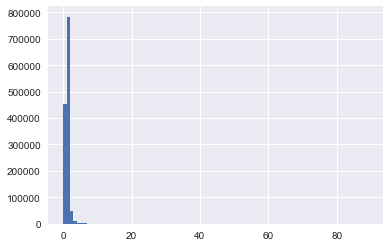

In [261]:
_ = plt.hist([v['weight'] for v in dbg.node.values()], bins=range(90))

In [262]:
all_candidates = list(set(all_candidates) - set(tiles))

In [263]:
random.shuffle(all_candidates)

In [264]:
for candidate in all_candidates:
    covered_weight = sum_attr(dbg, gen_kmers(candidate, k), 'weight')
    p1 = tile_size - covered_weight > 0.65 * tile_size
    p2 = max_weight < 20
    if p1 and p2:
        tiles.add(candidate)
        for kmer in gen_kmers(candidate, k):
            incr_attr(dbg, kmer, 'weight')

In [265]:
graph_sum_attr(dbg, 'weight') / len(dbg)

0.9841032175363705

In [266]:
graph_num_pos_attr(dbg, 'weight') / len(dbg)

0.81204460145727531

In [267]:
len(tiles)

27311

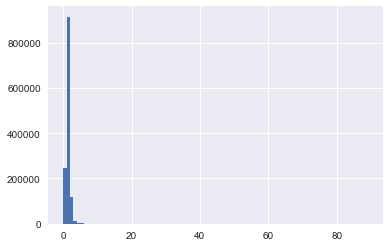

In [268]:
_ = plt.hist([v['weight'] for v in dbg.node.values()], bins=range(90))

In [269]:
all_candidates = list(set(all_candidates) - set(tiles))

In [270]:
random.shuffle(all_candidates)

In [271]:
for candidate in all_candidates:
    covered_weight = sum_attr(dbg, gen_kmers(candidate, k), 'weight')
    p1 = tile_size - covered_weight > 0.4 * tile_size
    p2 = max_weight < 20
    if p1 and p2:
        tiles.add(candidate)
        for kmer in gen_kmers(candidate, k):
            incr_attr(dbg, kmer, 'weight')

In [272]:
graph_sum_attr(dbg, 'weight') / len(dbg)

1.1661790682269817

In [273]:
graph_num_pos_attr(dbg, 'weight') / len(dbg)

0.89154691371654282

In [274]:
len(tiles)

32364

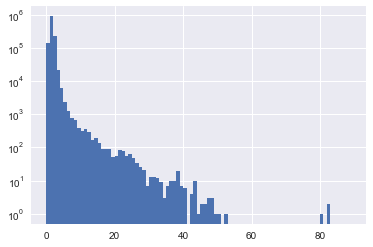

In [275]:
_ = plt.hist([v['weight'] for v in dbg.node.values()], bins=range(90), log=True)

Compare the new tiles with the "simple tiles"

In [276]:
for tile in tiles:
    for kmer in gen_kmers(tile, k):
        incr_attr(dbg, kmer, 'coverage_dbg')

In [277]:
for sr in SeqIO.parse(simple_tiles_file, 'fasta'):
    s = str(sr.seq)
    for kmer in gen_kmers(s, k):
        if dbg.has_node(kmer):
            incr_attr(dbg, kmer, 'coverage_simple')

In [279]:
multiplicity = []
cov_dbg = []
cov_simple = []
for node in dbg.nodes():
    multiplicity.append(dbg.node[node]['multiplicity'])
    cov_dbg.append(dbg.node[node].get('coverage_dbg', 0))
    cov_simple.append(dbg.node[node].get('coverage_simple', 0))
multiplicity = np.asarray(multiplicity)
cov_dbg = np.asarray(cov_dbg)
cov_simple = np.asarray(cov_simple)

In [280]:
(cov_dbg > 0).sum() / len(cov_dbg)

0.89154691371654282

In [281]:
(cov_simple > 0).sum() / len(cov_simple)

0.95462881185446868

(array([  4.53711881e-02,   3.08979478e-01,   5.12638460e-01,
          5.63927529e-02,   4.00459385e-02,   1.06627659e-02,
          8.48160619e-03,   4.06562032e-03,   3.19545644e-03,
          1.97799367e-03,   1.55326170e-03,   1.12622973e-03,
          1.01813008e-03,   6.66231201e-04,   6.17931356e-04,
          4.98331739e-04,   4.13232011e-04,   3.07432350e-04,
          2.90565737e-04,   2.33065921e-04,   1.80932754e-04,
          1.49499522e-04,   1.44132872e-04,   1.21132946e-04,
          8.89330487e-05,   7.05331076e-05,   8.89330487e-05,
          6.05664729e-05,   7.58997571e-05,   5.05998381e-05,
          4.13998675e-05,   4.29331959e-05,   3.14332327e-05,
          3.44998896e-05,   3.21998970e-05,   3.21998970e-05,
          2.60665833e-05,   2.52999190e-05,   1.37999558e-05,
          1.60999485e-05,   3.06665685e-06,   1.07332990e-05,
          7.66664213e-06,   3.83332107e-06,   1.14999632e-05,
          9.19997056e-06,   5.36664949e-06,   5.36664949e-06,
        

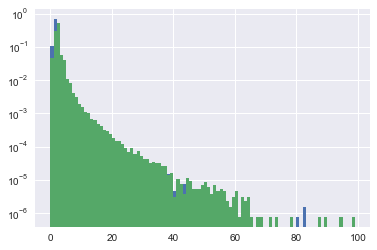

In [285]:
fig, ax = plt.subplots()
ax.hist(cov_dbg, bins=range(100), normed=True, log=True)
ax.hist(cov_simple, bins=range(100), normed=True, log=True)

In [283]:
cov_simple.max()

98

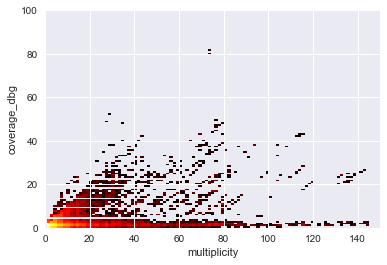

In [183]:
fig, ax = plt.subplots()
_ = ax.hist2d(multiplicity, cov_dbg, bins=100, norm=mpl.colors.LogNorm(), cmap='hot')
_ = ax.set(xlabel='multiplicity', ylabel='coverage_dbg', xlim=(0, 150), ylim=(0, 100))

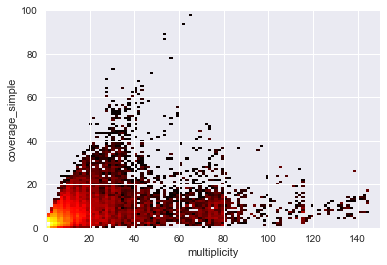

In [184]:
fig, ax = plt.subplots()
_ = ax.hist2d(multiplicity, cov_simple, bins=100, norm=mpl.colors.LogNorm(), cmap='hot')
_ = ax.set(xlabel='multiplicity', ylabel='coverage_simple', xlim=(0, 150), ylim=(0, 100))

In [246]:
reset_attr(dbg, 'weight')
reset_attr(dbg, 'coverage_dbg')
reset_attr(dbg, 'coverage_simple')

In [126]:
start_kmer = candidate[:k]
end_kmer = candidate[-k:]
covered_weight = sum_attr(dbg, gen_kmers(candidate, k), 'weight')

In [208]:
[node for node in dbg.nodes() if dbg.node[node]['weight'] > 80]

['ILDRLFFKCI', 'DRLFFKCIYR']

In [211]:
[component for component in nx.weakly_connected_component_subgraphs(dbg) if component.has_node('ILDRLFFKCI')]

KeyboardInterrupt: 

In [217]:
for component in nx.weakly_connected_component_subgraphs(dbg):
    if component.has_node('ILDRLFFKCI'):
        break

In [219]:
len(component)

2173

/Users/laserson/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/laserson/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/laserson/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/laserson/miniconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.w

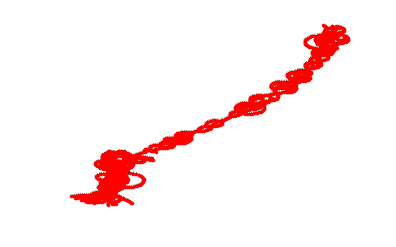

In [220]:
plot_graph(component)

In [128]:
start_dists = [nx.shortest_path_length(udbg, start_kmer, kmer) for kmer in start_kmers if nx.has_path(udbg, start_kmer, kmer)]

In [ ]:
start_dists = [nx.shortest_path_length(udbg, start_kmer, kmer) for kmer in start_kmers if nx.has_path(udbg, start_kmer, kmer)]
end_dists = [nx.shortest_path_length(udbg, end_kmer, kmer) for kmer in end_kmers if nx.has_path(udbg, end_kmer, kmer)]    
p2 = (len(start_dists) == 0) or (min(start_dists) > 0.4 * tile_size)
p3 = (len(end_dists) == 0) or (min(end_dists) > 0.4 * tile_size)

## Effect of k-mer size

## Maximizing k-mer diversity


In [11]:
dbg = virscan2_dbg

In [28]:
def seq_to_path(s, k):
    return list(gen_kmers(s, k))

def path_to_seq(p):
    return ''.join([p[0]] + [n[-1] for n in p[1:]])

def fixed_length_paths_starting(graph, source, length, forward=True):
    """enumerate all paths of a given length starting from source in a digraph

    returns a list of paths; each path is a list of nodes

    forward=True uses "successor paths" while forward=False uses "predecessor paths"
    length is the number of nodes in the path, so corresponding sequence is length + k
    will return paths shorter than length if source node is near a leaf
    """
    if length == 1:
        return [(source,)]
    neighbors = graph.successors(source) if forward else graph.predecessors(source)
    paths = set()
    for neighbor in neighbors:
        for subpath in fixed_length_paths_starting(graph, neighbor, length - 1, forward=forward):
            if forward:
                paths.add((source,) + subpath)
            else:
                paths.add(subpath + (source,))
    return list(paths)

def all_paths_containing(graph, node, length):
    """
    
    length is the number of nodes in the path, so corresponding sequence is length + k
    """
    predecessor_paths = fixed_length_paths_starting(graph, node, length, False)
    successor_paths = fixed_length_paths_starting(graph, node, length, True)
    k = len(node)
    paths = set()
    for (pp, sp) in itertools.product(predecessor_paths, successor_paths):
        joined = pp + sp[1:]
        for i in range(length):
            
            
            paths.add(pp[-i:] + sp[(i - length):])
    

SyntaxError: invalid syntax (<ipython-input-28-fa8fb6dfbf3b>, line 37)

In [19]:
seq_to_path('AGCTNHYTTC', 3)

['AGC', 'GCT', 'CTN', 'TNH', 'NHY', 'HYT', 'YTT', 'TTC']

In [20]:
path_to_seq(seq_to_path('AGCTNHYTTC', 3))

'AGCTNHYTTC'

In [23]:
import itertools

In [24]:
itertools.product?

In [25]:
(1, 3, 4) + (5,)

(1, 3, 4, 5)

In [42]:
g = nx.DiGraph()

In [43]:
g.add_path([0, 1, 2, 3, 4])

In [44]:
g.add_path([0, 1, 2, 3, 5, 6, 7, 8, 9])

In [19]:
list(nx.dfs_preorder_nodes(g, 0))

[0, 1, 2, 3, 4, 5]

In [34]:
g.successors(4)

[]

In [105]:
def dfs_paths_recursive(graph, path, length):
    incr_attr(graph, path[-1], 'visited')
    if len(path) >= length:
        yield path[-length:]
    successors = graph.successors(path[-1])
    for successor in successors:
        if graph.node[successor].get('visited', 0) <= length:
            yield from dfs_paths(graph, path + (successor,), length)

def dfs_paths(graph, source, length):
    reset_attr(graph, 'dfs_visited')
    path = []
    stack = [source]
    while len(stack) > 0:
        node = stack.pop()
        if node is None:
            _ = path.pop()
            continue
        path.append(node)
        incr_attr(graph, path[-1], 'dfs_visited')
        if len(path) >= length:
            yield tuple(path[-length:])
        for successor in graph.successors(path[-1]):
            if graph.node[successor].get('dfs_visited', 0) <= length:
                stack.append(None) # "op code" for shortening end of path
                stack.append(successor)

In [106]:
list(dfs_paths(g, 0, 3))

[(0, 1, 2),
 (1, 2, 3),
 (2, 3, 5),
 (3, 5, 6),
 (5, 6, 7),
 (6, 7, 8),
 (7, 8, 9),
 (2, 3, 4)]

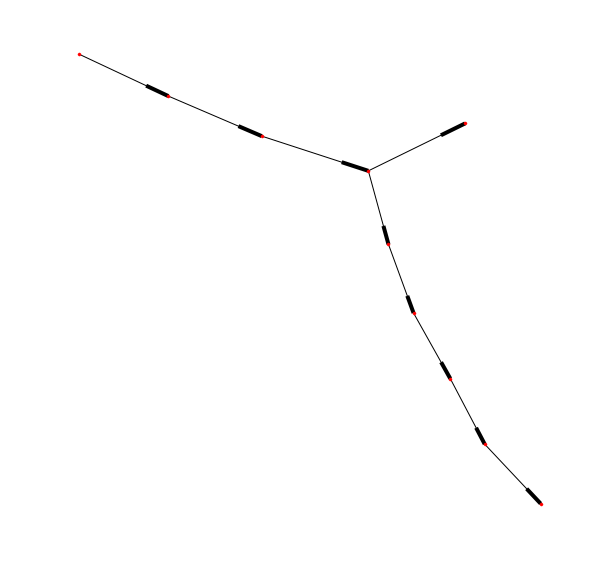

In [45]:
plot_graph(g)

In [58]:
for c in tqdm(nx.weakly_connected_component_subgraphs(dbg)):
    print(len(c))
#     if len(list(nx.simple_cycles(c))) > 0:
#         print('cycle found')
#         break

58620
30915
35035
62929
3517
30089
43283
5521
4079
3935
18227
5209
24816
1241
3439
2027
1196
4561
3537
4451
861
84
3964
5793
1425
156
6166
1378
4841
1872
4781
305
1413
2434
1462
1535
4846
7208
260
261
39
481
1758
107
215
267
330
613
449
135
370
189
108
48
188
302
553
101
536
133
153
316
282
386
410
89
137
127
174
262
176
291
285
428
60
97
240
63
93
302
80
2377
184
61
223
57
501
1158
184
1140
585
472
567
161
454
45
63
207
179
258
86
206
205
145
168
389
577
234
65
229
227
200
885
159
466
146
440
220
973
250
388
300
389
110
65
284
172
163
99
275
65
61
724
273
296
379
374
298
425
71
955
457
620
662
129
3700
2014
729
5819
1049
648
871
835
124
1358
46
651
165
1091
343
721
51
201
4751
538
1032
405
588
294
659
705
163
294
235
332
264
731
731
170
831
837
525
709
349
61
174
47
548
379
316
227
242
206
116
696
593
317
322
320
67
59
1098
116
692
684
1038
662
556
535
588
434
228
690
565
147
493
761
540
106
304
219
1270
425
662
440
371
276
55
929
83
295
185
2030
3298
1174
1236
1118
770
470
5008


KeyboardInterrupt: 

In [69]:
nterm_nodes = [node for node, attr in dbg.node.items() if attr.get('nterm', False)]

In [73]:
for nterm_node in tqdm(nterm_nodes):
    try:
        nx.find_cycle(dbg, nterm_node)
        print('found one')
        break
    except nx.NetworkXNoCycle:
        pass

found one


In [107]:
for nterm_node in tqdm(nterm_nodes):
    print(len(list(dfs_paths(dbg, nterm_node, 46))))

2732269
2666264
2632771
1340778
48941
478966
2333115
2387429
139779
1331247
2729946
2354182
1908985
246873
209052
1337822
2718360
108863
56251
2343894
549814
2380392
2371172
720401
664713
1338970
2732327
2380392
149821
2718940
246873
2380392
2326105
2306817
2380392
2380392
1931789
2343657
1867092
1070563
1196
2704158
2718360
2718360
2718360
2381891
26054
2334100
2334016
2381891
2382613
2387429
2385197
1910134
1864824
1169049
2321055
886948
85392
1897534
2343894
1185380
1142300
1860761
1185380
14349
1185380
2219879
1904436
254980
149821
1260269
1342167
1335499
1337753
1261337
1234271
1248635
1260358
1261337
1326397
1272338
1335970
1338970
197413
1142744
1270624
578232
1241751
1344337
120692
118277
117905
1331858
1325191
1325191
1333402
1330195
189708
549792
1330195
20895
39
169802
201336
240008
257418
29069
111
259226
1331225
497849
19764
17395
197413
1258759
176132
66287
1340839
116287
339
1331236
44691
1335716
19477
1343643
22242
19658
16654
1343643
197982
251960
222416
215
119446
999

134
264
197439
109274
99579
119446
30477
95
0
433
167107
53250
56599
44934
33131
44669
354
38520
37961
2223
2609
31482
118178
111236
118172
139458
127939
111325
120539
773
34721
170163
178916
29247
208
233677
228099
208296
205930
100
109274
773
11634
366
148
4
179543
220
6354
56599
54530
54548
153
795
1544
228099
214
2588
326
63
44934
36740
29153
191
31729
0
77596
110065
30477
25
15072
335
91
2223
266
74
449
121
0
129453
129453
33131
50
26666
104
343
294
326
247
29
15072
160
377
111
377
252
196
42
1458
56535
262
288
47
208
253
54530
3332
354
206
100
109279
116107
120692
326
166
40144
1401
1401
47
219
261
35591
115
257
32383
72009
45070
2725
212
632
39
1198
11858
348
24244
359
9661
93
2404
343
298
234
4630
40598
41138
1852
56949
20421
53370
1366
391
906
22046
4630
23366
1116
7815
23365
0
235
230
34887
28089
65460
3186
434
4953
29641
29546
784
18444
18449
26858
52435
29107
215695
26760
155135
203559
657
475
215695
215695
203559
81560
1155
215695
203559
5773
89767
35377
15095
7567
1375
16

In [103]:
sizes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


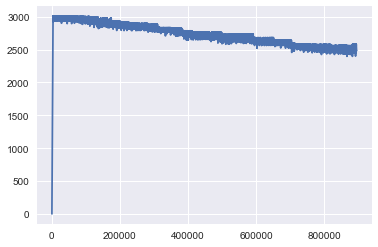

In [104]:
plt.plot(sizes)

In [109]:
nx.write_yaml??

In [111]:
dbg.add_nodes_from?